In [1]:
#cell 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os
import logging
import rainflow

# --- CORRECTED Project and Path Setup ---

# 1. Set the project root to the main 'AI Microgrids' folder
PROJECT_ROOT = r'C:\Users\btuser\Documents\Work\Data Centers\Half Baked Research\DC DC\AI Microgrids'

try:
    os.chdir(PROJECT_ROOT)
    print(f"✓ Successfully changed working directory to: {os.getcwd()}")

    # 2. Add the 'src' directory to the Python path
    # This allows Python to find your custom modules like 'pvstoragesim'.
    src_path = os.path.join(PROJECT_ROOT, 'src')
    if src_path not in sys.path:
        sys.path.insert(0, src_path)
        print(f"✓ Added '{src_path}' to Python path.")

    # 3. Verification step (now works correctly)
    if not os.path.exists('output_tables'):
        print("✗ WARNING: 'output_tables' directory not found in the new CWD. The script may still fail.")
    else:
        print("✓ 'output_tables' directory found.")

except FileNotFoundError:
    print(f"✗ ERROR: The specified PROJECT_ROOT does not exist: {PROJECT_ROOT}")
    print("Please update the PROJECT_ROOT variable in this cell.")


# --- Import from your custom tool suite (now works correctly) ---
from pvstoragesim import evaluate_system, get_solar_generation, SimulationResult
from it_facil import calculate_facility_load, FacilityLoad
from datacenter_analyzer import DatacenterAnalyzer

# --- Configure Logging & Style ---
logging.basicConfig(level=logging.WARNING, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)
plt.style.use('seaborn-v0_8-whitegrid')
print("\nSetup complete.")

✓ Successfully changed working directory to: C:\Users\btuser\Documents\Work\Data Centers\Half Baked Research\DC DC\AI Microgrids
✓ Added 'C:\Users\btuser\Documents\Work\Data Centers\Half Baked Research\DC DC\AI Microgrids\src' to Python path.
✓ 'output_tables' directory found.

Setup complete.


In [2]:
# =================================================================
#  Multi-year degradation with BLAST-Lite (Cell 2 - With Thermal Load)
# =================================================================
import numpy as np
import pandas as pd
import time
import logging
import matplotlib.pyplot as plt
from blast import models as blast_models

# Import the main scripts
from pvstoragesim import evaluate_system, get_solar_generation
from it_facil import FacilityLoad
from datacenter_analyzer import DatacenterAnalyzer
from math import sqrt  

def get_solar_capacity_factor(year, first_year_degradation=0.01, annual_degradation=0.0055):
    if year < 0: return 1.0
    if year == 0: return 1.0
    cap = 1.0 - first_year_degradation
    if year > 1: cap *= (1.0 - annual_degradation) ** (year - 1)
    return max(0.0, min(1.0, cap))

# ── 1. Constants ───────────────────────────────────────────────
LATITUDE, LONGITUDE = 33.6, -115.135
TOTAL_GPUS = 75_000
INITIAL_SOLAR_CAPACITY_MW = 515
INITIAL_BATTERY_POWER_MW = 384
INITIAL_BATTERY_DURATION_HOURS = 4.0
ARCHITECTURE = "dc_coupled"
N_YEARS = 25

CellModel = (blast_models.Lfp_Gr_250AhPrismatic)

# ── 2. Setup ───────────────────────────────────────────────────
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

analyzer = DatacenterAnalyzer(latitude=LATITUDE, longitude=LONGITUDE,
                              total_gpus=TOTAL_GPUS)
FACILITY = analyzer.calculate_facility_load()
SOLAR_Y0 = get_solar_generation(LATITUDE, LONGITUDE, facility_load=FACILITY)

# ── 3. Helper Functions ─────────────────────────────────────────
def _thermal_profile(sim, facility, init_T=25, rt_eff=0.90,
                     mth_per_MWh=2.3, T_min=15, T_max=30):
    """
    Compute battery temperature profile and parasitic thermal load.
    Returns dict with 'battery_temperature' array and 'annual_thermal_kwh'.
    """
    if sim.hourly_data is None or 'battery_soc_mwh' not in sim.hourly_data.columns:
        return {'battery_temperature': np.full(8760, init_T), 
                'annual_thermal_kwh': 0.0}

    hd = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    if cap == 0:
        return {'battery_temperature': np.full(len(hd), init_T),
                'annual_thermal_kwh': 0.0}

    n = len(hd)
    T = np.empty(n, dtype=float)
    T[0] = init_T
    
    # Track parasitic loads
    parasitic_kw = np.zeros(n)
    
    one_way = 1 - sqrt(rt_eff)
    m_th = mth_per_MWh * cap  # MJ/K (actually more like kWh/K given the usage)
    pue = np.asarray(facility.hourly_pue)

    for h in range(1, n):
        p_ch = abs(hd['battery_charge_mw'].iat[h])
        p_dis = abs(hd['battery_discharge_mw'].iat[h])
        
        # Heat generation from losses (kW)
        heat_kw = (p_ch + p_dis) * one_way * 1000
        
        # Predicted temperature rise (interpreting m_th as kWh/K for consistency)
        pred_T = T[h-1] + heat_kw / m_th if m_th > 0 else T[h-1]
        
        if pred_T > T_max:
            # Cooling required
            excess_heat_kw = (pred_T - T_max) * m_th
            # CORRECTED: Multiply by (PUE - 1), not divide!
            # Lower PUE → more efficient cooling → less electrical power needed
            elec_kw = excess_heat_kw * max(pue[h] - 1, 0.1)  # Min overhead of 0.1
            parasitic_kw[h] = elec_kw
            T[h] = T_max
            
        elif pred_T < T_min and heat_kw < 1.0:  # Heating when idle
            # Heating needed
            heat_deficit_kw = (T_min - pred_T) * m_th
            parasitic_kw[h] = heat_deficit_kw  # Direct electrical heating
            T[h] = T_min
        else:
            T[h] = pred_T

    # Convert to annual energy
    annual_thermal_kwh = parasitic_kw.sum()
    
    return {'battery_temperature': T,
            'annual_thermal_kwh': annual_thermal_kwh}

# Solar-panel degradation
def get_solar_capacity_factor(year, first=0.01, annual=0.0055):
    if year == 0: return 1.0
    cap = 1.0 - first
    if year > 1:
        cap *= (1.0 - annual) ** (year-1)
    return cap

# -------------------------------


def run_blast_for_segment(stressors, years):
    # This helper function is self-contained and correct.
    time_concat, soc_concat, temp_concat = [], [], []
    for i, s in enumerate(stressors):
        offset = i * 365 * 24 * 3600
        time_concat.extend(s['Time_s'] + offset); soc_concat.extend(s['SOC']); temp_concat.extend(s['Temperature_C'])
    multi_year_stressor = {'Time_s': np.array(time_concat), 'SOC': np.array(soc_concat), 'Temperature_C': np.array(temp_concat)}
    cell = CellModel(); cell.simulate_battery_life(multi_year_stressor, threshold_time=years, is_constant_input=False, is_conserve_energy_throughput=False)
    t_days, q, q_cal, q_cyc = cell.stressors['t_days'], cell.outputs['q'], cell.states['qLoss_t'], cell.states['qLoss_EFC']
    efc_cumulative = cell.stressors.get('efc', np.zeros_like(t_days)); fades = []
    prev_tot_loss = prev_cal_loss = prev_cyc_loss = prev_efc = 0.0
    for yr in range(years):
        idx = int(np.argmin(np.abs(t_days - (yr + 1) * 365.0)))
        tot_loss, cal_loss, cyc_loss, efc_now = 1.0 - q[idx], q_cal[idx], q_cyc[idx], efc_cumulative[idx]
        fades.append({'annual_fade_pct':(tot_loss-prev_tot_loss)*100.0, 'annual_calendar_fade_pct':(cal_loss-prev_cal_loss)*100.0,
                      'annual_cycle_fade_pct':(cyc_loss-prev_cyc_loss)*100.0, 'annual_efc_blastlite':efc_now-prev_efc})
        prev_tot_loss, prev_cal_loss, prev_cyc_loss, prev_efc = tot_loss, cal_loss, cyc_loss, efc_now
    return fades

def build_year_stressor(year, current_capacity_fraction):
    """Enhanced version that calculates C-rate statistics and thermal load"""
    pv_factor = get_solar_capacity_factor(year)
    sim = evaluate_system(
        latitude=LATITUDE, longitude=LONGITUDE,
        solar_capacity_mw=INITIAL_SOLAR_CAPACITY_MW * pv_factor,
        battery_power_mw=INITIAL_BATTERY_POWER_MW , 
        battery_duration_hours= INITIAL_BATTERY_DURATION_HOURS* current_capacity_fraction, #scale duration
        facility_load=FACILITY, architecture=ARCHITECTURE,
        solar_profile=SOLAR_Y0, return_hourly=True
    )
    
    hd = sim.hourly_data
    cap_mwh = hd['battery_soc_mwh'].max() if hd is not None else 0
    soc_pattern = (hd['battery_soc_mwh'] / cap_mwh).values if cap_mwh > 0 else np.zeros(len(hd) if hd is not None else 8760)
    
    # Get thermal profile with load calculation
    therm_result = _thermal_profile(sim, FACILITY)
    therm = therm_result['battery_temperature']
    thermal_load_kwh = therm_result['annual_thermal_kwh']
    
    # Calculate thermal load as percentage of THIS YEAR'S throughput
    throughput_kwh = sim.stress_features['throughput_mwh'] * 1000 if sim.stress_features else 0
    thermal_pct = (thermal_load_kwh / throughput_kwh * 100.0 if throughput_kwh > 0 else 0.0)
    
    # Calculate C-rates
    if hd is not None and cap_mwh > 0:
        charge_power = hd['battery_charge_mw'].values
        discharge_power = hd['battery_discharge_mw'].values
        total_power = charge_power + discharge_power
        c_rates = total_power / cap_mwh
        
        active_c_rates = c_rates[c_rates > 0.01]
        
        avg_c_rate = active_c_rates.mean() if len(active_c_rates) > 0 else 0.0
        max_c_rate = c_rates.max()
        pct_time_active = len(active_c_rates) / len(c_rates) * 100
        median_c_rate = np.median(active_c_rates) if len(active_c_rates) > 0 else 0.0
    else:
        avg_c_rate = max_c_rate = pct_time_active = median_c_rate = 0.0
    
    return {
        'stressor': dict(Time_s=np.arange(len(soc_pattern)) * 3600,
                         SOC=soc_pattern,
                         Temperature_C=therm),
        'uptime_pct': sim.uptime_pct,
        'pv_factor': pv_factor,
        'stress_features': (
            sim.stress_features if sim.stress_features is not None else
            {'mean_soc': 0.5, 'cycle_counts_by_dod': [0]*10,
             'efc_sum_by_dod': [0]*10, 'throughput_mwh': 0}
        ),
        'c_rate_stats': {
            'avg_c_rate': avg_c_rate,
            'max_c_rate': max_c_rate,
            'median_c_rate': median_c_rate,
            'pct_time_active': pct_time_active
        },
        'thermal_stats': {
            'thermal_load_kwh': thermal_load_kwh,
            'thermal_pct': thermal_pct  # Now calculated per year
        }
    }

# ── 4. Main Simulation Function ────────────────────────────────
def run_full_simulation():
    logger.info("Starting iterative ground-truth simulation with full stressor collection...")
    t0 = time.time()
    
    capacity_fraction = 1.0
    battery1_stressor_history = []
    battery2_stressor_history = []
    results_rows = []

    for year in range(N_YEARS):
        logger.info(f"Simulating Year {year}... Current Capacity: {capacity_fraction:.3f}")
        if year == 13:
            capacity_fraction = 1.0
        
        year_data = build_year_stressor(year, capacity_fraction)
        
        if year < 13:
            battery1_stressor_history.append(year_data['stressor'])
            current_history = battery1_stressor_history
        else:
            battery2_stressor_history.append(year_data['stressor'])
            current_history = battery2_stressor_history
        
        all_fades_so_far = run_blast_for_segment(current_history, years=len(current_history))
        fade_info_this_year = all_fades_so_far[-1]
        
        results_rows.append({
            'year': year,
            'uptime_pct': year_data['uptime_pct'],
            'solar_capacity_pct': year_data['pv_factor'] * 100,
            'battery_capacity_pct': capacity_fraction * 100,
            **year_data['stress_features'],
            **fade_info_this_year,
            **year_data['c_rate_stats'],
            **year_data['thermal_stats']
        })
        
        capacity_fraction *= (1 - fade_info_this_year['annual_fade_pct'] / 100.0)

    results_df = pd.DataFrame(results_rows)
    print(f"\nSimulation complete in {time.time() - t0:.1f}s")
    return results_df

# --- 5. Execute Simulation ---
results_df = run_full_simulation()

# Print Year 0 thermal info
print(f"\nYear 0 Thermal Load: {results_df.iloc[0]['thermal_load_kwh']:,.0f} kWh")
print(f"Year 0 Battery Throughput: {results_df.iloc[0]['throughput_mwh']*1000:,.0f} kWh")
print(f"Year 0 Thermal as % of Throughput: {results_df.iloc[0]['thermal_pct']:.4f}%")


Simulation complete in 13.3s

Year 0 Thermal Load: 4,635,318 kWh
Year 0 Battery Throughput: 405,259,940 kWh
Year 0 Thermal as % of Throughput: 1.1438%



--- Analysis ---
System uptime remained above 99% for all 25 years.

--- Thermal Load Summary ---
Year 0 Thermal Load as % of Throughput: 1.1438%
Average Thermal Load across all years: 1.1445%

--- Ground-Truth Simulation Results (Thermal Load as % of Throughput) ---


,year,uptime_pct,solar_capacity_pct,battery_capacity_pct,mean_soc,throughput_cycles,avg_c_rate,max_c_rate,thermal_pct_of_throughput,annual_fade_pct,annual_calendar_fade_pct,annual_cycle_fade_pct,annual_efc_blastlite
0,0,99.658,100.000,100.000,0.723,263.841,0.081,0.207,1.144,2.775,1.875,0.900,262.103
1,1,99.612,99.000,97.225,0.714,271.295,0.083,0.210,1.144,1.508,0.809,0.698,261.860
2,2,99.578,98.456,95.759,0.709,275.403,0.084,0.212,1.144,1.269,0.631,0.638,261.482
3,3,99.532,97.914,94.544,0.705,278.893,0.085,0.214,1.144,1.134,0.535,0.599,260.088
4,4,99.532,97.375,93.472,0.701,282.028,0.086,0.215,1.144,1.043,0.473,0.570,258.499
5,5,99.498,96.840,92.497,0.697,284.943,0.086,0.215,1.144,0.979,0.432,0.547,256.946
6,6,99.486,96.307,91.592,0.693,287.696,0.087,0.216,1.144,0.923,0.398,0.525,254.466
7,7,99.475,95.778,90.746,0.690,290.312,0.088,0.217,1.144,0.881,0.372,0.509,252.702
8,8,99.452,95.251,89.946,0.686,292.822,0.089,0.217,1.144,0.843,0.350,0.493,250.077
9,9,99.372,94.727,89.188,0.683,295.219,0.089,0.218,1.144,0.811,0.333,0.479,247.925


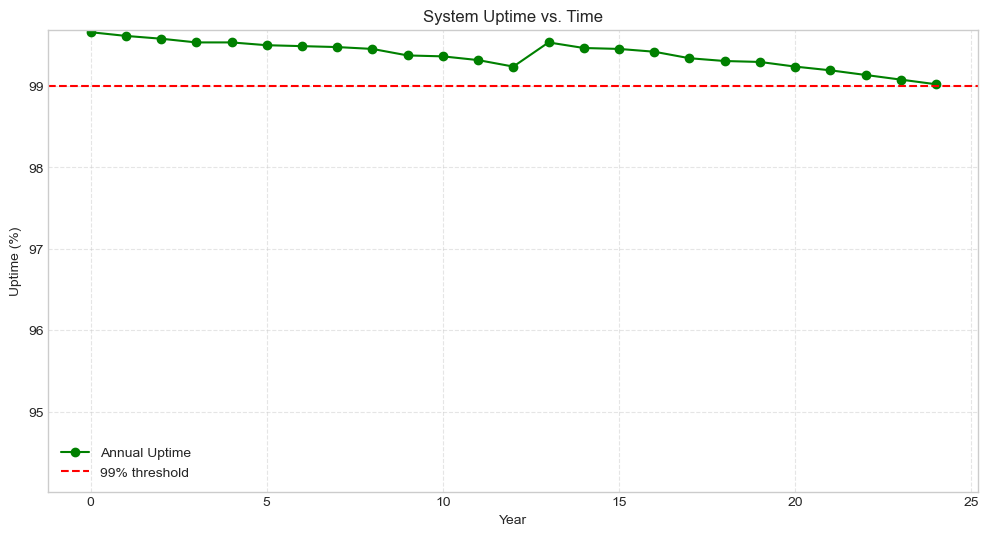

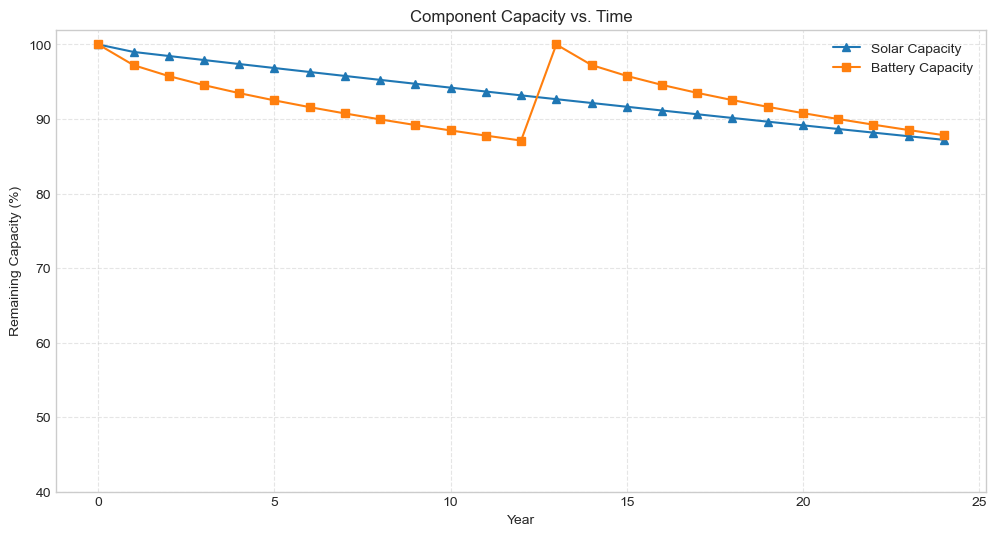

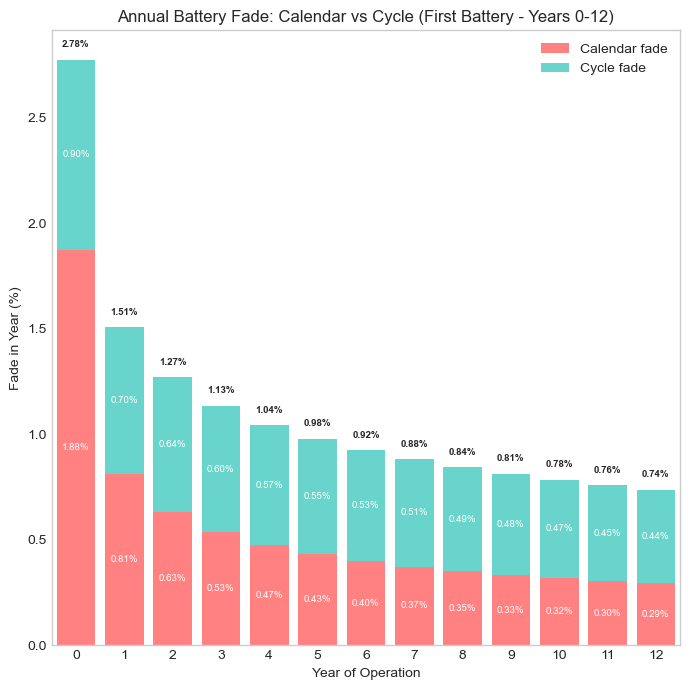


--- Degradation Breakdown Summary ---
Average annual calendar fade : 0.555% ± 0.420%
Average annual cycle fade    : 0.568% ± 0.124%
Calendar fading contribution: 49.4%
Cycle fading contribution   : 50.6%
Total cumulative capacity loss: 12.2% after 25 years

--- Thermal Load Statistics ---
Year 0 thermal load: 1.1438% of throughput
Average thermal load: 1.1445% ± 0.0004% of throughput
Min thermal %: 1.1438% (Year 0)
Max thermal %: 1.1453% (Year 24)
Total thermal energy over 25 years: 115.74 GWh



In [3]:
# =================================================================
#  Analysis, Tables and Plots (Cell 3 - Streamlined with Thermal %)
# =================================================================

# --- 1.  Uptime threshold check --------------------------------
UPTIME_THRESHOLD = 99
threshold_year = None
below = results_df[results_df['uptime_pct'] < UPTIME_THRESHOLD]
if not below.empty:
    threshold_year = int(below['year'].iloc[0])

print("\n--- Analysis ---")
if threshold_year is not None:
    print(f"Uptime drops below {UPTIME_THRESHOLD}% in Year {threshold_year}.")
else:
    print(f"System uptime remained above {UPTIME_THRESHOLD}% for all {N_YEARS} years.")

print(f"\n--- Thermal Load Summary ---")
print(f"Year 0 Thermal Load as % of Throughput: {results_df.iloc[0]['thermal_pct']:.4f}%")
avg_thermal_pct = results_df['thermal_pct'].mean()
print(f"Average Thermal Load across all years: {avg_thermal_pct:.4f}%")

# --- 2.  Show table with throughput cycles and thermal load -----
df_display = results_df.copy()
initial_batt_mwh = INITIAL_BATTERY_POWER_MW * INITIAL_BATTERY_DURATION_HOURS
df_display['current_capacity_mwh'] = (df_display['battery_capacity_pct'] / 100) * initial_batt_mwh
df_display['throughput_cycles'] = df_display.apply(
    lambda row: row['throughput_mwh'] / row['current_capacity_mwh'] if row['current_capacity_mwh'] > 0 else 0,
    axis=1
)

# Rename thermal_pct for clarity in display
df_display['thermal_pct_of_throughput'] = df_display['thermal_pct']

display_columns = [
    'year','uptime_pct','solar_capacity_pct','battery_capacity_pct','mean_soc',
    'throughput_cycles','avg_c_rate','max_c_rate',
    'thermal_pct_of_throughput',  # Thermal as % of throughput
    'annual_fade_pct','annual_calendar_fade_pct',
    'annual_cycle_fade_pct','annual_efc_blastlite'
]
print("\n--- Ground-Truth Simulation Results (Thermal Load as % of Throughput) ---")
with pd.option_context('display.precision', 3, 'display.max_columns', 15):
    display(df_display[display_columns])

# --- 3.  Essential Plots Only ---------------------------

# --- 3a. Uptime curve ---
plt.figure(figsize=(12, 6))
plt.plot(results_df['year'], results_df['uptime_pct'],
         marker='o', color='green', label='Annual Uptime')
plt.axhline(UPTIME_THRESHOLD, color='r', ls='--',
            label=f'{UPTIME_THRESHOLD}% threshold')
if threshold_year is not None:
    plt.axvline(threshold_year, color='grey', ls=':',
                label=f'Crossed in Year {threshold_year}')
    y_th = results_df.loc[results_df['year']==threshold_year,'uptime_pct'].iloc[0]
    plt.text(threshold_year+0.4, y_th, f'Year {threshold_year}',
             va='bottom', rotation=90)
plt.title('System Uptime vs. Time')
plt.xlabel('Year')
plt.ylabel('Uptime (%)')
plt.ylim(bottom=max(80, results_df['uptime_pct'].min()-5))
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.show()

# --- 3b. Capacity curves ---
plt.figure(figsize=(12, 6))
plt.plot(results_df['year'], results_df['solar_capacity_pct'],
         marker='^', label='Solar Capacity')
plt.plot(results_df['year'], results_df['battery_capacity_pct'],
         marker='s', label='Battery Capacity')
plt.title('Component Capacity vs. Time')
plt.ylabel('Remaining Capacity (%)')
plt.xlabel('Year')
plt.ylim(40, 102)
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.show()

# --- 3c. Stacked bar: marginal calendar vs cycle fade (First Battery Only) ---
plt.figure(figsize=(7, 7))  # Reduced width, slightly reduced height

# Filter data for first battery only (years 0-12)
first_battery_mask = results_df['year'] <= 12
years_filtered = results_df[first_battery_mask]['year']
cal_marginal_filtered = results_df[first_battery_mask]['annual_calendar_fade_pct']
cyc_marginal_filtered = results_df[first_battery_mask]['annual_cycle_fade_pct']

bar_w = 0.8
plt.bar(years_filtered, cal_marginal_filtered, bar_w, label='Calendar fade',
        color='#FF6B6B', alpha=0.85)
plt.bar(years_filtered, cyc_marginal_filtered, bar_w, bottom=cal_marginal_filtered,
        label='Cycle fade', color='#4ECDC4', alpha=0.85)

# Add text annotations only for the filtered data
for y, cal, cyc in zip(years_filtered, cal_marginal_filtered, cyc_marginal_filtered):
    total = cal + cyc
    if total > 0.05:
        plt.text(y, total + 0.05, f'{total:.2f}%',
                 ha='center', va='bottom', fontsize=7, fontweight='bold')
        if cal > 0.05:
            plt.text(y, cal/2, f'{cal:.2f}%',
                     ha='center', va='center', fontsize=7, color='white')
        if cyc > 0.05:
            plt.text(y, cal + cyc/2, f'{cyc:.2f}%',
                     ha='center', va='center', fontsize=7, color='white')

plt.title('Annual Battery Fade: Calendar vs Cycle (First Battery - Years 0-12)')
plt.xlabel('Year of Operation')
plt.ylabel('Fade in Year (%)')
plt.xlim(-0.5, 12.5)  # Set explicit x-axis limits
plt.xticks(years_filtered[::1])  # Show every year since we have fewer data points
plt.grid(False)  # Explicitly turn off all gridlines
plt.legend()
plt.tight_layout()
#plt.savefig('battery_fade_chart.png', dpi=300, bbox_inches='tight')
plt.show()
# --- 4. Degradation Summary ---
print("\n--- Degradation Breakdown Summary ---")

# Define marginal fade variables from the DataFrame
cal_marginal = results_df['annual_calendar_fade_pct']
cyc_marginal = results_df['annual_cycle_fade_pct']

# Averages of marginal fades
avg_cal = cal_marginal.mean(); std_cal = cal_marginal.std()
avg_cyc = cyc_marginal.mean(); std_cyc = cyc_marginal.std()
print(f"Average annual calendar fade : {avg_cal:.3f}% ± {std_cal:.3f}%")
print(f"Average annual cycle fade    : {avg_cyc:.3f}% ± {std_cyc:.3f}%")

total_calendar = cal_marginal.sum()
total_cycle = cyc_marginal.sum()
total_fade = total_calendar + total_cycle
if total_fade > 0:
    print(f"Calendar fading contribution: {total_calendar/total_fade*100:.1f}%")
    print(f"Cycle fading contribution   : {total_cycle/total_fade*100:.1f}%")

final_cap = results_df['battery_capacity_pct'].iloc[-1]
print(f"Total cumulative capacity loss: {100-final_cap:.1f}% after {N_YEARS} years")

# Thermal load statistics
print(f"\n--- Thermal Load Statistics ---")
print(f"Year 0 thermal load: {results_df.iloc[0]['thermal_pct']:.4f}% of throughput")
print(f"Average thermal load: {results_df['thermal_pct'].mean():.4f}% ± {results_df['thermal_pct'].std():.4f}% of throughput")
print(f"Min thermal %: {results_df['thermal_pct'].min():.4f}% (Year {results_df.loc[results_df['thermal_pct'].idxmin(), 'year']})")
print(f"Max thermal %: {results_df['thermal_pct'].max():.4f}% (Year {results_df.loc[results_df['thermal_pct'].idxmax(), 'year']})")
print(f"Total thermal energy over {N_YEARS} years: {results_df['thermal_load_kwh'].sum()/1e6:.2f} GWh\n")

=== ANALYZING CONFIGURED SYSTEM ===
Location: 33.60°N, -115.14°W
Datacenter: 75,000 GPUs
Solar: 515 MW
Battery: 384 MW / 4.0 hours (1536 MWh)
Architecture: dc_coupled

Facility design load: 99.6 MW
Average annual load: 76.1 MW

=== SYSTEM PERFORMANCE SUMMARY ===
System Uptime: 99.66%
Energy Served: 99.68%
Solar Generation: 1,454,988 MWh/year
Battery Cycles: 263.8 cycles/year
Battery Charged: 405,644 MWh/year
Battery Discharged: 405,260 MWh/year

=== BATTERY SOC ANNUAL SUMMARY ===
Battery Energy Capacity: 1536.0 MWh
Annual Battery Cycles: 263.8
Total Energy Charged: 405,644 MWh
Total Energy Discharged: 405,260 MWh

SOE Statistics (%):
  Mean: 72.7%
  Median: 77.8%
  Min: 0.0%
  Max: 100.0%
  Std Dev: 26.1%

Time in SOE Ranges:
  0-20%: 2.1% of time
  20-40%: 12.8% of time
  40-60%: 17.8% of time
  60-80%: 19.7% of time
  80-100%: 17.9% of time

4 Weeks with Highest SOE Volatility:
      mean  min    max   std
week                        
10    62.6  0.0  100.0  33.3
3     55.2  0.0  100

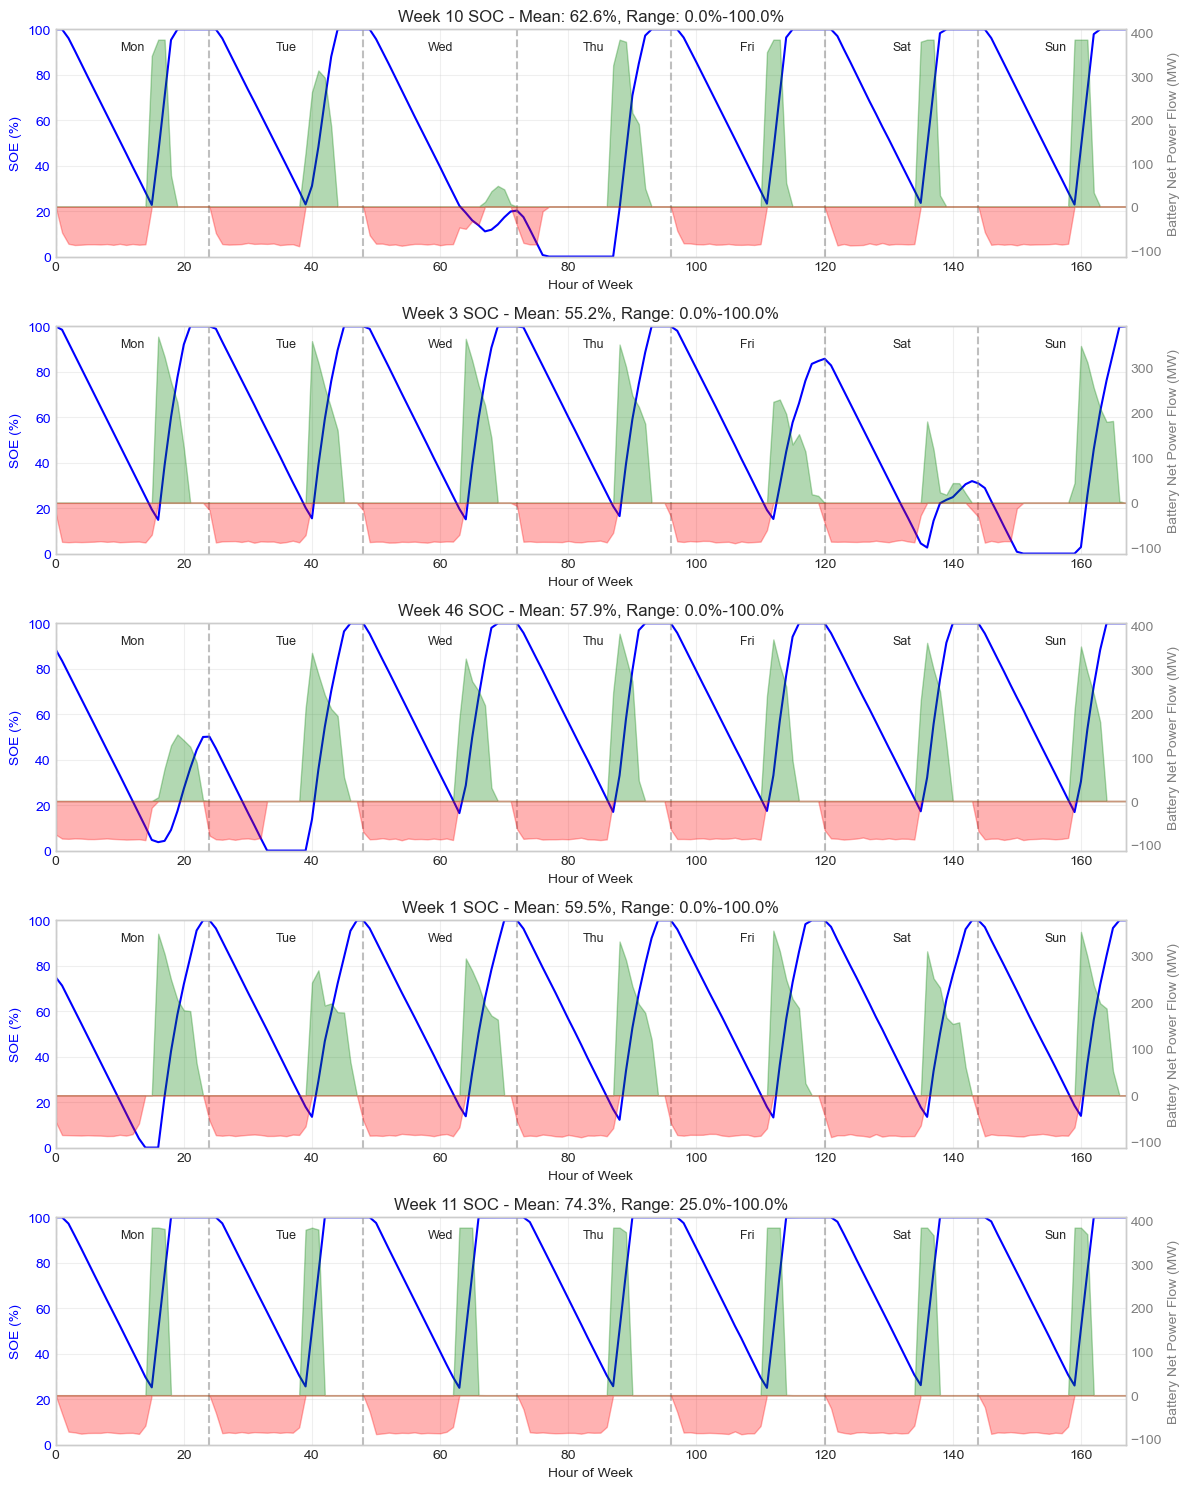

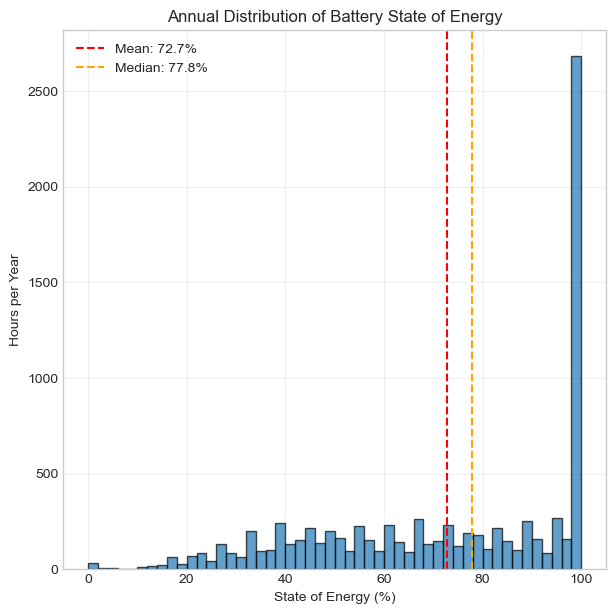

Analysis completed in 12.6 seconds

=== ANALYSIS COMPLETE ===
Final uptime: 99.66%


In [4]:
# (cell 4) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

def analyze_battery_soe_core(sim_result, battery_energy_mwh=None, weeks_to_plot=None):
    """
    Analyze and plot battery state-of-energy from simulation results.
    
    Args:
        sim_result: SimulationResult object from evaluate_system with return_hourly=True
        battery_energy_mwh: Total battery capacity (if None, calculated from max SOC)
        weeks_to_plot: List of week numbers to plot (1-52), if None plots representative weeks
    """
    if sim_result.hourly_data is None:
        raise ValueError("No hourly data available. Run evaluate_system with return_hourly=True")
    
    # Extract SOC data
    hourly_data = sim_result.hourly_data.copy()
    soe_mwh = hourly_data['battery_soc_mwh'].values
    
    # Determine battery capacity
    if battery_energy_mwh is None:
        battery_energy_mwh = soe_mwh.max()
    
    # Calculate SOC percentage
    soe_pct = (soe_mwh / battery_energy_mwh) * 100
    hourly_data['soe_pct'] = soe_pct
    
    # Add datetime info for easier analysis
    hourly_data['hour_of_year'] = range(len(hourly_data))
    hourly_data['week'] = hourly_data['hour_of_year'] // 168 + 1  # 168 hours per week
    hourly_data['hour_of_week'] = hourly_data['hour_of_year'] % 168
    hourly_data['day_of_week'] = hourly_data['hour_of_week'] // 24
    hourly_data['hour_of_day'] = hourly_data['hour_of_week'] % 24
    
    # Summary statistics
    print("=== BATTERY SOC ANNUAL SUMMARY ===")
    print(f"Battery Energy Capacity: {battery_energy_mwh:.1f} MWh")
    print(f"Annual Battery Cycles: {sim_result.battery_cycles_per_year:.1f}")
    print(f"Total Energy Charged: {sim_result.battery_charged_mwh:,.0f} MWh")
    print(f"Total Energy Discharged: {sim_result.battery_discharged_mwh:,.0f} MWh")
    print()
    
    print("SOE Statistics (%):")
    print(f"  Mean: {soe_pct.mean():.1f}%")
    print(f"  Median: {np.median(soe_pct):.1f}%")
    print(f"  Min: {soe_pct.min():.1f}%")
    print(f"  Max: {soe_pct.max():.1f}%")
    print(f"  Std Dev: {soe_pct.std():.1f}%")
    print()
    
    # Time spent in SOC ranges
    soc_ranges = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]
    print("Time in SOE Ranges:")
    for low, high in soc_ranges:
        mask = (soe_pct >= low) & (soe_pct < high)
        pct_time = mask.sum() / len(soe_pct) * 100
        print(f"  {low}-{high}%: {pct_time:.1f}% of time")
    print()
    
    # Weekly statistics
    weekly_stats = hourly_data.groupby('week')['soe_pct'].agg(['mean', 'min', 'max', 'std']).round(1)
    
    # Find the 4 weeks with highest standard deviation (most volatile)
    highest_std_weeks = weekly_stats.nlargest(4, 'std')
    print("4 Weeks with Highest SOE Volatility:")
    print(highest_std_weeks[['mean', 'min', 'max', 'std']])
    print()
    
    # Find the most "typical" week (closest to modal characteristics)
    median_mean = weekly_stats['mean'].median()
    median_std = weekly_stats['std'].median()
    median_range = (weekly_stats['max'] - weekly_stats['min']).median()
    
    # Calculate composite distance for each week
    weekly_stats['mean_dist'] = abs(weekly_stats['mean'] - median_mean)
    weekly_stats['std_dist'] = abs(weekly_stats['std'] - median_std)
    weekly_stats['range_dist'] = abs((weekly_stats['max'] - weekly_stats['min']) - median_range)
    
    # Normalize distances (0-1 scale) and combine
    weekly_stats['composite_distance'] = (
        weekly_stats['mean_dist'] / weekly_stats['mean_dist'].max() +
        weekly_stats['std_dist'] / weekly_stats['std_dist'].max() +
        weekly_stats['range_dist'] / weekly_stats['range_dist'].max()
    ) / 3
    
    # Find most typical week (minimum composite distance)
    most_typical_week = weekly_stats.loc[weekly_stats['composite_distance'].idxmin()]
    print(f"Most Typical Week (Week {most_typical_week.name}):")
    print(f"  Mean SOC: {most_typical_week['mean']:.1f}%, Std: {most_typical_week['std']:.1f}%")
    print(f"  Range: {most_typical_week['min']:.1f}%-{most_typical_week['max']:.1f}%")
    print(f"  (Median weekly stats: Mean={median_mean:.1f}%, Std={median_std:.1f}%, Range={median_range:.1f}%)")
    print()
    
    # Default weeks to plot if not specified
    if weeks_to_plot is None:
        # Plot the 4 highest volatility weeks plus the most typical week
        volatile_weeks = highest_std_weeks.index.tolist()
        typical_week = [most_typical_week.name]
        weeks_to_plot = volatile_weeks + typical_week
        print(f"Plotting 4 most volatile weeks: {volatile_weeks}")
        print(f"Plus most typical week: {typical_week}")
        print(f"Total weeks to plot: {weeks_to_plot}")
    
    # Plot individual weeks
    n_weeks = len(weeks_to_plot)
    fig, axes = plt.subplots(n_weeks, 1, figsize=(12, 3*n_weeks))
    if n_weeks == 1:
        axes = [axes]
    
    for i, week_num in enumerate(weeks_to_plot):
        week_data = hourly_data[hourly_data['week'] == week_num]
        
        if len(week_data) == 0:
            print(f"Warning: No data for week {week_num}")
            continue
            
        ax = axes[i]
        
        # Plot SOC
        hours = range(len(week_data))
        ax.plot(hours, week_data['soe_pct'], 'b-', linewidth=1.5, label='SOC %')
        ax.set_ylabel('SOE (%)', color='b')
        ax.tick_params(axis='y', labelcolor='b')
        ax.set_ylim(0, 100)
        
        # Add grid for readability (only for primary axis)
        ax.grid(True, alpha=0.3)
        
        # Mark days
        for day in range(8):  # 0-6 for full week, 7 for end marker
            ax.axvline(day * 24, color='gray', alpha=0.5, linestyle='--')
            if day < 7:
                ax.text(day * 24 + 12, 95, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][day], 
                       ha='center', va='top', fontsize=9)
        
        # Secondary axis for charging/discharging
        ax2 = ax.twinx()
        charge_power = week_data['battery_charge_mw'].values
        discharge_power = -week_data['battery_discharge_mw'].values  # Negative for discharge
        
        ax2.fill_between(hours, 0, charge_power, alpha=0.3, color='green', label='Charging')
        ax2.fill_between(hours, 0, discharge_power, alpha=0.3, color='red', label='Discharging')
        ax2.set_ylabel('Battery Net Power Flow (MW)', color='gray')
        ax2.tick_params(axis='y', labelcolor='gray')
        
        # Disable grid for secondary axis
        ax2.grid(False)
        
        # Title with week stats
        week_mean = week_data['soe_pct'].mean()
        week_min = week_data['soe_pct'].min()
        week_max = week_data['soe_pct'].max()
        ax.set_title(f'Week {week_num} SOC - Mean: {week_mean:.1f}%, Range: {week_min:.1f}%-{week_max:.1f}%')
        
        ax.set_xlabel('Hour of Week')
        ax.set_xlim(0, 167)  # 168 hours = 7 days * 24 hours
    
    plt.tight_layout()
    plt.show()
    
    # Plot annual SOE distribution
    plt.figure(figsize=(7, 7))
    plt.hist(soe_pct, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(soe_pct.mean(), color='red', linestyle='--', label=f'Mean: {soe_pct.mean():.1f}%')
    plt.axvline(np.median(soe_pct), color='orange', linestyle='--', label=f'Median: {np.median(soe_pct):.1f}%')
    plt.xlabel('State of Energy (%)')
    plt.ylabel('Hours per Year')
    plt.title('Annual Distribution of Battery State of Energy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('battery_soe_hist.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return hourly_data

def analyze_configured_system():
    """Run the configured system and analyze battery SOE patterns."""
    print("=== ANALYZING CONFIGURED SYSTEM ===")
    print(f"Location: {LATITUDE:.2f}°N, {LONGITUDE:.2f}°W")
    print(f"Datacenter: {TOTAL_GPUS:,} GPUs")
    print(f"Solar: {INITIAL_SOLAR_CAPACITY_MW:.0f} MW")
    print(f"Battery: {INITIAL_BATTERY_POWER_MW:.0f} MW / {INITIAL_BATTERY_DURATION_HOURS:.1f} hours ({INITIAL_BATTERY_POWER_MW * INITIAL_BATTERY_DURATION_HOURS:.0f} MWh)")
    print(f"Architecture: {ARCHITECTURE}")
    print()
    
    start_time = time.time()
    
    # Create facility load
    analyzer = DatacenterAnalyzer(
        latitude=LATITUDE,
        longitude=LONGITUDE,
        total_gpus=TOTAL_GPUS
    )
    
    facility_load = analyzer.calculate_facility_load()
    
    print(f"Facility design load: {facility_load.facility_load_design_mw:.1f} MW")
    print(f"Average annual load: {facility_load.facility_load_avg_mw:.1f} MW")
    print()
    
    # Run simulation with hourly data
    result = evaluate_system(
        latitude=LATITUDE,
        longitude=LONGITUDE,
        solar_capacity_mw=INITIAL_SOLAR_CAPACITY_MW,
        battery_power_mw=INITIAL_BATTERY_POWER_MW,
        battery_duration_hours=INITIAL_BATTERY_DURATION_HOURS,
        facility_load=facility_load,
        architecture=ARCHITECTURE,
        return_hourly=True
    )
    
    # Print system performance summary
    print("=== SYSTEM PERFORMANCE SUMMARY ===")
    print(f"System Uptime: {result.uptime_pct:.2f}%")
    print(f"Energy Served: {result.energy_served_pct:.2f}%")
    print(f"Solar Generation: {result.solar_generation_mwh:,.0f} MWh/year")
    print(f"Battery Cycles: {result.battery_cycles_per_year:.1f} cycles/year")
    print(f"Battery Charged: {result.battery_charged_mwh:,.0f} MWh/year")
    print(f"Battery Discharged: {result.battery_discharged_mwh:,.0f} MWh/year")
    print()
    
    # Analyze battery SOE patterns
    battery_energy_mwh = INITIAL_BATTERY_POWER_MW * INITIAL_BATTERY_DURATION_HOURS
    hourly_data = analyze_battery_soe_core(result, battery_energy_mwh)
    
    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.1f} seconds")
    
    return {
        'hourly_data': hourly_data,
        'simulation_result': result,
        'facility_load': facility_load
    }

# Run analysis with your configuration
if __name__ == "__main__":
    results = analyze_configured_system()
    
    print("\n=== ANALYSIS COMPLETE ===")
    print(f"Final uptime: {results['simulation_result'].uptime_pct:.2f}%")

--- Running Year 0 Simulation for Energy Flow Plot ---
Plotting 3 most volatile weeks: [0, 51, 49]
Plus most typical week: [np.int64(10)]


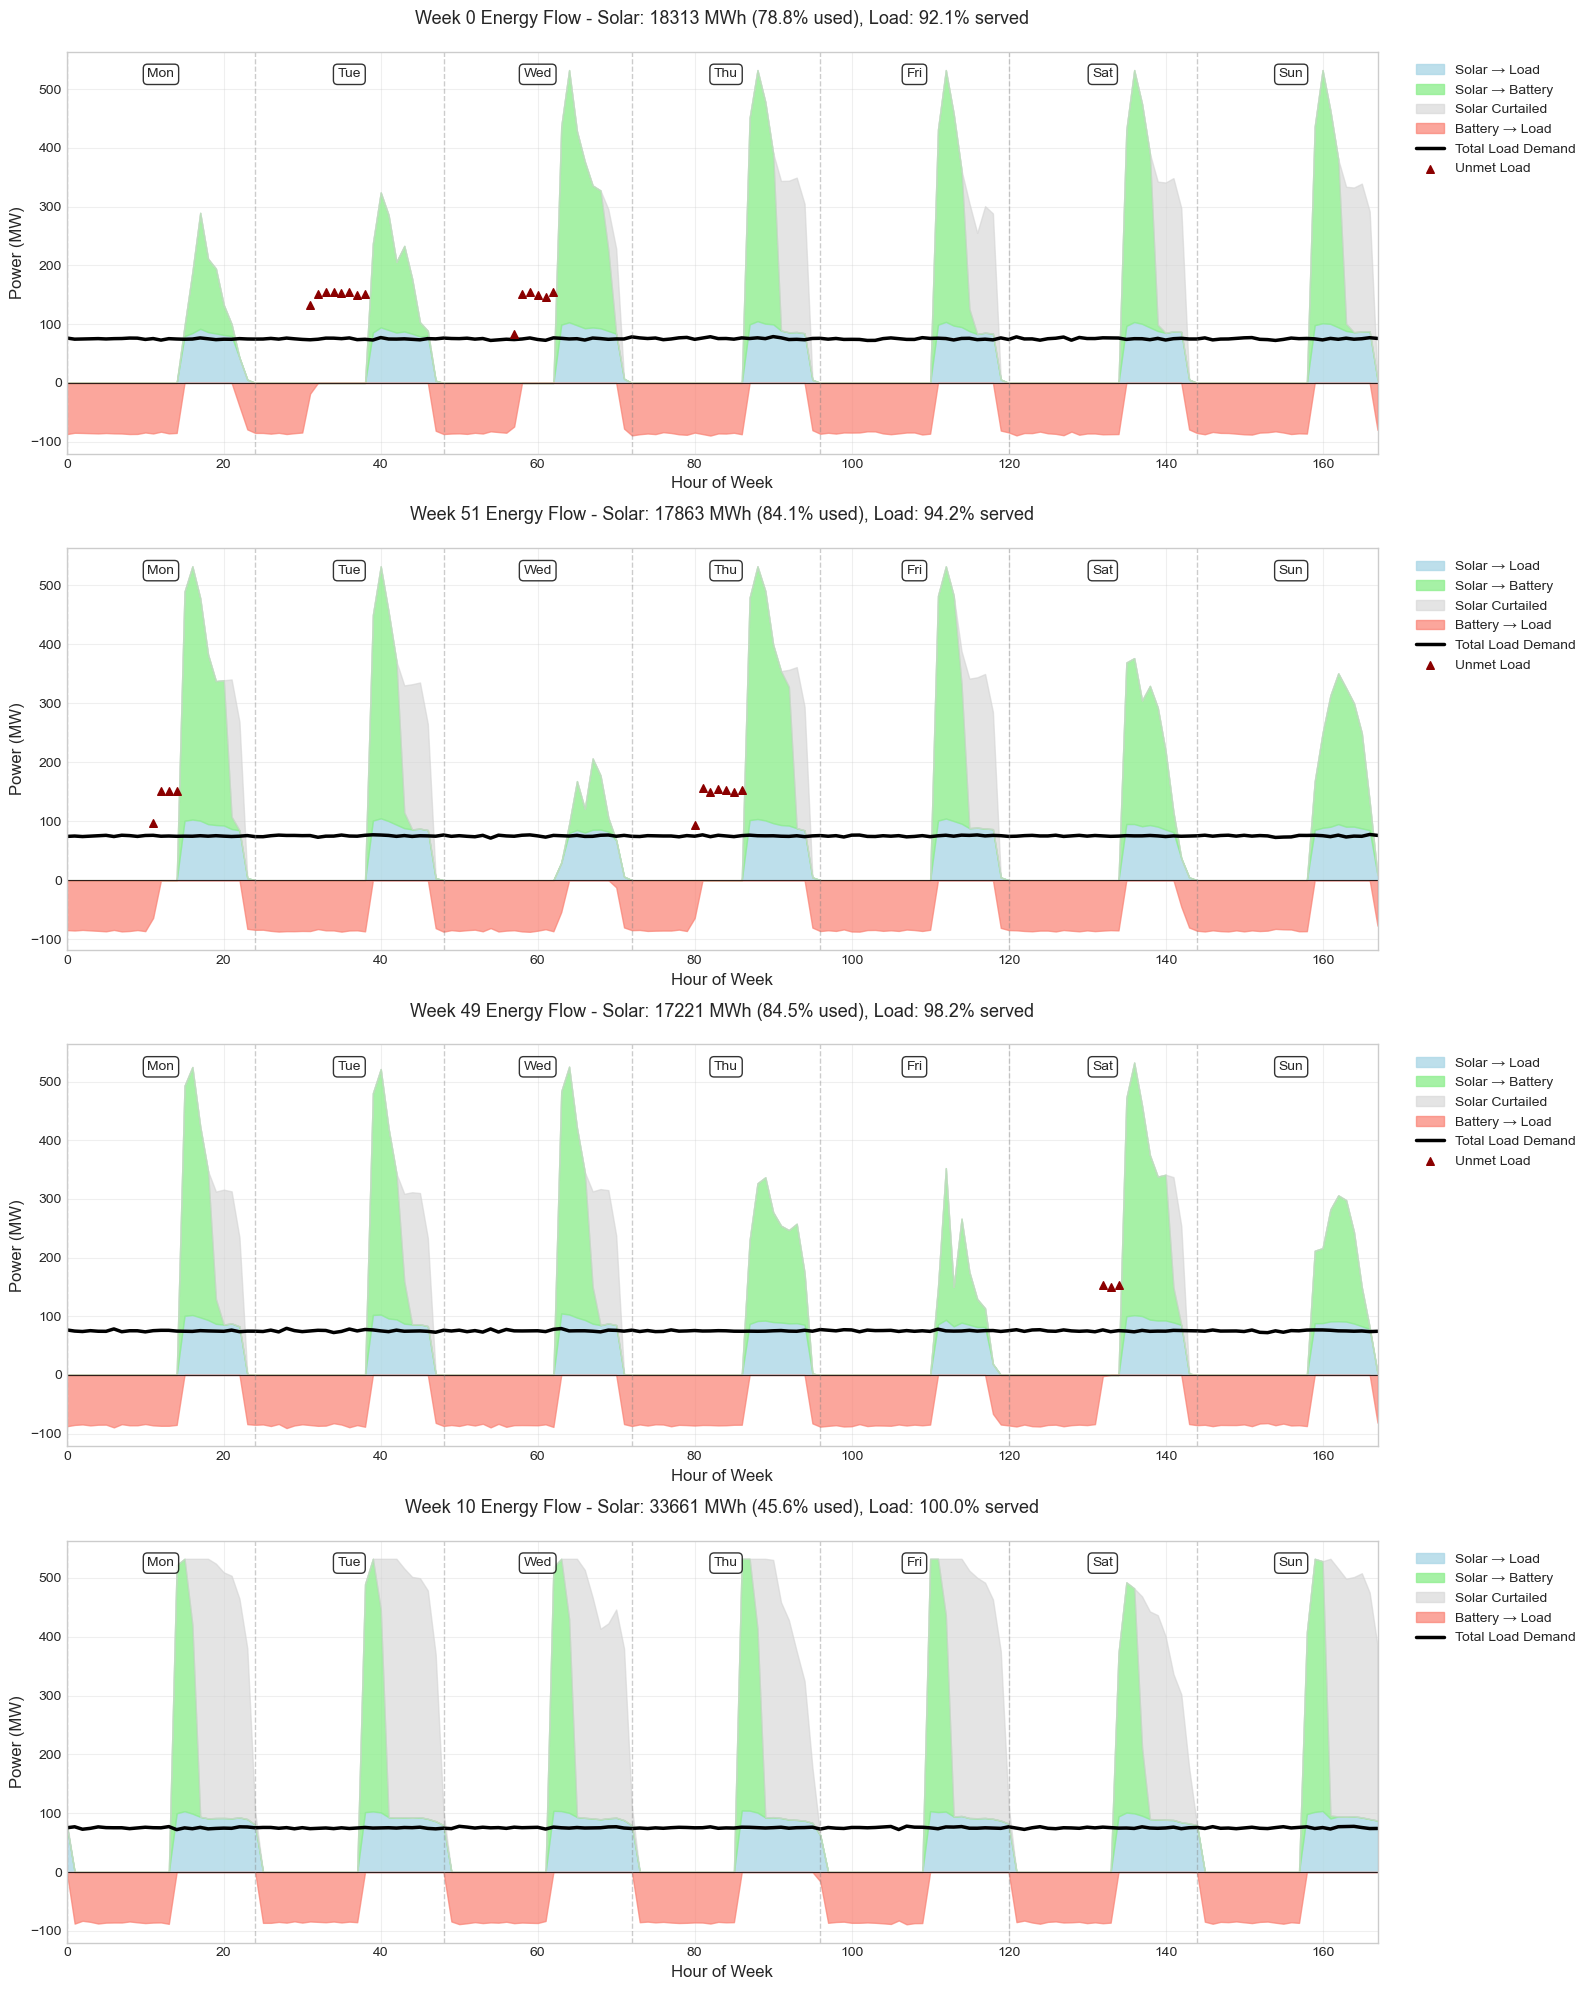


=== ENERGY FLOW SUMMARY ===

Week 0:
  Solar Generated: 18313 MWh
  Load Demand: 12620 MWh
  Solar Utilization: 78.8%
  Load Served: 92.1%
  Battery Cycles: 4.47
  Energy Curtailed: 3889.0 MWh (21.2%)
  Unmet Load: 993.9 MWh (7.9%)

Week 51:
  Solar Generated: 17863 MWh
  Load Demand: 12620 MWh
  Solar Utilization: 84.1%
  Load Served: 94.2%
  Battery Cycles: 4.65
  Energy Curtailed: 2843.6 MWh (15.9%)
  Unmet Load: 733.7 MWh (5.8%)

Week 49:
  Solar Generated: 17221 MWh
  Load Demand: 12633 MWh
  Solar Utilization: 84.5%
  Load Served: 98.2%
  Battery Cycles: 4.95
  Energy Curtailed: 2668.7 MWh (15.5%)
  Unmet Load: 230.4 MWh (1.8%)

Week 10:
  Solar Generated: 33661 MWh
  Load Demand: 12634 MWh
  Solar Utilization: 45.6%
  Load Served: 100.0%
  Battery Cycles: 4.11
  Energy Curtailed: 18317.1 MWh (54.4%)


In [43]:
# =================================================================
#  Energy Flow Analysis (Cell 5 - Restored)
# =================================================================
import matplotlib.pyplot as plt
import numpy as np
from pvstoragesim import SimulationResult

# --- Setup: Define constants and run a Year 0 simulation ---
# This makes the cell self-contained and creates the `sim0` object needed for plotting.
LATITUDE, LONGITUDE = 37.5, -103.5
TOTAL_GPUS = 75000
INITIAL_SOLAR_CAPACITY_MW = 639
INITIAL_BATTERY_POWER_MW = 475
INITIAL_BATTERY_DURATION_HOURS = 4.0
ARCHITECTURE = "dc_coupled"

print("--- Running Year 0 Simulation for Energy Flow Plot ---")
sim0 = evaluate_system(
    latitude=LATITUDE, longitude=LONGITUDE,
    solar_capacity_mw=INITIAL_SOLAR_CAPACITY_MW,
    battery_power_mw=INITIAL_BATTERY_POWER_MW,
    battery_duration_hours=INITIAL_BATTERY_DURATION_HOURS,
    facility_load=FACILITY, architecture=ARCHITECTURE,
    solar_profile=SOLAR_Y0, return_hourly=True
)

def plot_energy_flow_analysis(simulation_result: SimulationResult):
    """
    Create energy flow stacked area chart using a given simulation results object.
    Shows the complete energy story: generation, allocation, and demand.
    """
    if simulation_result.hourly_data is None:
        print("Error: Hourly data not available in the simulation result.")
        return

    hourly_data = simulation_result.hourly_data.copy()
    battery_energy_mwh = INITIAL_BATTERY_POWER_MW * INITIAL_BATTERY_DURATION_HOURS

    # Add a 'week' column for easier grouping
    hourly_data['week'] = hourly_data.index // (24 * 7)

    # Find interesting weeks to plot
    hourly_data['soe_pct'] = (hourly_data['battery_soc_mwh'] / battery_energy_mwh) * 100
    weekly_stats = hourly_data.groupby('week')['soe_pct'].agg(['mean', 'min', 'max', 'std']).round(1)
    highest_std_weeks = weekly_stats.nlargest(3, 'std').index.tolist()

    # Find most typical week
    median_mean = weekly_stats['mean'].median()
    weekly_stats['mean_dist'] = abs(weekly_stats['mean'] - median_mean)
    weekly_stats['composite_distance'] = weekly_stats['mean_dist'] / (weekly_stats['mean_dist'].max() or 1)
    most_typical_week = [weekly_stats['composite_distance'].idxmin()]
    weeks_to_plot = highest_std_weeks + most_typical_week

    print(f"Plotting 3 most volatile weeks: {highest_std_weeks}")
    print(f"Plus most typical week: {most_typical_week}")

    # Create energy flow plots
    n_weeks = len(weeks_to_plot)
    fig, axes = plt.subplots(n_weeks, 1, figsize=(16, 5 * n_weeks), squeeze=False)
    axes = axes.flatten()

    for i, week_num in enumerate(weeks_to_plot):
        week_data = hourly_data[hourly_data['week'] == week_num]
        if week_data.empty: continue

        ax = axes[i]
        hours = np.arange(len(week_data))

        # Get data from simulation results
        solar_generation = week_data['solar_dc_mw'].values
        total_load = week_data['total_load_mw'].values
        battery_charge = week_data['battery_charge_mw'].values
        battery_discharge = week_data['battery_discharge_mw'].values
        curtailed_solar = week_data['curtailed_solar_mw'].values
        unmet_load = week_data['unmet_load_mw'].values

        # Calculate solar allocation
        solar_to_battery = battery_charge * 1.05
        solar_to_load = np.maximum(0, solar_generation - solar_to_battery - curtailed_solar)

        # Create stacked areas
        ax.fill_between(hours, 0, solar_to_load, alpha=0.8, color='lightblue', label='Solar → Load')
        ax.fill_between(hours, solar_to_load, solar_to_load + solar_to_battery, alpha=0.8, color='lightgreen', label='Solar → Battery')
        ax.fill_between(hours, solar_to_load + solar_to_battery, solar_to_load + solar_to_battery + curtailed_solar, alpha=0.6, color='lightgray', label='Solar Curtailed')
        ax.fill_between(hours, 0, -battery_discharge, alpha=0.7, color='salmon', label='Battery → Load')
        ax.plot(hours, total_load, 'black', linewidth=2.5, label='Total Load Demand')

        # Show unmet load
        unmet_mask = unmet_load > 0.01
        if unmet_mask.any():
            ax.scatter(hours[unmet_mask], total_load[unmet_mask] + unmet_load[unmet_mask],
                       color='darkred', s=30, zorder=10, label='Unmet Load', marker='^')

        # Formatting and labels
        ax.set_ylabel('Power (MW)', fontsize=12)
        ax.set_xlabel('Hour of Week', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, len(week_data)-1)
        ax.axhline(y=0, color='black', linewidth=0.8, alpha=0.8)

        # Day markers
        for day in range(8):
            if day * 24 < len(week_data):
                ax.axvline(day * 24, color='gray', alpha=0.4, linestyle='--', linewidth=1)
                if day < 7:
                    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
                    ax.text(day * 24 + 12, ax.get_ylim()[1] * 0.95, day_names[day], ha='center', va='top', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

        # Calculate metrics for title
        total_solar_mwh = np.sum(solar_generation)
        total_load_mwh = np.sum(total_load)
        total_curtailed_mwh = np.sum(curtailed_solar)
        total_unmet_mwh = np.sum(unmet_load)
        solar_utilization = (total_solar_mwh - total_curtailed_mwh) / total_solar_mwh * 100 if total_solar_mwh > 0 else 0
        load_served = (total_load_mwh - total_unmet_mwh) / total_load_mwh * 100 if total_load_mwh > 0 else 0

        title = (f'Week {week_num} Energy Flow - '
                 f'Solar: {total_solar_mwh:.0f} MWh ({solar_utilization:.1f}% used), '
                 f'Load: {load_served:.1f}% served')
        ax.set_title(title, fontsize=13, pad=20)
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print final summary table
    print("\n=== ENERGY FLOW SUMMARY ===")
    for week_num in weeks_to_plot:
        week_data = hourly_data[hourly_data['week'] == week_num]
        if week_data.empty: continue
        solar_mwh = week_data['solar_dc_mw'].sum()
        load_mwh = week_data['total_load_mw'].sum()
        curtailed_mwh = week_data['curtailed_solar_mw'].sum()
        unmet_mwh = week_data['unmet_load_mw'].sum()
        battery_discharged_mwh = week_data['battery_discharge_mw'].sum()

        print(f"\nWeek {week_num}:")
        print(f"  Solar Generated: {solar_mwh:.0f} MWh")
        print(f"  Load Demand: {load_mwh:.0f} MWh")
        print(f"  Solar Utilization: {(solar_mwh - curtailed_mwh) / solar_mwh * 100:.1f}%")
        print(f"  Load Served: {(load_mwh - unmet_mwh) / load_mwh * 100:.1f}%")
        print(f"  Battery Cycles: {battery_discharged_mwh / battery_energy_mwh:.2f}")
        if curtailed_mwh > 0: print(f"  Energy Curtailed: {curtailed_mwh:.1f} MWh ({curtailed_mwh/solar_mwh*100:.1f}%)")
        if unmet_mwh > 0: print(f"  Unmet Load: {unmet_mwh:.1f} MWh ({unmet_mwh/load_mwh*100:.1f}%)")

# Call the restored function
plot_energy_flow_analysis(sim0)

In [ ]:
# import pandas as pd
# from datacenter_analyzer import DatacenterAnalyzer
# from microgrid_optimizer import MicrogridOptimizer, SystemCosts
# from lcoe_calc import calculate_solar_storage_lcoe, SOLAR_COST_Y0, BESS_COST_Y0, SOLAR_BOS_COST_Y0_DC, BATTERY_BOS_COST_Y0_DC

# # Configurationfile:///C:/Users/btuser/AppData/Roaming/jupyterlab-desktop/jlab_server/Lib/site-packages/blast/models/lfp_gr_250AhPrismatic_2019.py#line=136
# locations = {
#     "Phoenix"      : (33.4, -112.0),
#     "Chicago"      : (41.9,  -87.6),
#     "El Paso"      : (31.8, -106.4),
#     "Denver"       : (39.7, -105.0),
#     "Houston"      : (29.8,  -95.3),
#     "Miami"        : (25.8,  -80.2),
#     "New Orleans"  : (29.9,  -90.1),
#     "Fargo"        : (46.9,  -96.8),
#     "San Francisco": (37.8, -122.4),
# }

# # Parameterszzz
# total_gpus = 24000
# required_uptime_pct = 99
# architecture = "dc_coupled"  # or "ac_coupled"

# # Set up costs
# costs = SystemCosts(
#     solar_cost_per_kw=SOLAR_COST_Y0,
#     battery_cost_per_kw=BESS_COST_Y0,
#     solar_bos_cost_per_kw=SOLAR_BOS_COST_Y0_DC,
#     battery_bos_cost_per_kw=BATTERY_BOS_COST_Y0_DC
# )

# # Run analysis
# results = []
# for city, (lat, lon) in locations.items():
#     print(f"Analyzing {city}...")
    
#     try:
#         # Get facility requirements
#         analyzer = DatacenterAnalyzer(latitude=lat, longitude=lon, total_gpus=total_gpus)
#         facility = analyzer.calculate_facility_load(required_uptime_pct=required_uptime_pct)
        
#         # Optimize system
#         optimizer = MicrogridOptimizer(
#             latitude=lat,
#             longitude=lon,
#             facility_load=facility,
#             required_uptime_pct=required_uptime_pct,
#             costs=costs,
#             architecture=architecture
#         )
        
#         min_cost_config = optimizer.optimize_all_objectives()["Minimum Cost"]
        
#         # Calculate LCOE
#         lcoe_result = calculate_solar_storage_lcoe(
#             system_type=architecture,
#             solar_mw=min_cost_config.solar_mw,
#             battery_mw=min_cost_config.battery_mw,
#             battery_mwh=min_cost_config.battery_mwh,
#             land_acres=min_cost_config.land_area_acres,
#             annual_energy_mwh=facility.annual_facility_energy_mwh,
#             required_uptime_pct=required_uptime_pct
#         )
        
#         results.append({
#             'City': city,
#             'Solar_MW': min_cost_config.solar_mw,
#             'Battery_MW': min_cost_config.battery_mw,
#             'LCOE_$/MWh': lcoe_result.lcoe * 1000
#         })
        
#     except Exception as e:
#         print(f"Error analyzing {city}: {e}")

# # Sort by LCOE and display
# df = pd.DataFrame(results).sort_values('LCOE_$/MWh')
# print(f"\nLowest LCOE {architecture} configurations:")
# print(df.to_string(index=False, float_format='%.1f'))

In [12]:
# =================================================================
#  Cell 7 – build geo-diverse training rows for Δq_cal, Δq_cyc 
#  AND stressor evolution patterns (REFACTORED) + C-RATES
# =================================================================
import numpy as np, pandas as pd, time, logging, pickle
from dataclasses import dataclass
from typing import Dict, List
from scipy.stats import qmc
from tqdm.notebook import tqdm
from math import sqrt

from pvstoragesim import evaluate_system
from datacenter_analyzer import DatacenterAnalyzer
from blast import models as blast_models

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# --------------------------- configuration -----------------------
CellModel = blast_models.Lfp_Gr_250AhPrismatic
SITE_CFG: Dict[str, Dict] = {
    "Phoenix": {"coords": (33.4, -112.0), "solar": (200, 400),  "batt_mwh": (400,  800)},
    "Chicago": {"coords": (41.9,  -87.6), "solar": (500, 800),  "batt_mwh": (800, 1400)},
    "El Paso": {"coords": (31.8, -106.4), "solar": (200, 350),  "batt_mwh": (400,  700)},
    "Seattle": {"coords": (47.6, -122.3), "solar": (700,1100),  "batt_mwh": (1800,2800)},
    "Miami":   {"coords": (25.8,  -80.2), "solar": (250, 400),  "batt_mwh": (500,  900)},
    "San Francisco": {"coords": (37.6, -122.5), "solar":  (400, 700), "batt_mwh": (800, 1500)},
    "Northern VA":    {"coords": (38.9,  -77.3), "solar":  (300, 600), "batt_mwh": (700, 1200)}, 
    # 4B  (mixed–dry plateau)
    "Albuquerque": {"coords": (35.1, -106.6),
                    "solar":    (200,  400),
                    "batt_mwh": (400,  800)},

    # 3A  (warm–humid Southeast)
    "Charlotte":   {"coords": (35.2,  -80.8),
                    "solar":    (250,  500),
                    "batt_mwh": (500, 1000)},

    # 2A  (hot–humid Gulf Coast)
    "Houston":     {"coords": (29.8,  -95.4),
                    "solar":    (250,  500),
                    "batt_mwh": (500, 1000)},

    # 5B  (cold–dry inland Northwest / Rockies)
    "Boise":       {"coords": (43.6, -116.2),
                    "solar":    (300,  600),
                    "batt_mwh": (600, 1200)},

    # 6A  (very-cold / humid upper Midwest)
    "Fargo":       {"coords": (46.9,  -96.8),
                    "solar":    (400,  800),
                    "batt_mwh": (800, 1600)},

    # 7   (sub-arctic Lake Superior)
    "Duluth":      {"coords": (46.8,  -92.1),
                    "solar":    (400,  800),
                    "batt_mwh": (800, 1600)},
}
N_SAMPLES_PER_SITE = 4
MAX_YEAR = 13

# --------------------------- thermal model -----------------------
def _thermal_profile(sim, facility, init_T=25, rt_eff=0.90,
                     mth_per_MWh=2.3, T_min=15, T_max=30):
    """Compute hourly battery temperatures based on dispatch"""
    if sim.hourly_data is None or 'battery_soc_mwh' not in sim.hourly_data.columns:
        return np.full(8760, init_T)
    
    hd = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    if cap == 0:
        return np.full(len(hd), init_T)
    
    n = len(hd)
    T = np.empty(n, dtype=float)
    T[0] = init_T
    
    one_way = 1 - sqrt(rt_eff)
    m_th = mth_per_MWh * cap
    pue = np.asarray(facility.hourly_pue)
    
    for h in range(1, n):
        p_ch = abs(hd['battery_charge_mw'].iat[h])
        p_dis = abs(hd['battery_discharge_mw'].iat[h])
        heat_kw = (p_ch + p_dis) * one_way * 1000
        
        pred_T = T[h-1] + heat_kw / m_th
        if pred_T > T_max:
            cool_kw = (pred_T - T_max) * m_th
            elec_kw = cool_kw if pue[h] <= 1 else cool_kw / (pue[h] - 1 + 1e-6)
            net_heat = heat_kw - cool_kw
        elif pred_T < T_min and heat_kw < 1.0:
            heat_kw_aux = (T_min - pred_T) * m_th
            net_heat = heat_kw + heat_kw_aux
        else:
            net_heat = heat_kw
        
        T[h] = T[h-1] + net_heat / m_th
    
    return T

# --------------------------- helpers -----------------------------
@dataclass
class Design:
    site: str
    lat: float
    lon: float
    solar_mw: float
    batt_mw: float
    mean_soc: float = None
    soc_p90: float = None
    efc_int: float = None
    dod_w: float = None
    mean_T: float = None
    c_rate_max: float = None
    c_rate_mean: float = None
    uptime: float = None

def get_solar_capacity_factor(year):
    """Solar panel degradation over time"""
    first_degradation = 0.01
    other_degradation = 0.0055  # 0.55% per year
    if year == 0: 
        return 1.0
    elif year == 1: 
        cap = 1.0 - first_degradation
        return cap
    else:
        cap = 1.0 - first_degradation
        cap *= (1.0 - other_degradation) ** (year - 1)
        return max(0.0, cap)



def derive_metrics(sim, facility):
    """Extract stress features from simulation results including C-rates"""
    sf = sim.stress_features or {}
    hd = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    
    mean_soc = sf.get("mean_soc", 0.5)
    tp = sf.get("throughput_mwh", 0.0)
    efc_int = tp / cap if cap > 0 else 0.0
    soc_p90 = np.percentile(hd['battery_soc_mwh']/cap, 90) if cap > 0 else mean_soc
    
    counts = np.asarray(sf.get("cycle_counts_by_dod", [0]*10))
    efc_dod = np.asarray(sf.get("efc_sum_by_dod", [0]*10))
    if counts.sum():
        dods = efc_dod / (counts + 1e-9)
        dod_w = (np.mean(dods**1.5))**(1/1.5)
    else:
        dod_w = 0.05
    
    T_series = _thermal_profile(sim, facility)
    mean_T = float(np.mean(T_series))
    
    # Calculate C-rates
    if cap > 0:
        # C-rate = Power / Capacity (both charge and discharge)
        charge_power = np.abs(hd['battery_charge_mw'])
        discharge_power = np.abs(hd['battery_discharge_mw'])
        
        # Combined power (charge or discharge at any hour)
        total_power = charge_power + discharge_power
        c_rates = total_power / cap  # C-rate in 1/hr
        
        # Filter out zero power hours for meaningful averages
        active_c_rates = c_rates[c_rates > 0.01]  # Only consider hours with >0.01 C-rate
        
        c_rate_max = float(c_rates.max()) if len(c_rates) > 0 else 0.0
        c_rate_mean = float(active_c_rates.mean()) if len(active_c_rates) > 0 else 0.0
    else:
        c_rate_max = 0.0
        c_rate_mean = 0.0
    
    return dict(
        mean_soc=float(mean_soc), 
        soc_p90=float(soc_p90),
        efc_int=float(efc_int), 
        dod_w=float(dod_w),
        mean_T=mean_T,
        c_rate_max=c_rate_max,
        c_rate_mean=c_rate_mean
    )

def make_stressor(sim, facility):
    """Build stressor dict with actual thermal profile"""
    hd = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    soc = (hd['battery_soc_mwh']/cap).to_numpy()
    temp = _thermal_profile(sim, facility)
    return dict(Time_s=np.arange(len(soc))*3600,
                SOC=soc,
                Temperature_C=temp)

def blast_multi_year(stressor_history, years):
    """Run BLAST on concatenated multi-year stressor and extract per-year fades"""
    # Concatenate all stressors
    time_concat, soc_concat, temp_concat = [], [], []
    for i, s in enumerate(stressor_history):
        offset = i * 365 * 24 * 3600
        time_concat.extend(s['Time_s'] + offset)
        soc_concat.extend(s['SOC'])
        temp_concat.extend(s['Temperature_C'])
    
    multi_year_stressor = {
        'Time_s': np.array(time_concat),
        'SOC': np.array(soc_concat),
        'Temperature_C': np.array(temp_concat)
    }
    
    # Run BLAST on full history
    cell = CellModel()
    cell.simulate_battery_life(multi_year_stressor, 
                               threshold_time=years,
                               is_constant_input=False,
                               is_conserve_energy_throughput=False)
    
    # Extract fade at each year boundary
    t_days = cell.stressors['t_days']
    q_cal = cell.states['qLoss_t']
    q_cyc = cell.states['qLoss_EFC']
    
    year_fades = []
    prev_cal = prev_cyc = 0.0
    
    for yr in range(1, years + 1):
        # Find index closest to year boundary
        idx = int(np.argmin(np.abs(t_days - yr * 365.0)))
        
        # Total fade up to this year
        total_cal = q_cal[idx] * 100
        total_cyc = q_cyc[idx] * 100
        
        # Marginal fade for this year
        marginal_cal = total_cal - prev_cal
        marginal_cyc = total_cyc - prev_cyc
        
        year_fades.append({
            'marginal_cal': marginal_cal,
            'marginal_cyc': marginal_cyc,
            'total_cal': total_cal,
            'total_cyc': total_cyc
        })
        
        prev_cal = total_cal
        prev_cyc = total_cyc
    
    return year_fades

# --------------------------- design grid -------------------------
designs: List[Design] = []
for site, cfg in SITE_CFG.items():
    lhs = qmc.LatinHypercube(2).random(N_SAMPLES_PER_SITE)
    s0, s1 = cfg["solar"]; b0, b1 = cfg["batt_mwh"]
    for r in lhs:
        designs.append(Design(
            site=site, lat=cfg["coords"][0], lon=cfg["coords"][1],
            solar_mw=s0 + r[0]*(s1-s0),
            batt_mw=(b0 + r[1]*(b1-b0))/4.0))

logger.info(f"{len(designs)} raw designs generated")

# ------------- Year-0 sims for filtering ------------------------
for d in tqdm(designs, desc="Year-0 sims"):
    fac = DatacenterAnalyzer(d.lat, d.lon, total_gpus=24_000)\
            .calculate_facility_load()
    sim0 = evaluate_system(d.lat, d.lon, d.solar_mw, d.batt_mw, fac,
                           architecture="dc_coupled", return_hourly=True)
    m = derive_metrics(sim0, fac)
    d.mean_soc, d.efc_int, d.soc_p90, d.dod_w, d.mean_T = \
        m['mean_soc'], m['efc_int'], m['soc_p90'], m['dod_w'], m['mean_T']
    d.c_rate_max, d.c_rate_mean = m['c_rate_max'], m['c_rate_mean']
    d.uptime = sim0.uptime_pct

designs = [d for d in designs if d.uptime >= 90.0]
logger.info(f"{len(designs)} designs pass 99% uptime filter")

# --------------------------- collect BOTH Δq AND evolution -------
degradation_rows = []  # NEW: Single list for all degradation data
evolution_rows = []    # Keep evolution data separate
t0 = time.time()

design_id = 0  # Track each unique design

for d in tqdm(designs, desc=f"Path-dependent Δq + Evolution yrs 1-{MAX_YEAR}"):
    capacity_fraction = 1.0
    stressor_history = []
    design_id += 1
    
    # A. Add cumulative accumulators before the year loop
    cum_efc = 0.0
    cum_dod_w = 0.0
    
    fac = DatacenterAnalyzer(d.lat, d.lon, total_gpus=24_000).calculate_facility_load()
    
    # Calculate solar/battery ratio for this design
    solar_battery_ratio = d.solar_mw / (d.batt_mw * 4)  # Normalize by MWh
    
    # Store Year 0 features for normalization (evolution data)
    year_0_features = None
    
    for year in range(MAX_YEAR):  # 0 to 12
        # Simulate this year with current capacity
        solar_degraded = d.solar_mw * get_solar_capacity_factor(year)
        
        sim = evaluate_system(d.lat, d.lon, solar_degraded, d.batt_mw,
                             fac, architecture="dc_coupled",
                             battery_duration_hours=4.0*capacity_fraction,
                             return_hourly=True)
        
        # Extract features for this year
        feats = derive_metrics(sim, fac)
        
        # Store Year 0 features for evolution tracking
        if year == 0:
            year_0_features = feats.copy()
        
        # Collect evolution data (updated with C-rates)
        evolution_rows.append({
            'design_id': design_id,
            'site': d.site,
            'solar_mw_initial': d.solar_mw,
            'batt_mw_initial': d.batt_mw,
            'solar_battery_ratio': solar_battery_ratio,
            'year': year,
            'capacity_fraction': capacity_fraction,
            'solar_degradation': get_solar_capacity_factor(year),
            # Absolute stressor values
            'mean_soc': feats['mean_soc'],
            'soc_p90': feats['soc_p90'],
            'efc': feats['efc_int'],
            'mean_temp': feats['mean_T'],
            'c_rate_max': feats['c_rate_max'],
            'c_rate_mean': feats['c_rate_mean'],
            # Relative to Year 0 (for modeling evolution)
            'mean_soc_relative': feats['mean_soc'] / year_0_features['mean_soc'] if year_0_features and year_0_features['mean_soc'] > 0 else 1.0,
            'soc_p90_relative': feats['soc_p90'] / year_0_features['soc_p90'] if year_0_features and year_0_features['soc_p90'] > 0 else 1.0,
            'efc_relative': feats['efc_int'] / year_0_features['efc_int'] if year_0_features and year_0_features['efc_int'] > 0 else 1.0,
            'c_rate_max_relative': feats['c_rate_max'] / year_0_features['c_rate_max'] if year_0_features and year_0_features['c_rate_max'] > 0 else 1.0,
            'c_rate_mean_relative': feats['c_rate_mean'] / year_0_features['c_rate_mean'] if year_0_features and year_0_features['c_rate_mean'] > 0 else 1.0,
            'uptime_pct': sim.uptime_pct
        })
        
        # Add this year's stressor to accumulated history
        stressor = make_stressor(sim, fac)
        stressor_history.append(stressor)
        
        # Run BLAST on full accumulated history
        fades = blast_multi_year(stressor_history, len(stressor_history))
        this_year_fade = fades[-1]  # This year's marginal fade
        
        # B. Build one dict row for degradation data (updated with C-rates)
        row = {
            # Design descriptors
            'design_id': design_id,
            'site': d.site,
            'lat': d.lat,
            'lon': d.lon,
            'solar_mw': d.solar_mw,
            'batt_mw': d.batt_mw,
            'solar_batt_ratio': solar_battery_ratio,
            
            # Stressors (instantaneous, annual)
            'mean_soc': feats['mean_soc'],
            'soc_p90': feats['soc_p90'],
            'dod_w': feats['dod_w'],
            'mean_T': feats['mean_T'],
            'efc_annual': feats['efc_int'],  # Annual EFC
            'efc_cum': cum_efc,              # Cumulative EFC *before* update
            'c_rate_max': feats['c_rate_max'],    # Maximum C-rate this year
            'c_rate_mean': feats['c_rate_mean'],  # Average active C-rate this year
            
            # Time tags
            'year': year,           # 0-based
            't_yr': year + 1,       # 1-based for calendar model
            
            # BLAST outputs
            'marginal_cal': this_year_fade['marginal_cal'],
            'marginal_cyc': this_year_fade['marginal_cyc'],
            'total_cal': this_year_fade['total_cal'],
            'total_cyc': this_year_fade['total_cyc']
        }
        
        # Append to degradation data
        degradation_rows.append(row)
        
        # Update cumulative accumulators AFTER recording
        cum_efc += feats['efc_int']
        cum_dod_w += feats['dod_w']  # If you want cumulative DoD_w
        
        # Update capacity for next year's simulation
        total_fade_pct = this_year_fade['marginal_cal'] + this_year_fade['marginal_cyc']
        capacity_fraction *= (1 - total_fade_pct / 100.0)

t1 = time.time()
logger.info(f"Path-dependent collection finished in {t1-t0:.1f}s")

# C. After the loop finish: Create degradation DataFrame
df_deg = pd.DataFrame(degradation_rows)
df_deg.to_parquet("degradation_full.parquet", index=False)

# D. Create the minimal matrices for the two models
X_cal = df_deg[["t_yr", "mean_soc", "mean_T"]].to_numpy()
y_cal = df_deg["marginal_cal"].to_numpy()

X_cyc = df_deg[["efc_cum", "mean_soc", "mean_T"]].to_numpy()
y_cyc = df_deg["marginal_cyc"].to_numpy()

np.save("training_X_cal.npy", X_cal)
np.save("training_y_cal.npy", y_cal)
np.save("training_X_cyc.npy", X_cyc)
np.save("training_y_cyc.npy", y_cyc)

# E. Keep the "stressor evolution" table exactly as it was
evolution_df = pd.DataFrame(evolution_rows)
evolution_df.to_csv("stressor_evolution_data.csv", index=False)

print(f"✓ Saved degradation_full.parquet: {df_deg.shape}")
print(f"✓ Saved calendar X:{X_cal.shape}, y:{y_cal.shape}")
print(f"✓ Saved cycle    X:{X_cyc.shape}, y:{y_cyc.shape}")
print(f"✓ Saved evolution data: {len(evolution_df)} rows across {evolution_df['design_id'].nunique()} designs")
print(f"✓ Training data now uses path-dependent marginal fades AND stressor evolution patterns")

# Optional: Quick preview of degradation data
print(f"\n--- Degradation Data Preview ---")
print(f"Degradation data columns: {list(df_deg.columns)}")
print(f"Calendar features: ['t_yr', 'mean_soc', 'mean_T'] (+ C-rates available)")
print(f"Cycle features: ['efc_cum', 'mean_soc', 'mean_T'] (+ C-rates available)")

# Optional: Quick preview of evolution data
print(f"\n--- Evolution Data Preview ---")
print(f"Sites: {evolution_df['site'].unique()}")
print(f"Years tracked: {sorted(evolution_df['year'].unique())}")
print(f"Evolution data columns: {list(evolution_df.columns)}")

# Quick C-rate statistics
print(f"\n--- C-Rate Statistics ---")
print(f"C-rate max range: {df_deg['c_rate_max'].min():.3f} to {df_deg['c_rate_max'].max():.3f}")
print(f"C-rate mean range: {df_deg['c_rate_mean'].min():.3f} to {df_deg['c_rate_mean'].max():.3f}")

2025-09-17 12:47:41,814 - 52 raw designs generated


Year-0 sims:   0%|          | 0/52 [00:00<?, ?it/s]

2025-09-17 12:57:40,312 - 52 designs pass 99% uptime filter


Path-dependent Δq + Evolution yrs 1-13:   0%|          | 0/52 [00:00<?, ?it/s]

\\?\C:\Users\btuser\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\blast\models\degradation_model.py:537: RuntimeWarning: invalid value encountered in scalar divide
  Crate = np.trapz(abs_instantaneous_crate, t_days[1:]) / delta_t_days
\\?\C:\Users\btuser\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\blast\models\lfp_gr_250AhPrismatic_2019.py:137: RuntimeWarning: invalid value encountered in scalar divide
  kcal = np.trapz(kcal, x=t_secs) / delta_t_secs
\\?\C:\Users\btuser\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\blast\models\lfp_gr_250AhPrismatic_2019.py:138: RuntimeWarning: invalid value encountered in scalar divide
  kcyc = np.trapz(kcyc, x=t_secs) / delta_t_secs
2025-09-17 13:12:49,210 - Path-dependent collection finished in 908.9s


✓ Saved degradation_full.parquet: (676, 21)
✓ Saved calendar X:(676, 3), y:(676,)
✓ Saved cycle    X:(676, 3), y:(676,)
✓ Saved evolution data: 676 rows across 52 designs
✓ Training data now uses path-dependent marginal fades AND stressor evolution patterns

--- Degradation Data Preview ---
Degradation data columns: ['design_id', 'site', 'lat', 'lon', 'solar_mw', 'batt_mw', 'solar_batt_ratio', 'mean_soc', 'soc_p90', 'dod_w', 'mean_T', 'efc_annual', 'efc_cum', 'c_rate_max', 'c_rate_mean', 'year', 't_yr', 'marginal_cal', 'marginal_cyc', 'total_cal', 'total_cyc']
Calendar features: ['t_yr', 'mean_soc', 'mean_T'] (+ C-rates available)
Cycle features: ['efc_cum', 'mean_soc', 'mean_T'] (+ C-rates available)

--- Evolution Data Preview ---
Sites: ['Phoenix' 'Chicago' 'El Paso' 'Seattle' 'Miami' 'San Francisco'
 'Northern VA' 'Albuquerque' 'Charlotte' 'Houston' 'Boise' 'Fargo'
 'Duluth']
Years tracked: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), 

In [3]:
# ================================================================
#  Cell 8 – Kelvin-coefficient scaffold  +  GP residuals  (v1.1)
# ================================================================
import numpy as np, pickle, pandas as pd
from   functools           import partial
from   scipy.optimize      import curve_fit
from   sklearn.model_selection import GroupKFold
from   sklearn.pipeline        import Pipeline
from   sklearn.preprocessing   import StandardScaler
from   sklearn.gaussian_process import GaussianProcessRegressor
from   sklearn.gaussian_process.kernels import Matern, WhiteKernel
from   sklearn.metrics         import mean_absolute_error, r2_score

# -----------------------------------------------------------------
#  Bring the production scaffold, constants, and class
# -----------------------------------------------------------------
from degradation_model import (
    FadeSurrogate,   # class that will be pickled
    cal_scaffold,    # calendar scaffold  (Kelvin-coefficient form)
    cyc_scaffold,    # cycle scaffold     (inverse Arrhenius)
    BETA0, ALPHA0,   # 0.526  and  0.828
    P2_CAL_K, P7_CYC_K     # −5210 K  and  +2190 K
)

print(f"P2_CAL_K = {P2_CAL_K:+.0f} K   (calendar, normal Arrhenius)")
print(f"P7_CYC_K = {P7_CYC_K:+.0f} K   (cycle, inverse Arrhenius)")
print(f"BETA0    = {BETA0:.3f}  ALPHA0 = {ALPHA0:.3f}")

# -----------------------------------------------------------------
# 1.  Load training matrices & group labels
# -----------------------------------------------------------------
X_cal = np.load("training_X_cal.npy")      # (t_yr, mean_SOC, T_mean)
y_cal = np.load("training_y_cal.npy")      # [% per yr]

X_cyc = np.load("training_X_cyc.npy")      # (EFC_cum, mean_SOC, T_mean)
y_cyc = np.load("training_y_cyc.npy")      # [% per yr]

groups = pd.read_parquet("degradation_full.parquet")["design_id"].to_numpy()

print("calendar  X:", X_cal.shape, "  y:", y_cal.shape)
print("cycle     X:", X_cyc.shape, "  y:", y_cyc.shape)

# -----------------------------------------------------------------
# 2.  Fit scaffold scale factors & exponent tweaks
# -----------------------------------------------------------------
BETA_WID  = 0.25      # allow β  ±0.25 around BLAST reference
ALPHA_WID = 0.25      # allow α  ±0.25 around BLAST reference

print("\nFitting calendar scaffold …")
p0_cal  = (0.5, 0.0, 0.0)                       # A, β-shift, γ
bnd_cal = ([1e-2, -BETA_WID, 0.0],
           [10.0,  BETA_WID, 6.0])              # γ upper widened → 6

p_cal , _ = curve_fit(cal_scaffold, X_cal, y_cal,
                      p0=p0_cal, bounds=bnd_cal, maxfev=6000)

β_fit = BETA0 + p_cal[1]
print(f"  →  A={p_cal[0]:.4g}   β={β_fit:.3f}   γ={p_cal[2]:.3f}")

print("Fitting cycle scaffold …")
p0_cyc  = (5e-6, 0.0)                 # start B near data scale
bnd_cyc = ([1e-7 , -ALPHA_WID],       # allow B to shrink to 1×10⁻7
           [1.0  ,  ALPHA_WID])       # upper bound unchanged

p_cyc , _ = curve_fit(cyc_scaffold, X_cyc, y_cyc,
                      p0=p0_cyc, bounds=bnd_cyc, maxfev=6000)

α_fit = ALPHA0 + p_cyc[1]
print(f"  →  B={p_cyc[0]:.4g}   α={α_fit:.3f}")

# -----------------------------------------------------------------
# 3.  Residuals → Gaussian Process (group-aware CV)
# -----------------------------------------------------------------
res_cal = y_cal - cal_scaffold(X_cal, *p_cal)
res_cyc = y_cyc - cyc_scaffold(X_cyc, *p_cyc)

def fit_gp_residual(X, r, tag):
    kernel = (Matern(length_scale=np.ones(X.shape[1]), nu=2.5)
              + WhiteKernel(noise_level=1e-3,
                            noise_level_bounds=(1e-5, 1e-1)))

    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("gp",    GaussianProcessRegressor(kernel     = kernel,
                                           normalize_y=True,
                                           random_state=42,
                                           n_restarts_optimizer=6))
    ])

    cv  = GroupKFold(5)
    oof = np.empty_like(r)
    for tr, va in cv.split(X, r, groups):
        pipe.fit(X[tr], r[tr])
        oof[va] = pipe.predict(X[va])

    print(f"{tag}  GP  OOF-MAE {mean_absolute_error(r,oof):.4f}   "
          f"R² {r2_score(r,oof):.3f}")

    pipe.fit(X, r)             # final refit on all data
    return pipe

gp_cal = fit_gp_residual(X_cal, res_cal, "Calendar")
gp_cyc = fit_gp_residual(X_cyc, res_cyc, "Cycle")

# -----------------------------------------------------------------
# 4.  Bundle surrogate & save
# -----------------------------------------------------------------
fade_model = FadeSurrogate(p_cal, p_cyc, gp_cal, gp_cyc)

with open("output_tables/fade_surrogate.pkl", "wb") as f:
    pickle.dump(fade_model, f)

print("✓  Saved Kelvin-coef surrogate  →  output_tables/fade_surrogate.pkl")

P2_CAL_K = -5210 K   (calendar, normal Arrhenius)
P7_CYC_K = +2190 K   (cycle, inverse Arrhenius)
BETA0    = 0.526  ALPHA0 = 0.828
calendar  X: (676, 3)   y: (676,)
cycle     X: (676, 3)   y: (676,)

Fitting calendar scaffold …
  →  A=10   β=0.776   γ=6.000
Fitting cycle scaffold …
  →  B=3.734e-06   α=0.578
Calendar  GP  OOF-MAE 0.0016   R² 1.000
Cycle  GP  OOF-MAE 0.0097   R² 0.994
✓  Saved Kelvin-coef surrogate  →  output_tables/fade_surrogate.pkl


BLIND DESIGN VALIDATION OF FADE SURROGATE
Generated 10 blind validation designs


Filtering blind designs: 100%|██████████| 10/10 [01:58<00:00, 11.84s/it]


10 designs pass 99% uptime filter


Running BLAST validation: 100%|██████████| 10/10 [03:07<00:00, 18.72s/it]
C:\Users\btuser\AppData\Local\Temp\ipykernel_49464\2947128741.py:303: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_stats = df_val_BLAST.groupby("design_id").apply(summary)


Collected 130 validation data points
Running surrogate predictions...

VALIDATION SUMMARY BY DESIGN
           MAE_per_year  RMSE_per_year  WorstCumCapErr@Y13
design_id                                                 
1                 0.004          0.004               0.043
2                 0.004          0.004               0.052
3                 0.001          0.002               0.009
4                 0.004          0.004               0.046
5                 0.007          0.007               0.089
6                 0.001          0.002               0.007
7                 0.004          0.006               0.007
8                 0.016          0.021               0.204
9                 0.015          0.016               0.199
10                0.014          0.014               0.184

OVERALL METRICS:
MAE per year: 0.0069%
RMSE per year: 0.0101%


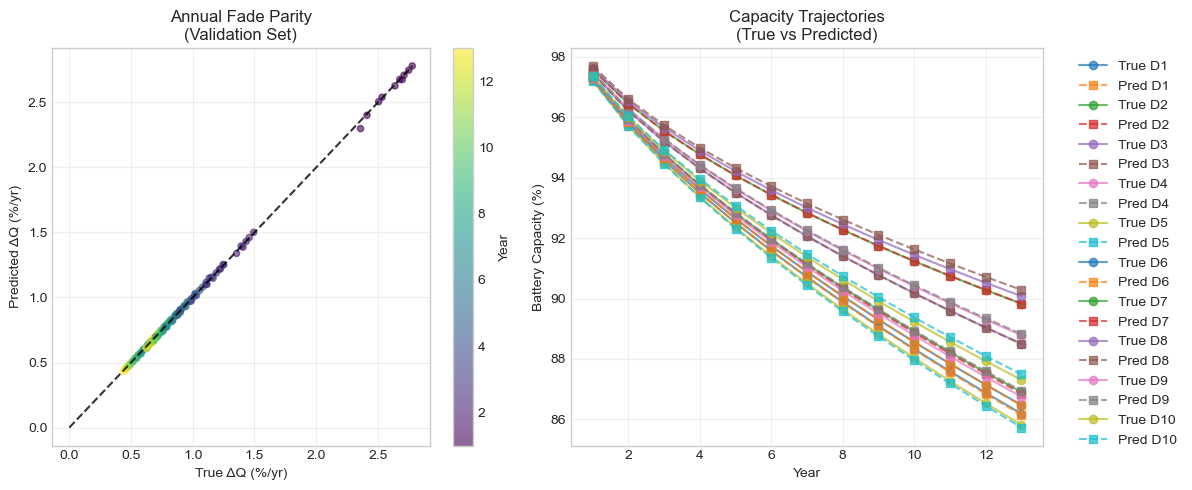


✓ Blind validation complete!
✓ Data saved in df_val_BLAST with 130 rows


In [9]:
# =================================================================
#  Cell 9 – Blind Design Validation of Fade Surrogate
# =================================================================
import numpy as np, pandas as pd, pickle, matplotlib.pyplot as plt
from tqdm import tqdm  # Instead of tqdm.auto
from scipy.stats import qmc
import time

# Import your simulation modules
from pvstoragesim import evaluate_system
from datacenter_analyzer import DatacenterAnalyzer
from blast import models as blast_models

# ────────────────────────────────────────────────────────────────
# STEP 0 – imports & helper
# ────────────────────────────────────────────────────────────────

# Load the surrogate model
with open("output_tables/fade_surrogate.pkl", "rb") as f:
    fade = pickle.load(f)

CellModel = blast_models.Lfp_Gr_250AhPrismatic

# Solar-panel degradation
def get_solar_capacity_factor(year, first=0.01, annual=0.0055):
    if year == 0: return 1.0
    cap = 1.0 - first
    if year > 1:
        cap *= (1.0 - annual) ** (year-1)
    return cap

def _thermal_profile(sim, facility, init_T=25, rt_eff=0.90,
                     mth_per_MWh=2.3, T_min=15, T_max=30):
    """Compute hourly battery temperatures based on dispatch"""
    if sim.hourly_data is None or 'battery_soc_mwh' not in sim.hourly_data.columns:
        return np.full(8760, init_T)
    
    hd = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    if cap == 0:
        return np.full(len(hd), init_T)
    
    n = len(hd)
    T = np.empty(n, dtype=float)
    T[0] = init_T
    
    from math import sqrt
    one_way = 1 - sqrt(rt_eff)
    m_th = mth_per_MWh * cap
    pue = np.asarray(facility.hourly_pue)
    
    for h in range(1, n):
        p_ch = abs(hd['battery_charge_mw'].iat[h])
        p_dis = abs(hd['battery_discharge_mw'].iat[h])
        heat_kw = (p_ch + p_dis) * one_way * 1000
        
        pred_T = T[h-1] + heat_kw / m_th
        if pred_T > T_max:
            cool_kw = (pred_T - T_max) * m_th
            elec_kw = cool_kw if pue[h] <= 1 else cool_kw / (pue[h] - 1 + 1e-6)
            net_heat = heat_kw - cool_kw
        elif pred_T < T_min and heat_kw < 1.0:
            heat_kw_aux = (T_min - pred_T) * m_th
            net_heat = heat_kw + heat_kw_aux
        else:
            net_heat = heat_kw
        
        T[h] = T[h-1] + net_heat / m_th
    
    return T

def derive_metrics(sim, facility):
    """Extract stress features from simulation results"""
    sf = sim.stress_features or {}
    hd = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    
    mean_soc = sf.get("mean_soc", 0.5)
    tp = sf.get("throughput_mwh", 0.0)
    efc_int = tp / cap if cap > 0 else 0.0
    soc_p90 = np.percentile(hd['battery_soc_mwh']/cap, 90) if cap > 0 else mean_soc
    
    counts = np.asarray(sf.get("cycle_counts_by_dod", [0]*10))
    efc_dod = np.asarray(sf.get("efc_sum_by_dod", [0]*10))
    if counts.sum():
        dods = efc_dod / (counts + 1e-9)
        dod_w = (np.mean(dods**1.5))**(1/1.5)
    else:
        dod_w = 0.05
    
    T_series = _thermal_profile(sim, facility)
    mean_T = float(np.mean(T_series))
    
    return dict(mean_soc=float(mean_soc), soc_p90=float(soc_p90),
                efc_int=float(efc_int), dod_w=float(dod_w),
                mean_T=mean_T)

def make_stressor(sim, facility):
    """Build stressor dict with actual thermal profile"""
    hd = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    soc = (hd['battery_soc_mwh']/cap).to_numpy()
    temp = _thermal_profile(sim, facility)
    return dict(Time_s=np.arange(len(soc))*3600,
                SOC=soc,
                Temperature_C=temp)

def blast_multi_year(stressor_history, years):
    """Run BLAST on concatenated multi-year stressor and extract per-year fades"""
    # Concatenate all stressors
    time_concat, soc_concat, temp_concat = [], [], []
    for i, s in enumerate(stressor_history):
        offset = i * 365 * 24 * 3600
        time_concat.extend(s['Time_s'] + offset)
        soc_concat.extend(s['SOC'])
        temp_concat.extend(s['Temperature_C'])
    
    multi_year_stressor = {
        'Time_s': np.array(time_concat),
        'SOC': np.array(soc_concat),
        'Temperature_C': np.array(temp_concat)
    }
    
    # Run BLAST on full history
    cell = CellModel()
    cell.simulate_battery_life(multi_year_stressor, 
                               threshold_time=years,
                               is_constant_input=False,
                               is_conserve_energy_throughput=False)
    
    # Extract fade at each year boundary
    t_days = cell.stressors['t_days']
    q_cal = cell.states['qLoss_t']
    q_cyc = cell.states['qLoss_EFC']
    
    year_fades = []
    prev_cal = prev_cyc = 0.0
    
    for yr in range(1, years + 1):
        # Find index closest to year boundary
        idx = int(np.argmin(np.abs(t_days - yr * 365.0)))
        
        # Total fade up to this year
        total_cal = q_cal[idx] * 100
        total_cyc = q_cyc[idx] * 100
        
        # Marginal fade for this year
        marginal_cal = total_cal - prev_cal
        marginal_cyc = total_cyc - prev_cyc
        
        year_fades.append({
            'marginal_cal': marginal_cal,
            'marginal_cyc': marginal_cyc,
            'total_cal': total_cal,
            'total_cyc': total_cyc
        })
        
        prev_cal = total_cal
        prev_cyc = total_cyc
    
    return year_fades

# ────────────────────────────────────────────────────────────────
# STEP 1 – blind-design / leave-out validation
# ────────────────────────────────────────────────────────────────

print("="*70)
print("BLIND DESIGN VALIDATION OF FADE SURROGATE")
print("="*70)

# Use same site configuration but NEW random seed for blind designs
SITE_CFG = {
    "Phoenix": {"coords": (33.4, -112.0), "solar": (200, 400),  "batt_mwh": (400,  800)},
    "Chicago": {"coords": (41.9,  -87.6), "solar": (500, 800),  "batt_mwh": (800, 1400)},
    "El Paso": {"coords": (31.8, -106.4), "solar": (200, 350),  "batt_mwh": (400,  700)},
    "Seattle": {"coords": (47.6, -122.3), "solar": (700,1100),  "batt_mwh": (1800,2800)},
    "Miami":   {"coords": (25.8,  -80.2), "solar": (250, 400),  "batt_mwh": (500,  900)},
}

N_BLIND_DESIGNS = 2  # Keep small for validation
MAX_YEAR_VAL = 13    # Shorter for faster validation

# Generate blind designs with different random seed
np.random.seed(555)  # Different from training seed
blind_designs = []

for site, cfg in SITE_CFG.items():
    lhs = qmc.LatinHypercube(2, seed=999).random(N_BLIND_DESIGNS)
    s0, s1 = cfg["solar"]; b0, b1 = cfg["batt_mwh"]
    for r in lhs:
        blind_designs.append({
            'site': site,
            'lat': cfg["coords"][0], 
            'lon': cfg["coords"][1],
            'solar_mw': s0 + r[0]*(s1-s0),
            'batt_mw': (b0 + r[1]*(b1-b0))/4.0
        })

print(f"Generated {len(blind_designs)} blind validation designs")

# Filter for 99% uptime
filtered_designs = []
for d in tqdm(blind_designs, desc="Filtering blind designs"):
    fac = DatacenterAnalyzer(d['lat'], d['lon'], total_gpus=24_000).calculate_facility_load()
    sim0 = evaluate_system(d['lat'], d['lon'], d['solar_mw'], d['batt_mw'], fac,
                           architecture="dc_coupled", return_hourly=True)
    if sim0.uptime_pct >= 90.0:
        filtered_designs.append(d)

print(f"{len(filtered_designs)} designs pass 99% uptime filter")

# Run full BLAST validation on filtered designs
val_rows = []
design_id = 0

for d in tqdm(filtered_designs, desc="Running BLAST validation"):
    design_id += 1
    capacity_fraction = 1.0
    stressor_history = []
    cum_efc = 0.0
    
    fac = DatacenterAnalyzer(d['lat'], d['lon'], total_gpus=24_000).calculate_facility_load()
    
    for year in range(MAX_YEAR_VAL):
        # Simulate this year with current capacity
        solar_degraded = d['solar_mw'] * get_solar_capacity_factor(year)
        
        sim = evaluate_system(d['lat'], d['lon'], solar_degraded, d['batt_mw'],
                             fac, architecture="dc_coupled",
                             battery_duration_hours=4.0*capacity_fraction,
                             return_hourly=True)
        
        # Extract features for this year
        feats = derive_metrics(sim, fac)
        
        # Add this year's stressor to accumulated history
        stressor = make_stressor(sim, fac)
        stressor_history.append(stressor)
        
        # Run BLAST on full accumulated history
        fades = blast_multi_year(stressor_history, len(stressor_history))
        this_year_fade = fades[-1]  # This year's marginal fade
        
        # Store validation row
        val_rows.append({
            'design_id': design_id,
            'site': d['site'],
            'year': year,
            't_yr': year + 1,
            'SOC_mean': feats['mean_soc'],
            'T_mean': feats['mean_T'],
            'EFC_cum': cum_efc,
            'cal_true': this_year_fade['marginal_cal'],
            'cyc_true': this_year_fade['marginal_cyc']
        })
        
        # Update accumulators
        cum_efc += feats['efc_int']
        total_fade_pct = this_year_fade['marginal_cal'] + this_year_fade['marginal_cyc']
        capacity_fraction *= (1 - total_fade_pct / 100.0)

# Create validation DataFrame
df_val_BLAST = pd.DataFrame(val_rows)
print(f"Collected {len(df_val_BLAST)} validation data points")

# Run surrogate predictions
Xcal = df_val_BLAST[["t_yr", "SOC_mean", "T_mean"]].to_numpy()
Xcyc = df_val_BLAST[["EFC_cum", "SOC_mean", "T_mean"]].to_numpy()

print("Running surrogate predictions...")
cal_pred, cyc_pred = fade(Xcal, Xcyc)

df_val_BLAST["cal_pred"] = cal_pred
df_val_BLAST["cyc_pred"] = cyc_pred

# Aggregate predictions
df_val_BLAST["fade_true"] = df_val_BLAST["cal_true"] + df_val_BLAST["cyc_true"]
df_val_BLAST["fade_pred"] = df_val_BLAST["cal_pred"] + df_val_BLAST["cyc_pred"]

# Cumulative capacity trajectory
df_val_BLAST["cap_true"] = 100 - df_val_BLAST.groupby("design_id")["fade_true"].cumsum()
df_val_BLAST["cap_pred"] = 100 - df_val_BLAST.groupby("design_id")["fade_pred"].cumsum()

# Metrics and analysis
def summary(df):
    d = {}
    d["MAE_per_year"] = np.mean(np.abs(df["fade_pred"] - df["fade_true"]))
    d["RMSE_per_year"] = np.sqrt(np.mean((df["fade_pred"] - df["fade_true"])**2))
    
    # Find worst cumulative capacity error at final year
    final_year = df["t_yr"].max()
    final_df = df.loc[df["t_yr"] == final_year]
    if len(final_df) > 0:
        d[f"WorstCumCapErr@Y{final_year}"] = np.abs(final_df["cap_pred"] - final_df["cap_true"]).max()
    else:
        d[f"WorstCumCapErr@Y{final_year}"] = np.nan
    
    return pd.Series(d)

print("\n" + "="*50)
print("VALIDATION SUMMARY BY DESIGN")
print("="*50)
summary_stats = df_val_BLAST.groupby("design_id").apply(summary)
print(summary_stats)

print(f"\nOVERALL METRICS:")
print(f"MAE per year: {np.mean(np.abs(df_val_BLAST['fade_pred'] - df_val_BLAST['fade_true'])):.4f}%")
print(f"RMSE per year: {np.sqrt(np.mean((df_val_BLAST['fade_pred'] - df_val_BLAST['fade_true'])**2)):.4f}%")

# Parity plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Annual fade parity
ax1 = axes[0]
scatter = ax1.scatter(df_val_BLAST["fade_true"], df_val_BLAST["fade_pred"], 
                     s=20, alpha=0.6, c=df_val_BLAST["t_yr"], cmap='viridis')
lims = [0, df_val_BLAST[["fade_true", "fade_pred"]].values.max()]
ax1.plot(lims, lims, 'k--', alpha=0.8)
ax1.set_xlabel("True ΔQ (%/yr)")
ax1.set_ylabel("Predicted ΔQ (%/yr)")
ax1.set_title("Annual Fade Parity\n(Validation Set)")
ax1.grid(alpha=0.3)
cbar1 = plt.colorbar(scatter, ax=ax1)
cbar1.set_label('Year')

# Capacity trajectory comparison
ax2 = axes[1]
for design_id in df_val_BLAST["design_id"].unique():
    subset = df_val_BLAST[df_val_BLAST["design_id"] == design_id]
    ax2.plot(subset["t_yr"], subset["cap_true"], 'o-', label=f'True D{design_id}', alpha=0.7)
    ax2.plot(subset["t_yr"], subset["cap_pred"], 's--', label=f'Pred D{design_id}', alpha=0.7)

ax2.set_xlabel("Year")
ax2.set_ylabel("Battery Capacity (%)")
ax2.set_title("Capacity Trajectories\n(True vs Predicted)")
ax2.grid(alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

print(f"\n✓ Blind validation complete!")
print(f"✓ Data saved in df_val_BLAST with {len(df_val_BLAST)} rows")

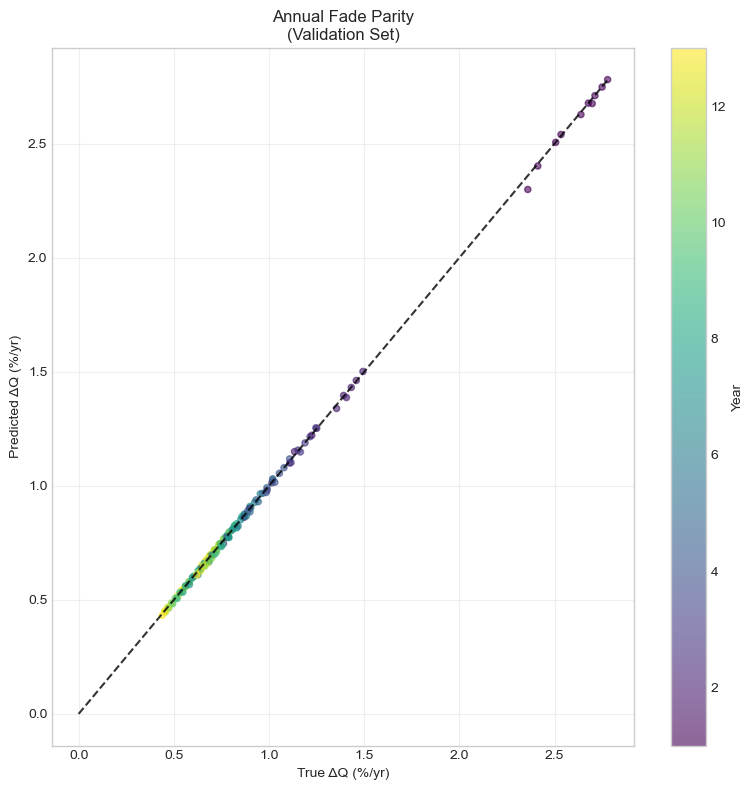

In [10]:
# Create a standalone version of the annual fade parity plot
plt.figure(figsize=(8, 8))

# Recreate the scatter plot
scatter = plt.scatter(df_val_BLAST["fade_true"], df_val_BLAST["fade_pred"], 
                     s=20, alpha=0.6, c=df_val_BLAST["t_yr"], cmap='viridis')

# Add the parity line
lims = [0, df_val_BLAST[["fade_true", "fade_pred"]].values.max()]
plt.plot(lims, lims, 'k--', alpha=0.8)

# Labels and title
plt.xlabel("True ΔQ (%/yr)")
plt.ylabel("Predicted ΔQ (%/yr)")
plt.title("Annual Fade Parity\n(Validation Set)")
plt.grid(alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Year')

# Save the plot
plt.savefig('validation_fade_parity.png', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

OUT-OF-SAMPLE LOCATION VALIDATION
Testing 9 designs (one per location) across 13 years


Validating designs:   0%|          | 0/9 [00:00<?, ?it/s]


VALIDATION RESULTS SUMMARY
Annual Fade MAE:  0.0146%
Annual Fade RMSE: 0.0195%

Final SOH (after 13 years):
Mean SOH Error:   0.033 percentage points
Max |SOH Error|:  0.407 percentage points

13-Year SOH Results by Location:


,site,solar_mw,batt_mw,soh_true_final,soh_surr_final,soh_error_pp
0,Denver,322.131,246.532,88.920,89.010,0.090
1,Boston,249.629,348.909,90.103,90.082,-0.021
2,Austin,868.203,652.548,90.235,89.868,-0.367
3,SaltLake,781.591,549.523,90.108,90.011,-0.097
4,Portland OR,415.364,468.619,90.519,90.574,0.055
5,LasVegas,274.699,101.796,85.618,86.024,0.407
6,Minneapolis,671.691,273.171,89.171,89.277,0.106
7,NewYork,991.101,457.208,89.888,89.883,-0.005
8,Atlanta,745.423,408.967,89.778,89.906,0.128


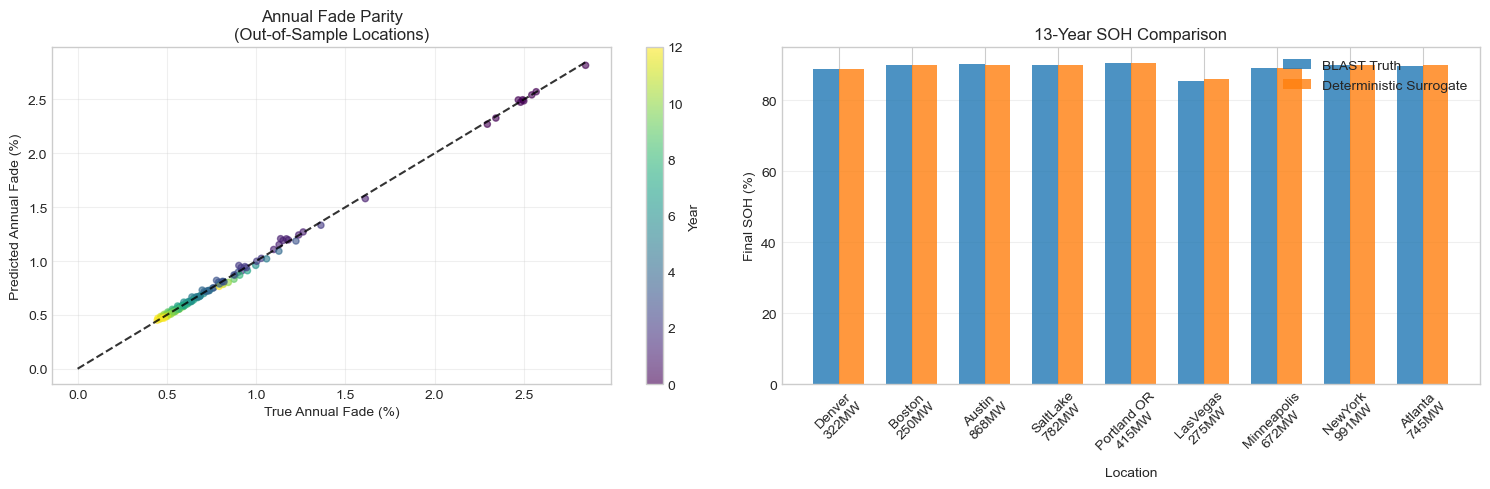


✓ Out-of-sample validation complete!
✓ Validation data: 117 rows
✓ Summary results: 9 locations tested


In [2]:
# =================================================================
#  Cell 10 – Out-of-Sample Location Validation (Deterministic Stressors)
#  (UPDATED FOR DETERMINISTIC STRESSOR EVOLUTION)
# =================================================================
import numpy as np, pandas as pd, pickle, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datacenter_analyzer import DatacenterAnalyzer
from blast import models as blast_models
from math import sqrt

from pvstoragesim import evaluate_system

CellModel = blast_models.Lfp_Gr_250AhPrismatic
MAX_YEAR  = 13

# ------------------ 1.  Load unified surrogate ------------------
with open("output_tables/fade_surrogate.pkl", "rb") as f:
    fade = pickle.load(f)

# ------------------ 2.  Helper functions ------------------------
def get_solar_capacity_factor(year, first=0.01, annual=0.0055):
    """Solar panel degradation over time"""
    if year == 0: return 1.0
    cap = 1.0 - first
    if year > 1:
        cap *= (1.0 - annual) ** (year-1)
    return cap

def thermal_profile(sim, facility, init_T=25, rt_eff=0.90,
                   mth_per_MWh=2.3, T_min=15, T_max=30):
    """Compute hourly battery temperatures based on dispatch"""
    if sim.hourly_data is None or 'battery_soc_mwh' not in sim.hourly_data.columns:
        return np.full(8760, init_T)
    
    hd = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    if cap == 0:
        return np.full(len(hd), init_T)
    
    n = len(hd)
    T = np.empty(n, dtype=float)
    T[0] = init_T
    
    one_way = 1 - sqrt(rt_eff)
    m_th = mth_per_MWh * cap
    pue = np.asarray(facility.hourly_pue)
    
    for h in range(1, n):
        p_ch = abs(hd['battery_charge_mw'].iat[h])
        p_dis = abs(hd['battery_discharge_mw'].iat[h])
        heat_kw = (p_ch + p_dis) * one_way * 1000
        
        pred_T = T[h-1] + heat_kw / m_th
        if pred_T > T_max:
            cool_kw = (pred_T - T_max) * m_th
            elec_kw = cool_kw if pue[h] <= 1 else cool_kw / (pue[h] - 1 + 1e-6)
            net_heat = heat_kw - cool_kw
        elif pred_T < T_min and heat_kw < 1.0:
            heat_kw_aux = (T_min - pred_T) * m_th
            net_heat = heat_kw + heat_kw_aux
        else:
            net_heat = heat_kw
        
        T[h] = T[h-1] + net_heat / m_th
    
    return T

def make_stressor(sim, facility):
    """Build stressor dict with actual thermal profile"""
    hd = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    soc = (hd['battery_soc_mwh']/cap).to_numpy()
    temp = thermal_profile(sim, facility)
    return dict(Time_s=np.arange(len(soc))*3600,
                SOC=soc,
                Temperature_C=temp)

def blast_multi_year(stressor_history, years):
    """Run BLAST on concatenated multi-year stressor and extract per-year fades"""
    # Concatenate all stressors
    time_concat, soc_concat, temp_concat = [], [], []
    for i, s in enumerate(stressor_history):
        offset = i * 365 * 24 * 3600
        time_concat.extend(s['Time_s'] + offset)
        soc_concat.extend(s['SOC'])
        temp_concat.extend(s['Temperature_C'])
    
    multi_year_stressor = {
        'Time_s': np.array(time_concat),
        'SOC': np.array(soc_concat),
        'Temperature_C': np.array(temp_concat)
    }
    
    # Run BLAST on full history
    cell = CellModel()
    cell.simulate_battery_life(multi_year_stressor, 
                               threshold_time=years,
                               is_constant_input=False,
                               is_conserve_energy_throughput=False)
    
    # Extract fade at each year boundary
    t_days = cell.stressors['t_days']
    q_cal = cell.states['qLoss_t']
    q_cyc = cell.states['qLoss_EFC']
    
    year_fades = []
    prev_cal = prev_cyc = 0.0
    
    for yr in range(1, years + 1):
        # Find index closest to year boundary
        idx = int(np.argmin(np.abs(t_days - yr * 365.0)))
        
        # Total fade up to this year
        total_cal = q_cal[idx] * 100
        total_cyc = q_cyc[idx] * 100
        
        # Marginal fade for this year
        marginal_cal = total_cal - prev_cal
        marginal_cyc = total_cyc - prev_cyc
        
        year_fades.append({
            'marginal_cal': marginal_cal,
            'marginal_cyc': marginal_cyc,
            'total_cal': total_cal,
            'total_cyc': total_cyc
        })
        
        prev_cal = total_cal
        prev_cyc = total_cyc
    
    return year_fades

# ------------------ 3.  Out-of-sample test sites ----------------
NEW_SITES = {                         #  lat , lon
    "Denver"      : (39.7 , -104.9),
    "Boston"      : (42.4 ,  -71.1),
    "Austin"      : (30.3 ,  -97.7),
    "SaltLake"    : (40.8 , -111.9),
    "Portland OR" : (45.5 , -122.7),
    "LasVegas"    : (36.2 , -115.1),
    "Minneapolis" : (44.9 ,  -93.3),
    "NewYork"     : (40.8 ,  -74.0),
    "Atlanta"     : (33.7 ,  -84.4)
}
SOLAR_MIN, SOLAR_MAX = 200, 1000   # MW
BATT_P_MIN, BATT_P_MAX = 50, 700   # MW  (×4 h)

# Generate test designs - one per location
site_names = list(NEW_SITES.keys())
designs = []


for name in site_names:
    lat, lon = NEW_SITES[name]
    # Random solar and battery sizing for each location
    solar = np.random.uniform(SOLAR_MIN, SOLAR_MAX)
    batt = np.random.uniform(BATT_P_MIN, BATT_P_MAX)
    designs.append((name, lat, lon, solar, batt))

print("="*70)
print("OUT-OF-SAMPLE LOCATION VALIDATION")
print("="*70)
print(f"Testing {len(designs)} designs (one per location) across {MAX_YEAR} years")

# ------------------ 4.  Loop over designs -----------------------
validation_data = []
summary_results = []

for design_idx, (name, lat, lon, solar, batt) in enumerate(tqdm(designs, desc="Validating designs")):
    fac = DatacenterAnalyzer(lat, lon, total_gpus=24000).calculate_facility_load()
    
    # Initialize capacity fractions and deterministic stressor parameters
    capacity_fraction_true = 1.0
    capacity_fraction_surr = 1.0
    stressor_history = []  # For BLAST ground truth
    
    # Year-0 stressor parameters (frozen for deterministic surrogate)
    soc0, temp0, efc_ann0 = None, None, None
    
    for year in range(MAX_YEAR):  # 0 to 12
        # Apply solar degradation
        solar_degraded = solar * get_solar_capacity_factor(year)
        
        # Simulate with current capacity (for BLAST ground truth)
        sim_true = evaluate_system(lat, lon, solar_degraded, batt, fac,
                                  architecture="dc_coupled",
                                  battery_duration_hours=4.0 * capacity_fraction_true,
                                  return_hourly=True)
        
        # Simulate with surrogate capacity (for deterministic stressors)
        sim_surr = evaluate_system(lat, lon, solar_degraded, batt, fac,
                                  architecture="dc_coupled", 
                                  battery_duration_hours=4.0 * capacity_fraction_surr,
                                  return_hourly=True)
        
        # Extract BLAST ground truth
        stressor_history.append(make_stressor(sim_true, fac))
        fades = blast_multi_year(stressor_history, len(stressor_history))
        this_year_fade = fades[-1]
        fade_true = this_year_fade['marginal_cal'] + this_year_fade['marginal_cyc']
        
        # Extract deterministic stressor parameters
        sf = sim_surr.stress_features or {}
        batt_ene = sim_surr.hourly_data['battery_soc_mwh'].max()
        efc_ann = (sf.get("throughput_mwh", 0.0) / batt_ene) if batt_ene else 0.0
        mean_soc = sf.get("mean_soc", 0.5)
        mean_T = thermal_profile(sim_surr, fac).mean()
        
        if year == 0:  # Freeze year-0 stressors
            soc0, temp0, efc_ann0 = mean_soc, mean_T, efc_ann
        
        # Surrogate prediction using deterministic stressors
        efc_cum_surr = year * efc_ann0  # Cumulative EFC based on year-0 rate
        X_cal = np.array([[year + 1, soc0, temp0]])  # Calendar aging
        X_cyc = np.array([[efc_cum_surr, soc0, temp0]])  # Cycle aging
        dq_cal, dq_cyc = fade(X_cal, X_cyc)
        fade_surr = dq_cal[0] + dq_cyc[0]
        
        # Store validation data
        validation_data.append({
            'design_id': design_idx,
            'site': name,
            'year': year,
            't_yr': year + 1,
            'solar_mw': solar,
            'batt_mw': batt,
            'cap_frac_true': capacity_fraction_true,
            'cap_frac_surr': capacity_fraction_surr,
            'soc0': soc0,
            'temp0': temp0,
            'efc_cum': efc_cum_surr,
            'fade_true': fade_true,
            'fade_surr': fade_surr,
            'soh_true': capacity_fraction_true * 100,
            'soh_surr': capacity_fraction_surr * 100
        })
        
        # Update capacity fractions for next year
        capacity_fraction_true *= (1 - fade_true / 100)
        capacity_fraction_surr *= (1 - fade_surr / 100)
    
    # Store final results after MAX_YEAR years
    final_soh_true = capacity_fraction_true * 100
    final_soh_surr = capacity_fraction_surr * 100
    soh_error_signed = final_soh_surr - final_soh_true  # Signed error (positive = overestimate)
    
    summary_results.append({
        'site': name,
        'solar_mw': solar,
        'batt_mw': batt,
        'soh_true_final': final_soh_true,
        'soh_surr_final': final_soh_surr,
        'soh_error_pp': soh_error_signed
    })

# Convert to DataFrames
df_validation = pd.DataFrame(validation_data)
df_summary = pd.DataFrame(summary_results)

# ------------------ 5.  Analysis and Visualization --------------
print("\n" + "="*50)
print("VALIDATION RESULTS SUMMARY")
print("="*50)

# Annual fade metrics
annual_mae = np.mean(np.abs(df_validation['fade_surr'] - df_validation['fade_true']))
annual_rmse = np.sqrt(np.mean((df_validation['fade_surr'] - df_validation['fade_true'])**2))

print(f"Annual Fade MAE:  {annual_mae:.4f}%")
print(f"Annual Fade RMSE: {annual_rmse:.4f}%")

# Final SOH metrics
print(f"\nFinal SOH (after {MAX_YEAR} years):")
print(f"Mean SOH Error:   {df_summary['soh_error_pp'].mean():.3f} percentage points")
print(f"Max |SOH Error|:  {np.abs(df_summary['soh_error_pp']).max():.3f} percentage points")

# Display final results table
pd.set_option('display.precision', 3)
print(f"\n{MAX_YEAR}-Year SOH Results by Location:")
display(df_summary)

# ------------------ 6.  Plots -----------------------------------
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Annual fade parity plot
ax1 = axes[0]
scatter = ax1.scatter(df_validation['fade_true'], df_validation['fade_surr'], 
                     s=20, alpha=0.6, c=df_validation['year'], cmap='viridis')
lims = [0, max(df_validation['fade_true'].max(), df_validation['fade_surr'].max())]
ax1.plot(lims, lims, 'k--', alpha=0.8)
ax1.set_xlabel('True Annual Fade (%)')
ax1.set_ylabel('Predicted Annual Fade (%)')
ax1.set_title('Annual Fade Parity\n(Out-of-Sample Locations)')
ax1.grid(alpha=0.3)
cbar1 = plt.colorbar(scatter, ax=ax1)
cbar1.set_label('Year')

# 2. Final SOH comparison bar chart
ax2 = axes[1]
x_pos = np.arange(len(df_summary))
width = 0.35
ax2.bar(x_pos - width/2, df_summary['soh_true_final'], width, 
        label='BLAST Truth', alpha=0.8)
ax2.bar(x_pos + width/2, df_summary['soh_surr_final'], width, 
        label='Deterministic Surrogate', alpha=0.8)
ax2.set_xlabel('Location')
ax2.set_ylabel('Final SOH (%)')
ax2.set_title(f'{MAX_YEAR}-Year SOH Comparison')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"{row['site']}\n{row['solar_mw']:.0f}MW" 
                     for _, row in df_summary.iterrows()], rotation=45)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Out-of-sample validation complete!")
print(f"✓ Validation data: {len(df_validation)} rows")
print(f"✓ Summary results: {len(df_summary)} locations tested")

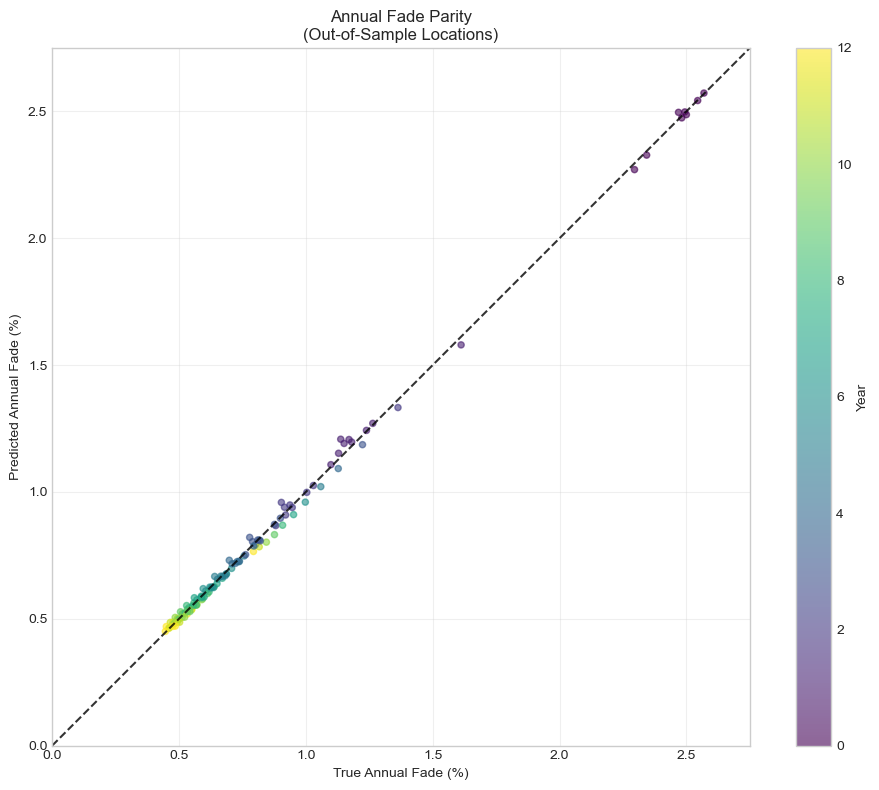

In [5]:
# Create a standalone version of the annual fade parity plot
fig, ax = plt.subplots(figsize=(10, 8))  # Make figure wider to accommodate colorbar

# Recreate the scatter plot
scatter = ax.scatter(df_validation['fade_true'], df_validation['fade_surr'], 
                     s=20, alpha=0.6, c=df_validation['year'], cmap='viridis')

# Set nice round limits (adjust these values as needed)
lims = [0, 2.75]  # or whatever round number looks good

# Add the parity line
ax.plot(lims, lims, 'k--', alpha=0.8)

# Labels and title
ax.set_xlabel('True Annual Fade (%)')
ax.set_ylabel('Predicted Annual Fade (%)')
ax.set_title('Annual Fade Parity\n(Out-of-Sample Locations)')
ax.grid(alpha=0.3)

# Force square aspect ratio for the plot area
ax.set_aspect('equal', adjustable='box')

# Set equal limits to ensure the plot is truly square
ax.set_xlim(lims)
ax.set_ylim(lims)

# Add colorbar with proper positioning
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Year')

# Save the plot
plt.savefig('oos_fade_parity.png', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

THREE-WAY SURROGATE PERFORMANCE COMPARISON
Comparing:
1. BLAST-Lite Ground Truth (expensive)
2. Proxy + Evolved Stressors (medium cost)
3. Proxy + Deterministic Stressors (cheap)

Testing 10 random designs over 13 years


Testing designs:   0%|          | 0/10 [00:00<?, ?it/s]


PERFORMANCE SUMMARY
Annual Fade Errors:
  Proxy + Evolved Stressors:      MAE = 0.0100%,  RMSE = 0.0155%
  Proxy + Deterministic Stressors: MAE = 0.0164%,  RMSE = 0.0209%

Final Capacity Errors (Year 12):
  Proxy + Evolved Stressors:      Mean = 0.076%, Max|Err| = 0.304%
  Proxy + Deterministic Stressors: Mean = 0.161%, Max|Err| = 0.424%

Detailed Results for Final Year (Year 12):
 design_id     site  solar_mw  batt_mw  capacity_blast  capacity_proxy_evolved  capacity_proxy_determ  capacity_error_evolved  capacity_error_determ
         0  Phoenix   361.316  286.630          89.634                  89.619                 89.742                  -0.015                  0.108
         1    Miami   333.757  193.221          88.620                  88.779                 88.985                   0.159                  0.365
         2  Seattle   434.389  196.581          89.882                  89.951                 89.951                   0.069                  0.069
         3  Chicago

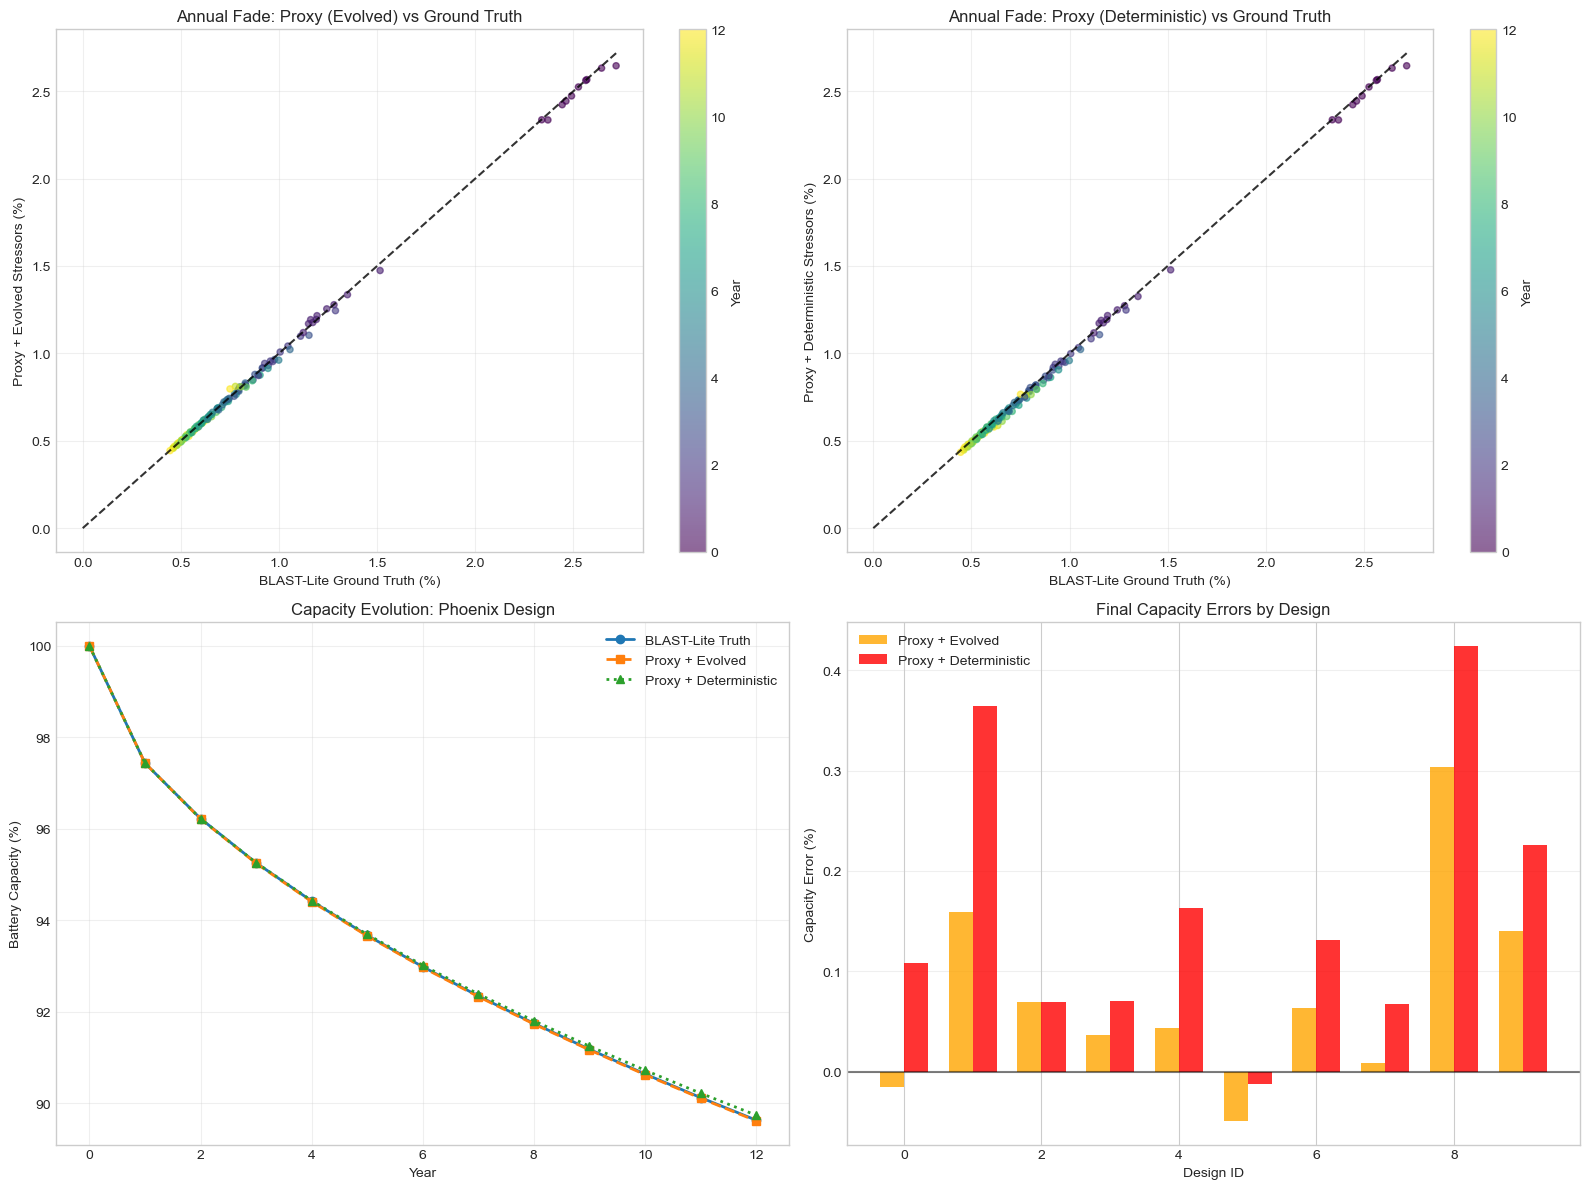


✓ Three-way comparison complete!
✓ 130 total simulation years analyzed
✓ 10 designs tested over 13 years each


In [6]:
# =================================================================
#  Surrogate Performance Analysis: Three-Way Comparison
#  Ground Truth vs Proxy (Evolved) vs Proxy (Deterministic)
# =================================================================
import numpy as np, pandas as pd, pickle, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datacenter_analyzer import DatacenterAnalyzer
from blast import models as blast_models
from math import sqrt
from pvstoragesim import evaluate_system

CellModel = blast_models.Lfp_Gr_250AhPrismatic
MAX_YEAR = 13  # y0 to y12 (single battery life)

# Load surrogate
with open("output_tables/fade_surrogate.pkl", "rb") as f:
    fade = pickle.load(f)

# Helper functions (same as before)
def get_solar_capacity_factor(year, first=0.01, annual=0.0055):
    if year == 0: return 1.0
    cap = 1.0 - first
    if year > 1:
        cap *= (1.0 - annual) ** (year-1)
    return cap

def thermal_profile(sim, facility, init_T=25, rt_eff=0.90,
                   mth_per_MWh=2.3, T_min=15, T_max=30):
    if sim.hourly_data is None or 'battery_soc_mwh' not in sim.hourly_data.columns:
        return np.full(8760, init_T)
    
    hd = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    if cap == 0:
        return np.full(len(hd), init_T)
    
    n = len(hd)
    T = np.empty(n, dtype=float)
    T[0] = init_T
    
    one_way = 1 - sqrt(rt_eff)
    m_th = mth_per_MWh * cap
    
    for h in range(1, n):
        p_ch = abs(hd['battery_charge_mw'].iat[h])
        p_dis = abs(hd['battery_discharge_mw'].iat[h])
        heat_kw = (p_ch + p_dis) * one_way * 1000
        
        pred_T = T[h-1] + heat_kw / m_th
        if pred_T > T_max:
            net_heat = heat_kw - (pred_T - T_max) * m_th
        elif pred_T < T_min and heat_kw < 1.0:
            net_heat = heat_kw + (T_min - pred_T) * m_th
        else:
            net_heat = heat_kw
        
        T[h] = T[h-1] + net_heat / m_th
    
    return T

def make_stressor(sim, facility):
    hd = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    soc = (hd['battery_soc_mwh']/cap).to_numpy()
    temp = thermal_profile(sim, facility)
    return dict(Time_s=np.arange(len(soc))*3600,
                SOC=soc,
                Temperature_C=temp)

def blast_multi_year(stressor_history, years):
    # Concatenate all stressors
    time_concat, soc_concat, temp_concat = [], [], []
    for i, s in enumerate(stressor_history):
        offset = i * 365 * 24 * 3600
        time_concat.extend(s['Time_s'] + offset)
        soc_concat.extend(s['SOC'])
        temp_concat.extend(s['Temperature_C'])
    
    multi_year_stressor = {
        'Time_s': np.array(time_concat),
        'SOC': np.array(soc_concat),
        'Temperature_C': np.array(temp_concat)
    }
    
    # Run BLAST on full history
    cell = CellModel()
    cell.simulate_battery_life(multi_year_stressor, 
                               threshold_time=years,
                               is_constant_input=False,
                               is_conserve_energy_throughput=False)
    
    # Extract fade at each year boundary
    t_days = cell.stressors['t_days']
    q_cal = cell.states['qLoss_t']
    q_cyc = cell.states['qLoss_EFC']
    
    year_fades = []
    prev_cal = prev_cyc = 0.0
    
    for yr in range(1, years + 1):
        idx = int(np.argmin(np.abs(t_days - yr * 365.0)))
        
        total_cal = q_cal[idx] * 100
        total_cyc = q_cyc[idx] * 100
        
        marginal_cal = total_cal - prev_cal
        marginal_cyc = total_cyc - prev_cyc
        
        year_fades.append({
            'marginal_cal': marginal_cal,
            'marginal_cyc': marginal_cyc,
            'total_cal': total_cal,
            'total_cyc': total_cyc
        })
        
        prev_cal = total_cal
        prev_cyc = total_cyc
    
    return year_fades

# Generate 10 random designs across different locations
SITES = {
    "Phoenix": (33.4, -112.1),
    "Miami": (25.8, -80.2), 
    "Seattle": (47.6, -122.3),
    "Chicago": (41.9, -87.6),
    "Dallas": (32.8, -96.8),
    "Denver": (39.7, -104.9),
    "Boston": (42.4, -71.1),
    "LasVegas": (36.2, -115.1),
    "Atlanta": (33.7, -84.4),
    "Portland": (45.5, -122.7)
}

# Design parameters
SOLAR_MIN, SOLAR_MAX = 200, 800   # MW
BATT_P_MIN, BATT_P_MAX = 100, 600  # MW
BATT_DUR = 4.0  # hours

designs = []

site_list = list(SITES.items())
for i in range(10):
    site_name, (lat, lon) = site_list[i]
    solar = np.random.uniform(SOLAR_MIN, SOLAR_MAX)
    batt = np.random.uniform(BATT_P_MIN, BATT_P_MAX)
    designs.append((i, site_name, lat, lon, solar, batt))

print("="*80)
print("THREE-WAY SURROGATE PERFORMANCE COMPARISON")
print("="*80)
print("Comparing:")
print("1. BLAST-Lite Ground Truth (expensive)")
print("2. Proxy + Evolved Stressors (medium cost)")  
print("3. Proxy + Deterministic Stressors (cheap)")
print(f"\nTesting {len(designs)} random designs over {MAX_YEAR} years")

# Main analysis loop
all_results = []

for design_id, site_name, lat, lon, solar, batt in tqdm(designs, desc="Testing designs"):
    fac = DatacenterAnalyzer(lat, lon, total_gpus=24000).calculate_facility_load()
    
    # Initialize capacity tracking for all three methods
    capacity_blast = 1.0      # Ground truth
    capacity_proxy_evolved = 1.0   # Proxy with evolved stressors  
    capacity_proxy_determ = 1.0    # Proxy with deterministic stressors
    
    # Ground truth tracking
    stressor_history = []
    
    # Deterministic stressor parameters (frozen from year 0)
    soc0 = temp0 = efc_ann0 = None
    efc_cum_determ = 0.0
    
    for year in range(MAX_YEAR):
        # Apply solar degradation
        solar_degraded = solar * get_solar_capacity_factor(year)
        
        # === 1. EXPENSIVE GROUND TRUTH ===
        sim_blast = evaluate_system(lat, lon, solar_degraded, batt, fac,
                                   architecture="dc_coupled",
                                   battery_duration_hours=BATT_DUR * capacity_blast,
                                   return_hourly=True)
        
        stressor_history.append(make_stressor(sim_blast, fac))
        fades_blast = blast_multi_year(stressor_history, len(stressor_history))
        fade_blast = fades_blast[-1]['marginal_cal'] + fades_blast[-1]['marginal_cyc']
        
        # === 2. PROXY WITH EVOLVED STRESSORS ===
        sim_evolved = evaluate_system(lat, lon, solar_degraded, batt, fac,
                                     architecture="dc_coupled", 
                                     battery_duration_hours=BATT_DUR * capacity_proxy_evolved,
                                     return_hourly=True)
        
        # Extract evolved stressors for this year
        sf_evolved = sim_evolved.stress_features or {}
        batt_ene_evolved = sim_evolved.hourly_data['battery_soc_mwh'].max()
        efc_ann_evolved = (sf_evolved.get("throughput_mwh", 0.0) / batt_ene_evolved) if batt_ene_evolved else 0.0
        mean_soc_evolved = sf_evolved.get("mean_soc", 0.5)
        mean_T_evolved = thermal_profile(sim_evolved, fac).mean()
        
        # Cumulative EFC for evolved approach
        efc_cum_evolved = year * efc_ann_evolved  # Simple cumulative approximation
        
        # Proxy prediction with evolved stressors
        X_cal_evolved = np.array([[year + 1, mean_soc_evolved, mean_T_evolved]])
        X_cyc_evolved = np.array([[efc_cum_evolved, mean_soc_evolved, mean_T_evolved]])
        dq_cal_evolved, dq_cyc_evolved = fade(X_cal_evolved, X_cyc_evolved)
        
        # Handle array returns
        if hasattr(dq_cal_evolved, '__len__'):
            dq_cal_evolved = float(dq_cal_evolved[0])
        if hasattr(dq_cyc_evolved, '__len__'):
            dq_cyc_evolved = float(dq_cyc_evolved[0])
            
        fade_proxy_evolved = dq_cal_evolved + dq_cyc_evolved
        
        # === 3. PROXY WITH DETERMINISTIC STRESSORS ===
        sim_determ = evaluate_system(lat, lon, solar_degraded, batt, fac,
                                    architecture="dc_coupled",
                                    battery_duration_hours=BATT_DUR * capacity_proxy_determ,
                                    return_hourly=True)
        
        # Extract stressors but freeze year-0 values
        sf_determ = sim_determ.stress_features or {}
        batt_ene_determ = sim_determ.hourly_data['battery_soc_mwh'].max()
        efc_ann_current = (sf_determ.get("throughput_mwh", 0.0) / batt_ene_determ) if batt_ene_determ else 0.0
        mean_soc_current = sf_determ.get("mean_soc", 0.5)
        mean_T_current = thermal_profile(sim_determ, fac).mean()
        
        if year == 0:  # Freeze year-0 stressors
            soc0, temp0, efc_ann0 = mean_soc_current, mean_T_current, efc_ann_current
        
        # Use deterministic stressors
        efc_cum_determ = year * efc_ann0
        X_cal_determ = np.array([[year + 1, soc0, temp0]])
        X_cyc_determ = np.array([[efc_cum_determ, soc0, temp0]])
        dq_cal_determ, dq_cyc_determ = fade(X_cal_determ, X_cyc_determ)
        
        # Handle array returns
        if hasattr(dq_cal_determ, '__len__'):
            dq_cal_determ = float(dq_cal_determ[0])
        if hasattr(dq_cyc_determ, '__len__'):
            dq_cyc_determ = float(dq_cyc_determ[0])
            
        fade_proxy_determ = dq_cal_determ + dq_cyc_determ
        
        # Store results
        all_results.append({
            'design_id': design_id,
            'site': site_name,
            'year': year,
            'solar_mw': solar,
            'batt_mw': batt,
            'fade_blast': fade_blast,
            'fade_proxy_evolved': fade_proxy_evolved,
            'fade_proxy_determ': fade_proxy_determ,
            'capacity_blast': capacity_blast * 100,
            'capacity_proxy_evolved': capacity_proxy_evolved * 100,
            'capacity_proxy_determ': capacity_proxy_determ * 100
        })
        
        # Update capacities for next year
        capacity_blast *= (1 - fade_blast / 100)
        capacity_proxy_evolved *= (1 - fade_proxy_evolved / 100)
        capacity_proxy_determ *= (1 - fade_proxy_determ / 100)

# Convert to DataFrame
df_results = pd.DataFrame(all_results)

# Calculate cumulative capacity errors
df_results['capacity_error_evolved'] = df_results['capacity_proxy_evolved'] - df_results['capacity_blast']
df_results['capacity_error_determ'] = df_results['capacity_proxy_determ'] - df_results['capacity_blast']

# Summary analysis
print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)

# Annual fade errors
fade_mae_evolved = np.mean(np.abs(df_results['fade_proxy_evolved'] - df_results['fade_blast']))
fade_mae_determ = np.mean(np.abs(df_results['fade_proxy_determ'] - df_results['fade_blast']))
fade_rmse_evolved = np.sqrt(np.mean((df_results['fade_proxy_evolved'] - df_results['fade_blast'])**2))
fade_rmse_determ = np.sqrt(np.mean((df_results['fade_proxy_determ'] - df_results['fade_blast'])**2))

print(f"Annual Fade Errors:")
print(f"  Proxy + Evolved Stressors:      MAE = {fade_mae_evolved:.4f}%,  RMSE = {fade_rmse_evolved:.4f}%")
print(f"  Proxy + Deterministic Stressors: MAE = {fade_mae_determ:.4f}%,  RMSE = {fade_rmse_determ:.4f}%")

# Final capacity errors (year 12)
final_year_data = df_results[df_results['year'] == MAX_YEAR - 1]
cap_error_evolved_final = final_year_data['capacity_error_evolved']
cap_error_determ_final = final_year_data['capacity_error_determ']

print(f"\nFinal Capacity Errors (Year {MAX_YEAR-1}):")
print(f"  Proxy + Evolved Stressors:      Mean = {cap_error_evolved_final.mean():.3f}%, Max|Err| = {np.abs(cap_error_evolved_final).max():.3f}%")
print(f"  Proxy + Deterministic Stressors: Mean = {cap_error_determ_final.mean():.3f}%, Max|Err| = {np.abs(cap_error_determ_final).max():.3f}%")

# Display detailed results table for final year
print(f"\nDetailed Results for Final Year (Year {MAX_YEAR-1}):")
final_summary = final_year_data[['design_id', 'site', 'solar_mw', 'batt_mw', 
                                'capacity_blast', 'capacity_proxy_evolved', 'capacity_proxy_determ',
                                'capacity_error_evolved', 'capacity_error_determ']].round(3)
print(final_summary.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Annual fade comparison - Evolved vs BLAST
ax1 = axes[0,0]
scatter1 = ax1.scatter(df_results['fade_blast'], df_results['fade_proxy_evolved'], 
                      s=20, alpha=0.6, c=df_results['year'], cmap='viridis')
lims = [0, max(df_results['fade_blast'].max(), df_results['fade_proxy_evolved'].max())]
ax1.plot(lims, lims, 'k--', alpha=0.8)
ax1.set_xlabel('BLAST-Lite Ground Truth (%)')
ax1.set_ylabel('Proxy + Evolved Stressors (%)')
ax1.set_title('Annual Fade: Proxy (Evolved) vs Ground Truth')
ax1.grid(alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Year')

# 2. Annual fade comparison - Deterministic vs BLAST  
ax2 = axes[0,1]
scatter2 = ax2.scatter(df_results['fade_blast'], df_results['fade_proxy_determ'],
                      s=20, alpha=0.6, c=df_results['year'], cmap='viridis')
lims = [0, max(df_results['fade_blast'].max(), df_results['fade_proxy_determ'].max())]
ax2.plot(lims, lims, 'k--', alpha=0.8)
ax2.set_xlabel('BLAST-Lite Ground Truth (%)')
ax2.set_ylabel('Proxy + Deterministic Stressors (%)')
ax2.set_title('Annual Fade: Proxy (Deterministic) vs Ground Truth')
ax2.grid(alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Year')

# 3. Cumulative capacity evolution for a sample design
ax3 = axes[1,0]
sample_design = df_results[df_results['design_id'] == 0]  # Show first design
ax3.plot(sample_design['year'], sample_design['capacity_blast'], 'o-', 
         label='BLAST-Lite Truth', linewidth=2)
ax3.plot(sample_design['year'], sample_design['capacity_proxy_evolved'], 's--', 
         label='Proxy + Evolved', linewidth=2)
ax3.plot(sample_design['year'], sample_design['capacity_proxy_determ'], '^:', 
         label='Proxy + Deterministic', linewidth=2)
ax3.set_xlabel('Year')
ax3.set_ylabel('Battery Capacity (%)')
ax3.set_title(f'Capacity Evolution: {sample_design.iloc[0]["site"]} Design')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Final capacity error distribution
ax4 = axes[1,1]
x_pos = np.arange(len(final_year_data))
width = 0.35
ax4.bar(x_pos - width/2, final_year_data['capacity_error_evolved'], width, 
        label='Proxy + Evolved', alpha=0.8, color='orange')
ax4.bar(x_pos + width/2, final_year_data['capacity_error_determ'], width, 
        label='Proxy + Deterministic', alpha=0.8, color='red')
ax4.axhline(0, color='black', linestyle='-', alpha=0.5)
ax4.set_xlabel('Design ID')
ax4.set_ylabel('Capacity Error (%)')
ax4.set_title('Final Capacity Errors by Design')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Three-way comparison complete!")
print(f"✓ {len(df_results)} total simulation years analyzed")
print(f"✓ {len(designs)} designs tested over {MAX_YEAR} years each")

Simulation:   0%|          | 0/13 [00:00<?, ?it/s]

2025-09-17 14:52:25,073 - Finished in 6.1s



=== Year-by-year comparison (PV derate included) ===
    year  pv_factor  uptime_pct  blast_annual_fade  gp_annual_fade  \
0      0    100.000      99.635              2.783           2.801   
1      1     99.000      99.589              1.516           1.535   
2      2     98.456      99.555              1.277           1.289   
3      3     97.914      99.543              1.142           1.148   
4      4     97.375      99.509              1.051           1.056   
5      5     96.840      99.486              0.986           0.988   
6      6     96.307      99.475              0.931           0.932   
7      7     95.778      99.441              0.888           0.886   
8      8     95.251      99.384              0.849           0.848   
9      9     94.727      99.349              0.818           0.815   
10    10     94.206      99.247              0.791           0.787   
11    11     93.688      99.132              0.764           0.772   
12    12     93.173      99.064     

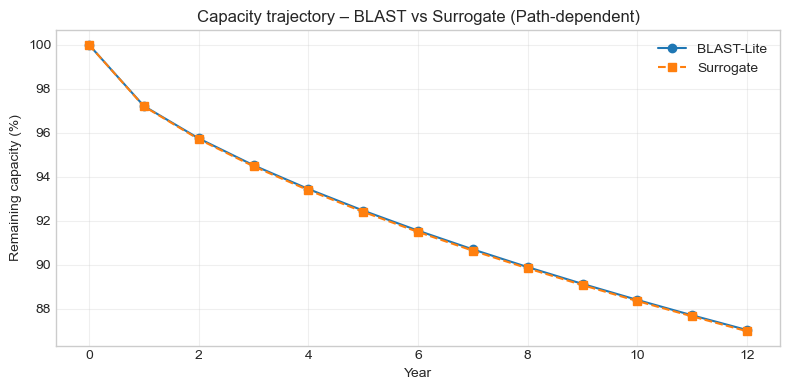

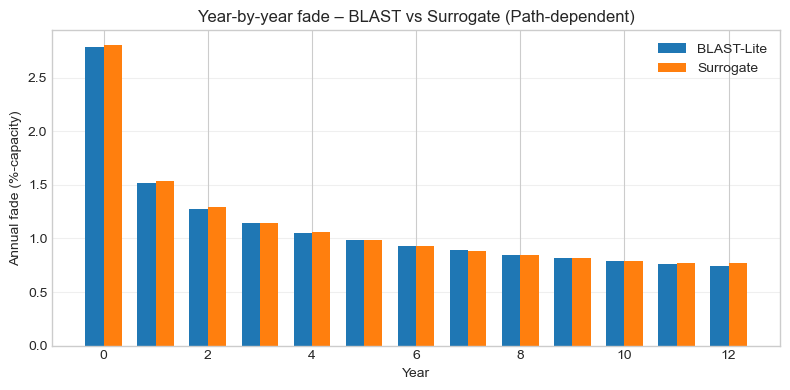

In [14]:
# ===============================================================
#  BLAST-Lite vs GP-Surrogate  –  13-year comparison, one design
#  (Cell 11 - UPDATED FOR NEW SURROGATE)
# ===============================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, time, pickle, logging
from math import sqrt
from tqdm.notebook import tqdm
from blast import models as blast_models

from pvstoragesim import evaluate_system, get_solar_generation
from datacenter_analyzer import DatacenterAnalyzer

# ---------------------------------------------------------------
# 1.  System definition
# ---------------------------------------------------------------
LAT, LON           = 33.60, -115.13          # Coachella Valley, CA
TOTAL_GPUS         = 75_000
SOLAR_MW_INIT      = 516
BATT_P_MW_INIT     = 378
BATT_DUR_HR_INIT   = 4.0                      # 4-h pack
ARCH               = "dc_coupled"
HORIZON_YRS        = 13                       # one battery lifetime

CellModel = blast_models.Lfp_Gr_250AhPrismatic
logger = logging.getLogger("val"); logger.setLevel(logging.INFO)

# ---------------------------------------------------------------
# 2.  Setup (matching Cell 2)
# ---------------------------------------------------------------
analyzer = DatacenterAnalyzer(latitude=LAT, longitude=LON, total_gpus=TOTAL_GPUS)
FACILITY = analyzer.calculate_facility_load()
SOLAR_Y0 = get_solar_generation(LAT, LON, facility_load=FACILITY)

# Solar-panel degradation
def get_solar_capacity_factor(year, first=0.01, annual=0.0055):
    if year == 0: return 1.0
    cap = 1.0 - first
    if year > 1:
        cap *= (1.0 - annual) ** (year-1)
    return cap

# ---------------------------------------------------------------
# 3.  Thermal proxy (EXACT copy from Cell 2)
# ---------------------------------------------------------------
def _thermal_profile(sim, facility, init_T=25, rt_eff=0.90,
                     mth_per_MWh=2.3, T_min=15, T_max=30):
    """
    Compute battery temperature profile and parasitic thermal load.
    Returns dict with 'battery_temperature' array and 'annual_thermal_kwh'.
    """
    if sim.hourly_data is None or 'battery_soc_mwh' not in sim.hourly_data.columns:
        return {'battery_temperature': np.full(8760, init_T), 
                'annual_thermal_kwh': 0.0}

    hd = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    if cap == 0:
        return {'battery_temperature': np.full(len(hd), init_T),
                'annual_thermal_kwh': 0.0}

    n = len(hd)
    T = np.empty(n, dtype=float)
    T[0] = init_T
    
    # Track parasitic loads
    parasitic_kw = np.zeros(n)
    
    one_way = 1 - sqrt(rt_eff)
    m_th = mth_per_MWh * cap  # MJ/K (actually more like kWh/K given the usage)
    pue = np.asarray(facility.hourly_pue)

    for h in range(1, n):
        p_ch = abs(hd['battery_charge_mw'].iat[h])
        p_dis = abs(hd['battery_discharge_mw'].iat[h])
        
        # Heat generation from losses (kW)
        heat_kw = (p_ch + p_dis) * one_way * 1000
        
        # Predicted temperature rise (interpreting m_th as kWh/K for consistency)
        pred_T = T[h-1] + heat_kw / m_th if m_th > 0 else T[h-1]
        
        if pred_T > T_max:
            # Cooling required
            excess_heat_kw = (pred_T - T_max) * m_th
            # CORRECTED: Multiply by (PUE - 1), not divide!
            # Lower PUE → more efficient cooling → less electrical power needed
            elec_kw = excess_heat_kw * max(pue[h] - 1, 0.1)  # Min overhead of 0.1
            parasitic_kw[h] = elec_kw
            T[h] = T_max
            
        elif pred_T < T_min and heat_kw < 1.0:  # Heating when idle
            # Heating needed
            heat_deficit_kw = (T_min - pred_T) * m_th
            parasitic_kw[h] = heat_deficit_kw  # Direct electrical heating
            T[h] = T_min
        else:
            T[h] = pred_T

    # Convert to annual energy
    annual_thermal_kwh = parasitic_kw.sum()
    
    return {'battery_temperature': T,
            'annual_thermal_kwh': annual_thermal_kwh}

# ---------------------------------------------------------------
# 4.  Load trained surrogate (UPDATED PATH)
# ---------------------------------------------------------------
with open("output_tables/fade_surrogate.pkl", "rb") as f:  # FIXED PATH
    fade = pickle.load(f)

# ---------------------------------------------------------------
# 5.  BLAST helper (PATH-DEPENDENT)
# ---------------------------------------------------------------
def blast_marginal_fade(stressor_history):
    """Run BLAST on accumulated history and return marginal fade for last year"""
    if not stressor_history:
        return 0.0, 0.0
    
    # Concatenate all stressors
    time_concat, soc_concat, temp_concat = [], [], []
    for i, s in enumerate(stressor_history):
        offset = i * 365 * 24 * 3600
        time_concat.extend(s['Time_s'] + offset)
        soc_concat.extend(s['SOC'])
        temp_concat.extend(s['Temperature_C'])
    
    multi_year_stressor = {
        'Time_s': np.array(time_concat),
        'SOC': np.array(soc_concat),
        'Temperature_C': np.array(temp_concat)
    }
    
    # Run BLAST on full history
    cell = CellModel()
    cell.simulate_battery_life(multi_year_stressor, 
                               threshold_time=len(stressor_history),
                               is_constant_input=False,
                               is_conserve_energy_throughput=False)
    
    # Get fade at year boundaries
    t_days = cell.stressors['t_days']
    q_cal = cell.states['qLoss_t']
    q_cyc = cell.states['qLoss_EFC']
    
    if len(stressor_history) == 1:
        # First year - total fade is marginal fade
        return q_cal[-1] * 100, q_cyc[-1] * 100
    else:
        # Get fade at previous year and current year
        prev_year_idx = int(np.argmin(np.abs(t_days - (len(stressor_history)-1) * 365)))
        curr_year_idx = int(np.argmin(np.abs(t_days - len(stressor_history) * 365)))
        
        prev_cal = q_cal[prev_year_idx] * 100
        prev_cyc = q_cyc[prev_year_idx] * 100
        curr_cal = q_cal[curr_year_idx] * 100
        curr_cyc = q_cyc[curr_year_idx] * 100
        
        return curr_cal - prev_cal, curr_cyc - prev_cyc

# Build stressor from the dispatch sim (updated to use dict return)
def stressor_from_sim(sim, facility):
    hd = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    therm_result = _thermal_profile(sim, facility)
    return dict(Time_s=np.arange(len(hd)) * 3600,
                SOC=(hd['battery_soc_mwh'] / cap).to_numpy(),
                Temperature_C=therm_result['battery_temperature'])

# Extract surrogate features (updated to use dict return)
def extract_metrics(sim, facility):
    """Extract stress features from simulation results"""
    sf = sim.stress_features or {}
    hd = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    
    mean_soc = sf.get("mean_soc", 0.5)
    tp = sf.get("throughput_mwh", 0.0)
    efc_int = tp / cap if cap > 0 else 0.0
    soc_p90 = np.percentile(hd['battery_soc_mwh']/cap, 90) if cap > 0 else mean_soc
    
    therm_result = _thermal_profile(sim, facility)
    T_series = therm_result['battery_temperature']
    mean_T = float(np.mean(T_series))
    
    return mean_soc, soc_p90, efc_int, mean_T

# ---------------------------------------------------------------
# 6.  Main year-by-year loop (PATH-DEPENDENT) - UPDATED SURROGATE
# ---------------------------------------------------------------
rows = []
capacity_fraction_true = capacity_fraction_pred = 1.0
stressor_history = []  # Accumulate stressors for path-dependent BLAST
efc_cum = 0.0  # Track cumulative EFC for surrogate

t0 = time.time()
for year in tqdm(range(HORIZON_YRS), desc="Simulation"):  # 0 to 12
    pv_factor = get_solar_capacity_factor(year)

    # ---- Dispatch for this year using CURRENT (beginning-of-year) capacity ----
    sim = evaluate_system(
        latitude=LAT, longitude=LON,
        solar_capacity_mw = SOLAR_MW_INIT * pv_factor,
        battery_power_mw  = BATT_P_MW_INIT,
        battery_duration_hours = BATT_DUR_HR_INIT * capacity_fraction_true,  # Beginning-of-year capacity
        facility_load = FACILITY,
        architecture  = ARCH,
        solar_profile = SOLAR_Y0,
        return_hourly = True)

    mean_soc, soc_p90, efc_int, mean_T = extract_metrics(sim, FACILITY)

    # ---- Add this year's stressor to history -------------------
    stressor_history.append(stressor_from_sim(sim, FACILITY))
    
    # ---- Ground-truth fade from accumulated history ------------
    fade_cal_true, fade_cyc_true = blast_marginal_fade(stressor_history)
    fade_true = fade_cal_true + fade_cyc_true

    # ---- Surrogate fade (UPDATED to handle array returns) -----
    year_label = year + 1  # Use 1-13 for calendar model
    x_cal = np.array([[year_label, mean_soc, mean_T]])  # Calendar features
    x_cyc = np.array([[efc_cum, mean_soc, mean_T]])     # Cycle features (cumulative EFC)
    
    dq_cal, dq_cyc = fade(x_cal, x_cyc)
    
    # UPDATED: Handle potential array returns
    if hasattr(dq_cal, '__len__') and len(dq_cal) > 0:
        dq_cal = float(dq_cal[0])
    else:
        dq_cal = float(dq_cal)
        
    if hasattr(dq_cyc, '__len__') and len(dq_cyc) > 0:
        dq_cyc = float(dq_cyc[0])
    else:
        dq_cyc = float(dq_cyc)
    
    fade_pred = dq_cal + dq_cyc

    # ---- Record results with beginning-of-year capacity -------
    beginning_cap_true = capacity_fraction_true * 100  # Before fade
    beginning_cap_pred = capacity_fraction_pred * 100  # Before fade

    rows.append(dict(year=year,  # Use 0-12 to match Cell 2
                     pv_factor=pv_factor*100,
                     uptime_pct=sim.uptime_pct,
                     blast_annual_fade=fade_true,
                     gp_annual_fade=fade_pred,
                     blast_cap_pct=beginning_cap_true,  # Beginning-of-year capacity
                     gp_cap_pct=beginning_cap_pred,     # Beginning-of-year capacity
                     efc_annual=efc_int,                # For diagnostics
                     efc_cumulative=efc_cum))           # For diagnostics

    # ---- Update capacity and EFC for NEXT year -----------------
    capacity_fraction_true *= (1 - fade_true/100)
    capacity_fraction_pred *= (1 - fade_pred/100)
    efc_cum += efc_int  # Update cumulative EFC AFTER using it

logger.info("Finished in %.1fs", time.time()-t0)

df = pd.DataFrame(rows)
df['cum_fade_blast'] = 100 - df['blast_cap_pct']
df['cum_fade_gp']    = 100 - df['gp_cap_pct']

# ---------------------------------------------------------------
# 7.  Table
# ---------------------------------------------------------------
pd.set_option('display.precision', 3)
cols = ["year", "pv_factor", "uptime_pct",
        "blast_annual_fade", "gp_annual_fade",
        "blast_cap_pct", "gp_cap_pct"]
print("\n=== Year-by-year comparison (PV derate included) ===")
print(df[cols])

# Additional diagnostics
print(f"\nFinal EFC cumulative: {efc_cum:.2f}")
print(f"Final capacity - BLAST: {df.iloc[-1]['blast_cap_pct']:.1f}%")
print(f"Final capacity - Surrogate: {df.iloc[-1]['gp_cap_pct']:.1f}%")

# ---------------------------------------------------------------
# 8.  Plots
# ---------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(df.year, df.blast_cap_pct, 'o-', label='BLAST-Lite')
plt.plot(df.year, df.gp_cap_pct,  's--', label='Surrogate')
plt.xlabel("Year"); plt.ylabel("Remaining capacity (%)")
plt.title("Capacity trajectory – BLAST vs Surrogate (Path-dependent)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
w = 0.35
plt.bar(df.year - w/2, df.blast_annual_fade, w, label='BLAST-Lite')
plt.bar(df.year + w/2, df.gp_annual_fade,    w, label='Surrogate')
plt.xlabel("Year"); plt.ylabel("Annual fade (%-capacity)")
plt.title("Year-by-year fade – BLAST vs Surrogate (Path-dependent)")
plt.grid(axis='y', alpha=.3); plt.legend(); plt.tight_layout(); plt.show()

Years:   0%|          | 0/25 [00:00<?, ?it/s]


=== BLAST-Lite vs Surrogate – 25-year run ===
 year  uptime_true  uptime_surr  fade_true  fade_surr  cap_true  cap_surr
    0       99.680       99.680      2.689      2.693   100.000   100.000
    1       99.612       99.612      1.425      1.408    97.311    97.307
    2       99.589       99.589      1.184      1.163    95.924    95.937
    3       99.578       99.578      1.049      1.027    94.788    94.822
    4       99.498       99.498      0.962      0.937    93.794    93.848
    5       99.463       99.475      0.899      0.870    92.891    92.969
    6       99.418       99.418      0.847      0.816    92.056    92.160
    7       99.406       99.406      0.806      0.772    91.276    91.408
    8       99.349       99.349      0.769      0.735    90.541    90.702
    9       99.326       99.326      0.739      0.703    89.844    90.035
   10       99.292       99.304      0.714      0.676    89.180    89.402
   11       99.258       99.281      0.690      0.653    88.544  

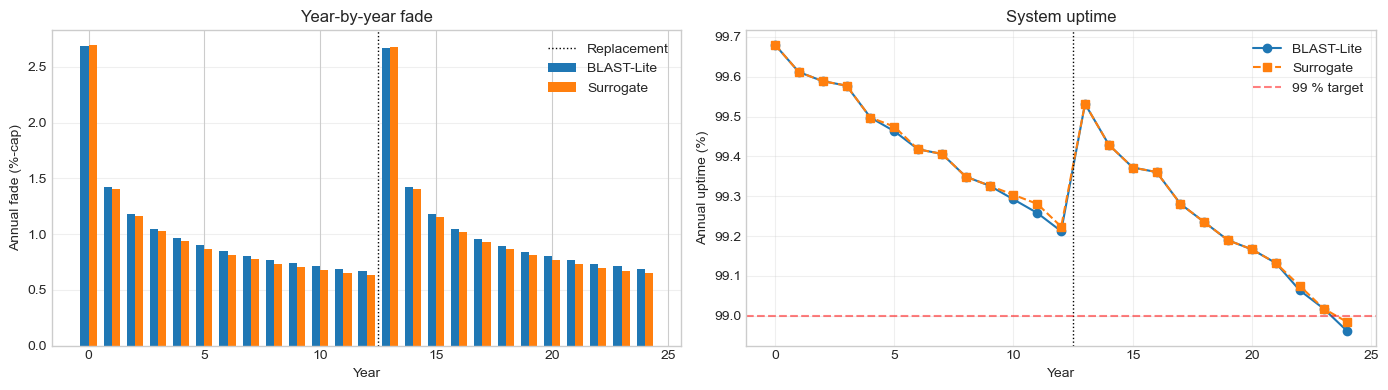

In [18]:
# ===============================================================
#   One-design, 25-year comparison  –  BLAST-Lite vs surrogate
# ===============================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, pickle
from tqdm.auto import trange
from math import sqrt

from pvstoragesim import evaluate_system, get_solar_generation
from datacenter_analyzer import DatacenterAnalyzer
from blast import models as blast_models

# ---------------------------------------------------------------
# 0.  Design constants
# ---------------------------------------------------------------
LAT, LON   = 37.5, -103.5
PV_MW      = 659
BATT_MW    = 462
BATT_DUR_H = 4.0            # 4-hour pack
N_GPUS     = 75_000
ARCH       = "dc_coupled"

HORIZON_Y  = 25             # y0 … y24
REPLACE_AT = 12             # replace after year-12

CellModel  = blast_models.Lfp_Gr_250AhPrismatic

# ---------------------------------------------------------------
# 1.  Site and solar
# ---------------------------------------------------------------
fac     = DatacenterAnalyzer(LAT, LON, total_gpus=N_GPUS).calculate_facility_load()
SOLAR_Y0= get_solar_generation(LAT, LON, facility_load=fac)

def pv_capacity_factor(year, first=0.01, annual=0.0055):
    if year == 0: return 1.0
    cap = 1.0 - first
    if year > 1: cap *= (1.0 - annual)**(year-1)
    return cap

# ---------------------------------------------------------------
# 2.  Helpers
# ---------------------------------------------------------------
SEC_PER_YEAR = 365*24*3600

def thermal_profile(sim, facility, init_T=25, rt_eff=0.90,
                    mth_per_MWh=2.3, T_min=15, T_max=30):
    """Simple lumped-mass battery temperature model."""
    if sim.hourly_data is None:
        return np.full(8760, init_T)

    hd   = sim.hourly_data
    cap  = hd['battery_soc_mwh'].max()
    T    = np.empty(len(hd));  T[0] = init_T
    one_way = 1 - sqrt(rt_eff);  m_th = mth_per_MWh * cap

    for h in range(1, len(hd)):
        p_ch = abs(hd['battery_charge_mw'].iat[h])
        p_ds = abs(hd['battery_discharge_mw'].iat[h])
        heat = (p_ch + p_ds) * one_way * 1000
        pred = T[h-1] + heat / m_th if m_th else T[h-1]
        if   pred > T_max: T[h] = T_max
        elif pred < T_min and heat < 1.0: T[h] = T_min
        else: T[h] = pred
    return T


def build_year_stressor(sim, facility):
    """Return stressor dict (Time_s, SOC, Temperature_C) for one year."""
    hd  = sim.hourly_data
    cap = hd['battery_soc_mwh'].max()
    return dict(Time_s       = np.arange(len(hd))*3600,
                SOC          = (hd['battery_soc_mwh']/cap).to_numpy(),
                Temperature_C= thermal_profile(sim, facility))


def blast_marginal_fade(stress_hist):
    """
    stress_hist: list of *one-year* stressor dicts (t starts at 0 each).
    Returns marginal calendar and cycle fade for the last year in %-capacity.
    """
    # 1. concatenate with time shift
    t_all, soc_all, T_all = [], [], []
    for i, s in enumerate(stress_hist):
        t_all.append(s['Time_s'] + i*SEC_PER_YEAR)
        soc_all.append(s['SOC'])
        T_all.append(s['Temperature_C'])
    t_all  = np.concatenate(t_all)
    soc_all= np.concatenate(soc_all)
    T_all  = np.concatenate(T_all)

    # 2. BLAST simulation
    cell = CellModel()
    cell.simulate_battery_life({'Time_s':t_all,
                                'SOC':soc_all,
                                'Temperature_C':T_all},
                               threshold_time=len(stress_hist),
                               is_constant_input=False,
                               is_conserve_energy_throughput=False)

    t_days = cell.stressors['t_days']
    cal_cum= cell.states['qLoss_t']   * 100   # %
    cyc_cum= cell.states['qLoss_EFC'] * 100   # %

    # cumulative at end-of-this-year and previous year
    idx_now  = np.argmin(np.abs(t_days - len(stress_hist)*365.0))
    if len(stress_hist) == 1:
        # First year - no previous year
        mar_cal = cal_cum[idx_now]
        mar_cyc = cyc_cum[idx_now]
    else:
        idx_prev = np.argmin(np.abs(t_days - (len(stress_hist)-1)*365.0))
        mar_cal = cal_cum[idx_now] - cal_cum[idx_prev]
        mar_cyc = cyc_cum[idx_now] - cyc_cum[idx_prev]
    
    return mar_cal, mar_cyc

# ---------------------------------------------------------------
# 3.  load surrogate (UPDATED PATH)
# ---------------------------------------------------------------
fade = pickle.load(open("output_tables/fade_surrogate.pkl","rb"))  # FIXED PATH

# ---------------------------------------------------------------
# 4.  main loop
# ---------------------------------------------------------------
rows = []

cap_true   = 1.0
cap_surr   = 1.0
stress_hist_true = []

years_in_pack_true = years_in_pack_surr = 0
soc0 = temp0 = efc_ann0 = None
efc_cum_surr = 0.0

for yr in trange(HORIZON_Y, desc="Years"):

    # replacement
    if yr == REPLACE_AT + 1:
        cap_true = cap_surr = 1.0
        stress_hist_true.clear()
        years_in_pack_true = years_in_pack_surr = 0
        soc0 = temp0 = efc_ann0 = None
        efc_cum_surr = 0.0

    pv_mw = PV_MW * pv_capacity_factor(yr)

    # ----- dispatch with current capacities --------------------
    sim_true = evaluate_system(LAT, LON, pv_mw, BATT_MW,
                               battery_duration_hours=BATT_DUR_H*cap_true,
                               facility_load=fac, architecture=ARCH,
                               solar_profile=SOLAR_Y0, return_hourly=True)

    sim_surr = evaluate_system(LAT, LON, pv_mw, BATT_MW,
                               battery_duration_hours=BATT_DUR_H*cap_surr,
                               facility_load=fac, architecture=ARCH,
                               solar_profile=SOLAR_Y0, return_hourly=True)

    # ----- BLAST fade -----------------------------------------
    stress_hist_true.append(build_year_stressor(sim_true, fac))
    mar_cal, mar_cyc = blast_marginal_fade(stress_hist_true)
    fade_true = mar_cal + mar_cyc

    # ----- surrogate fade (deterministic stressors) -----------
    sf      = sim_surr.stress_features or {}
    batt_ene= sim_surr.hourly_data['battery_soc_mwh'].max()
    efc_ann = (sf.get("throughput_mwh",0.0)/batt_ene) if batt_ene else 0.0
    mean_soc= sf.get("mean_soc",0.5)
    mean_T  = thermal_profile(sim_surr, fac).mean()

    if years_in_pack_surr == 0:       # freeze year-0 stressors
        soc0, temp0, efc_ann0 = mean_soc, mean_T, efc_ann

    efc_cum_surr = years_in_pack_surr * efc_ann0
    X_cal = np.array([[years_in_pack_surr+1, soc0, temp0]])
    X_cyc = np.array([[efc_cum_surr,          soc0, temp0]])
    dq_cal, dq_cyc = fade(X_cal, X_cyc)
    
    # UPDATED: Handle potential array returns
    if hasattr(dq_cal, '__len__') and len(dq_cal) > 0:
        dq_cal = float(dq_cal[0])
    else:
        dq_cal = float(dq_cal)
        
    if hasattr(dq_cyc, '__len__') and len(dq_cyc) > 0:
        dq_cyc = float(dq_cyc[0])
    else:
        dq_cyc = float(dq_cyc)
    
    fade_surr = dq_cal + dq_cyc

    # ----- record & update ------------------------------------
    rows.append(dict(year        = yr,
                     uptime_true = sim_true.uptime_pct,
                     uptime_surr = sim_surr.uptime_pct,
                     fade_true   = fade_true,
                     fade_surr   = fade_surr,
                     cap_true    = cap_true*100,
                     cap_surr    = cap_surr*100))

    cap_true *= 1 - fade_true/100
    cap_surr *= 1 - fade_surr/100
    years_in_pack_true  += 1
    years_in_pack_surr  += 1

df = pd.DataFrame(rows)

# ---------------------------------------------------------------
# 5.  results
# ---------------------------------------------------------------
print("\n=== BLAST-Lite vs Surrogate – 25-year run ===")
cols = ['year','uptime_true','uptime_surr','fade_true','fade_surr','cap_true','cap_surr']
print(df[cols].round(3).to_string(index=False))

print("\nAverage uptime     – BLAST : {:.3f}% | Surrogate : {:.3f}%"
      .format(df.uptime_true.mean(), df.uptime_surr.mean()))
print("Minimum annual uptime – BLAST : {:.3f}% | Surrogate : {:.3f}%"
      .format(df.uptime_true.min(), df.uptime_surr.min()))
print("End-of-life capacity (Y24) – BLAST : {:.2f}% | Surrogate : {:.2f}% | gap {:.2f}%"
      .format(df.cap_true.iloc[-1], df.cap_surr.iloc[-1],
              abs(df.cap_true.iloc[-1]-df.cap_surr.iloc[-1])))

# ---------------------------------------------------------------
# 6.  plots
# ---------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

w=0.35
ax1.bar(df.year-w/2, df.fade_true, w, label='BLAST-Lite')
ax1.bar(df.year+w/2, df.fade_surr, w, label='Surrogate')
ax1.axvline(REPLACE_AT+0.5, color='k', ls=':', lw=1, label='Replacement')
ax1.set_xlabel("Year"); ax1.set_ylabel("Annual fade (%-cap)")
ax1.set_title("Year-by-year fade"); ax1.grid(axis='y', alpha=.3); ax1.legend()

ax2.plot(df.year, df.uptime_true, 'o-', label='BLAST-Lite')
ax2.plot(df.year, df.uptime_surr, 's--', label='Surrogate')
ax2.axvline(REPLACE_AT+0.5, color='k', ls=':', lw=1)
ax2.axhline(99, color='r', ls='--', alpha=.5, label='99 % target')
ax2.set_xlabel("Year"); ax2.set_ylabel("Annual uptime (%)")
ax2.set_title("System uptime"); ax2.grid(alpha=.3); ax2.legend()

plt.tight_layout(); plt.show()

Loading formatted geocoded file...
Natural Gas Scaling Analysis
Location: (37.50, -103.50) - Colorado
Uptime Target: 99.0%
Gas Price: $7.7/MMBtu (location-specific)
GPU Range: 3,000 to 246,800

Calculating solar+storage reference at 40,000 GPUs...
  AC Solar+Storage LCOE: $0.2227/kWh
  DC Solar+Storage LCOE: $0.1851/kWh
  Completed in 139.0 seconds

Analyzing natural gas configurations...
  Progress: 0/67 (3,000 GPUs)...
  Progress: 10/67 (15,000 GPUs)...
  Progress: 20/67 (39,000 GPUs)...
  Progress: 30/67 (74,000 GPUs)...
  Progress: 40/67 (122,000 GPUs)...
  Progress: 50/67 (170,000 GPUs)...
  Progress: 60/67 (218,000 GPUs)...

Analysis completed. Found 67 valid configurations.


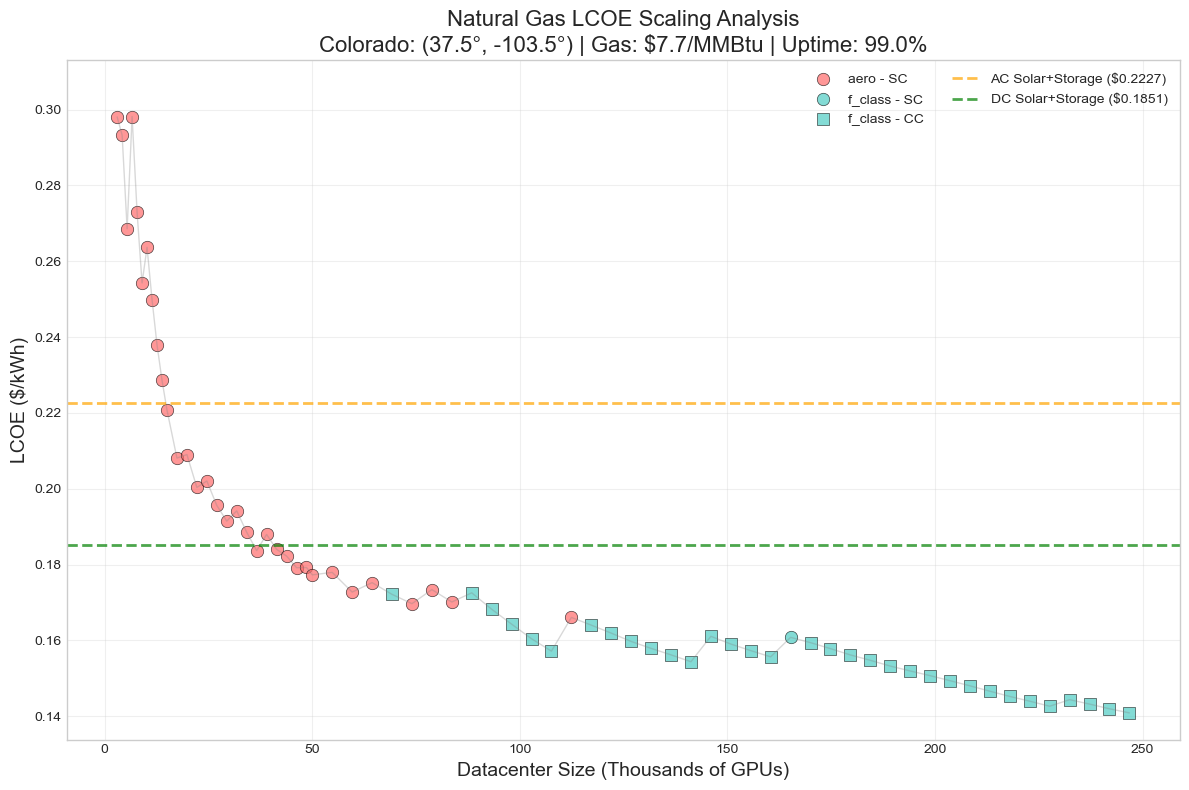


CONFIGURATION DISTRIBUTION ANALYSIS

Configuration Distribution by Size Range (%):
Turbine Class       aero f_class     
Cycle Type            SC      CC   SC
Size Range                           
Large\n(60-90k)      0.0    95.2  4.8
Medium\n(80-1500k)  14.3    85.7  0.0
Small\n(8-80k)      96.3     3.7  0.0
X-Large\n(90-130k)  12.5    87.5  0.0


Top 10 Most Common Specific Configurations:
 1. 2×GE 6F.03                     (f_class-CC):  16.4% (88k-141k GPUs)
 2. 1×Siemens SGT6-5000F           (f_class-CC):  11.9% (170k-204k GPUs)
 3. 2×Siemens SGT-A45              (aero-SC):   7.5% (34k-46k GPUs)
 4. 2×GE 7F.04                     (f_class-CC):   6.0% (165k-247k GPUs)
 5. 1×GE 7F.04                     (f_class-CC):   6.0% (146k-160k GPUs)
 6. 1×GE LM2500+G4                 (aero-SC):   6.0% (13k-17k GPUs)
 7. 2×Mitsubishi M501F             (f_class-CC):   6.0% (208k-228k GPUs)
 8. 3×Siemens SGT-A05 KB7S         (aero-SC):   4.5% (7k-9k GPUs)
 9. 2×P&W FT4000 SwiftPac 70       (ae

In [2]:
# ════════════════════════════════════════════════════════════════
#  Natural Gas Scaling Analysis with Automatic Location Pricing
# ════════════════════════════════════════════════════════════════

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datacenter_analyzer import DatacenterAnalyzer
from natgas_system_tool import NGPowerPlantCalculator, generate_plant_configurations, TURBINE_LIBRARY
from lcoe_calc import calculate_gas_system_lcoe, compare_datacenter_power_systems, get_state_from_coords, GRID_BASELINE_DATA
from config import load_config
import time

# Load the global configuration object
config = load_config()

# Analysis parameters
LOCATION_LAT = 37.5
LOCATION_LON = -103.5
UPTIME_TARGET = 99.0

# Get location-specific gas price
state = get_state_from_coords(LOCATION_LAT, LOCATION_LON)
if state and state in GRID_BASELINE_DATA:
    _, _, _, state_gas_price = GRID_BASELINE_DATA[state]
    GAS_PRICE = state_gas_price if state_gas_price is not None else config.costs.default_gas_price_mmbtu
else:
    GAS_PRICE = config.costs.default_gas_price_mmbtu

# GPU scaling range
def create_gpu_range():
    counts = []
    counts.extend(range(3000, 15000, 1200))
    counts.extend(range(15000, 50000, 2400))
    counts.extend(range(50000, 250000, 4800))
    return counts

gpu_counts = create_gpu_range()
solar_reference_gpus = 40000

print(f"Natural Gas Scaling Analysis")
print(f"Location: ({LOCATION_LAT:.2f}, {LOCATION_LON:.2f}) - {state if state else 'Unknown'}")
print(f"Uptime Target: {UPTIME_TARGET}%")
print(f"Gas Price: ${GAS_PRICE}/MMBtu (location-specific)")
print(f"GPU Range: {min(gpu_counts):,} to {max(gpu_counts):,}")
print("="*60)

# Get solar+storage reference LCOEs
print(f"\nCalculating solar+storage reference at {solar_reference_gpus:,} GPUs...")
start_time = time.time()

# compare_datacenter_power_systems doesn't need explicit config parameter
solar_comparison = compare_datacenter_power_systems(
    total_gpus=solar_reference_gpus,
    required_uptime_pct=UPTIME_TARGET,
    location=(LOCATION_LAT, LOCATION_LON),
    gas_price=GAS_PRICE
    # config parameter removed - function loads its own
)

ac_solar_lcoe = solar_comparison.ac_solar.lcoe
dc_solar_lcoe = solar_comparison.dc_solar.lcoe
print(f"  AC Solar+Storage LCOE: ${ac_solar_lcoe:.4f}/kWh")
print(f"  DC Solar+Storage LCOE: ${dc_solar_lcoe:.4f}/kWh")
print(f"  Completed in {time.time() - start_time:.1f} seconds")

# Analyze natural gas scaling
print(f"\nAnalyzing natural gas configurations...")
results = []

for i, gpu_count in enumerate(gpu_counts):
    if i % 10 == 0:
        print(f"  Progress: {i}/{len(gpu_counts)} ({gpu_count:,} GPUs)...")

    # FIX 1: DatacenterAnalyzer doesn't take config parameter
    analyzer = DatacenterAnalyzer(
        latitude=LOCATION_LAT,
        longitude=LOCATION_LON,
        total_gpus=gpu_count
        # config parameter removed
    )

    facility_load = analyzer.calculate_facility_load(required_uptime_pct=UPTIME_TARGET)
    facility_mw = facility_load.facility_load_design_mw

    # NGPowerPlantCalculator with config
    ng_calculator = NGPowerPlantCalculator(
        facility_load=facility_load,
        required_uptime_pct=UPTIME_TARGET,
        gas_price_mmbtu=GAS_PRICE,
        efficiency_params=config
    )

    # FIX 2: Add annual_energy_mwh parameter for improved EUE calculation
    configs = generate_plant_configurations(
        ng_calculator.required_generation_mw,
        TURBINE_LIBRARY,
        facility_load.design_ambient_temp_c,
        require_n_minus_1=False,
        config=config,
        annual_energy_mwh=ng_calculator.annual_energy_mwh  # ADD THIS
    )

    if not configs:
        print(f"  WARNING: No feasible NG config for {gpu_count:,} GPUs")
        continue

    best_lcoe = float('inf')
    best_config = None

    for plant_config in configs:
        try:
            # FIX 3: Pass whole FacilityLoad object, not just the float
            lcoe_result = calculate_gas_system_lcoe(
                plant_config=plant_config,  # Use keyword arg for clarity
                gas_price=GAS_PRICE,
                facility_load=facility_load,  # CHANGED: Pass whole object
                config=config
            )

            if lcoe_result.lcoe < best_lcoe:
                best_lcoe = lcoe_result.lcoe
                best_config = plant_config
        except Exception as e:
            # Uncomment for debugging:
            # print(f"Error calculating LCOE for config {plant_config.turbine_model}: {e}")
            continue

    if best_config:
        results.append({
            'gpus': gpu_count,
            'facility_mw': facility_mw,
            'ng_lcoe': best_lcoe,
            'configuration': f"{best_config.n_units}×{best_config.turbine_model}",
            'turbine_class': best_config.turbine_class,
            'cycle_type': best_config.cycle_type,
            'total_capacity_mw': best_config.total_capacity_mw,
            'n_units': best_config.n_units,
            'unit_capacity_mw': best_config.unit_capacity_mw,
            'efficiency': best_config.efficiency
        })

results_df = pd.DataFrame(results)
ng_baseline_data = results_df
print(f"\nAnalysis completed. Found {len(results_df)} valid configurations.")

# ════════════════════════════════════════════════════════════════
#  Plotting and Further Analysis (No changes needed below this line)
# ════════════════════════════════════════════════════════════════

# Create the main plot (single axis only)
fig, ax = plt.subplots(figsize=(12, 8))

# Plot natural gas LCOE with markers for cycle type
cycle_markers = {'SC': 'o', 'CC': 's'}
turbine_colors = {'aero': '#FF6B6B', 'f_class': '#4ECDC4', 'h_class': '#45B7D1'}

for turbine_class in ['aero', 'f_class', 'h_class']:
    for cycle_type in ['SC', 'CC']:
        mask = (results_df['turbine_class'] == turbine_class) & (results_df['cycle_type'] == cycle_type)
        class_data = results_df[mask]

        if not class_data.empty:
            ax.scatter(class_data['gpus']/1000,  # Convert to thousands
                       class_data['ng_lcoe'],
                       color=turbine_colors[turbine_class],
                       marker=cycle_markers[cycle_type],
                       s=80,
                       alpha=0.7,
                       label=f'{turbine_class} - {cycle_type}',
                       edgecolors='black',
                       linewidth=0.5)

# Add connecting line
ax.plot(results_df['gpus']/1000,
        results_df['ng_lcoe'],
        color='gray',
        alpha=0.3,
        linewidth=1,
        linestyle='-',
        zorder=1)

# Add solar reference lines
ax.axhline(ac_solar_lcoe, color='orange', linestyle='--', alpha=0.7,
           linewidth=2, label=f'AC Solar+Storage (${ac_solar_lcoe:.4f})')
ax.axhline(dc_solar_lcoe, color='green', linestyle='--', alpha=0.7,
           linewidth=2, label=f'DC Solar+Storage (${dc_solar_lcoe:.4f})')

# Formatting
ax.set_xlabel('Datacenter Size (Thousands of GPUs)', fontsize=14)
ax.set_ylabel('LCOE ($/kWh)', fontsize=14)
ax.set_title(f'Natural Gas LCOE Scaling Analysis\n'
             f'{state if state else "Location"}: ({LOCATION_LAT:.1f}°, {LOCATION_LON:.1f}°) | '
             f'Gas: ${GAS_PRICE}/MMBtu | Uptime: {UPTIME_TARGET}%',
             fontsize=16)
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10, ncol=2)

# Set y-axis limits dynamically
if not results_df.empty:
    y_min = min(results_df['ng_lcoe'].min(), ac_solar_lcoe, dc_solar_lcoe) * 0.95
    y_max = max(results_df['ng_lcoe'].max(), ac_solar_lcoe, dc_solar_lcoe) * 1.05
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# Configuration distribution analysis
if not results_df.empty:
    print("\n" + "="*60)
    print("CONFIGURATION DISTRIBUTION ANALYSIS")
    print("="*60)

    # Create size bins
    size_bins = [(8, 80), (80, 150), (150, 250), (90, 130)]
    bin_labels = ['Small\n(8-80k)', 'Medium\n(80-1500k)', 'Large\n(60-90k)', 'X-Large\n(90-130k)']

    # Analyze distribution by size
    config_by_size = []
    for (min_k, max_k), label in zip(size_bins, bin_labels):
        bin_data = results_df[(results_df['gpus'] >= min_k*1000) & (results_df['gpus'] <= max_k*1000)]

        if not bin_data.empty:
            # Count configurations
            for turbine_class in ['aero', 'f_class', 'h_class']:
                for cycle_type in ['SC', 'CC']:
                    count = len(bin_data[(bin_data['turbine_class'] == turbine_class) &
                                         (bin_data['cycle_type'] == cycle_type)])
                    if count > 0:
                        config_by_size.append({
                            'Size Range': label,
                            'Turbine Class': turbine_class,
                            'Cycle Type': cycle_type,
                            'Count': count,
                            'Percentage': count / len(bin_data) * 100
                        })

    config_dist_df = pd.DataFrame(config_by_size)

    if not config_dist_df.empty:
        # Create pivot table
        pivot_table = config_dist_df.pivot_table(
            values='Percentage',
            index=['Size Range'],
            columns=['Turbine Class', 'Cycle Type'],
            fill_value=0
        )

        print("\nConfiguration Distribution by Size Range (%):")
        print(pivot_table.round(1))

    # Most common configurations overall
    print("\n\nTop 10 Most Common Specific Configurations:")
    config_counts = results_df.groupby(['configuration', 'turbine_class', 'cycle_type']).size()
    config_pcts = (config_counts / len(results_df) * 100).sort_values(ascending=False)

    for i, ((config_name, t_class, c_type), pct) in enumerate(config_pcts.head(10).items()):
        gpu_range = results_df[results_df['configuration'] == config_name]['gpus']
        print(f"{i+1:2d}. {config_name:30s} ({t_class}-{c_type}): {pct:5.1f}% "
              f"({gpu_range.min()/1000:.0f}k-{gpu_range.max()/1000:.0f}k GPUs)")

    # Transition analysis
    print("\n\nConfiguration Transitions:")
    transitions = []
    prev_config = None
    for _, row in results_df.iterrows():
        current_config = (row['turbine_class'], row['cycle_type'])
        if prev_config and current_config != prev_config:
            transitions.append({
                'GPUs (k)': row['gpus']/1000,
                'MW': row['facility_mw'],
                'From': f"{prev_config[0]}-{prev_config[1]}",
                'To': f"{current_config[0]}-{current_config[1]}"
            })
        prev_config = current_config

    if transitions:
        trans_df = pd.DataFrame(transitions)
        print(trans_df.to_string(index=False))
else:
    print("\nNo results to analyze.")

Figure saved as: natural_gas_lcoe_scaling_Colorado.png


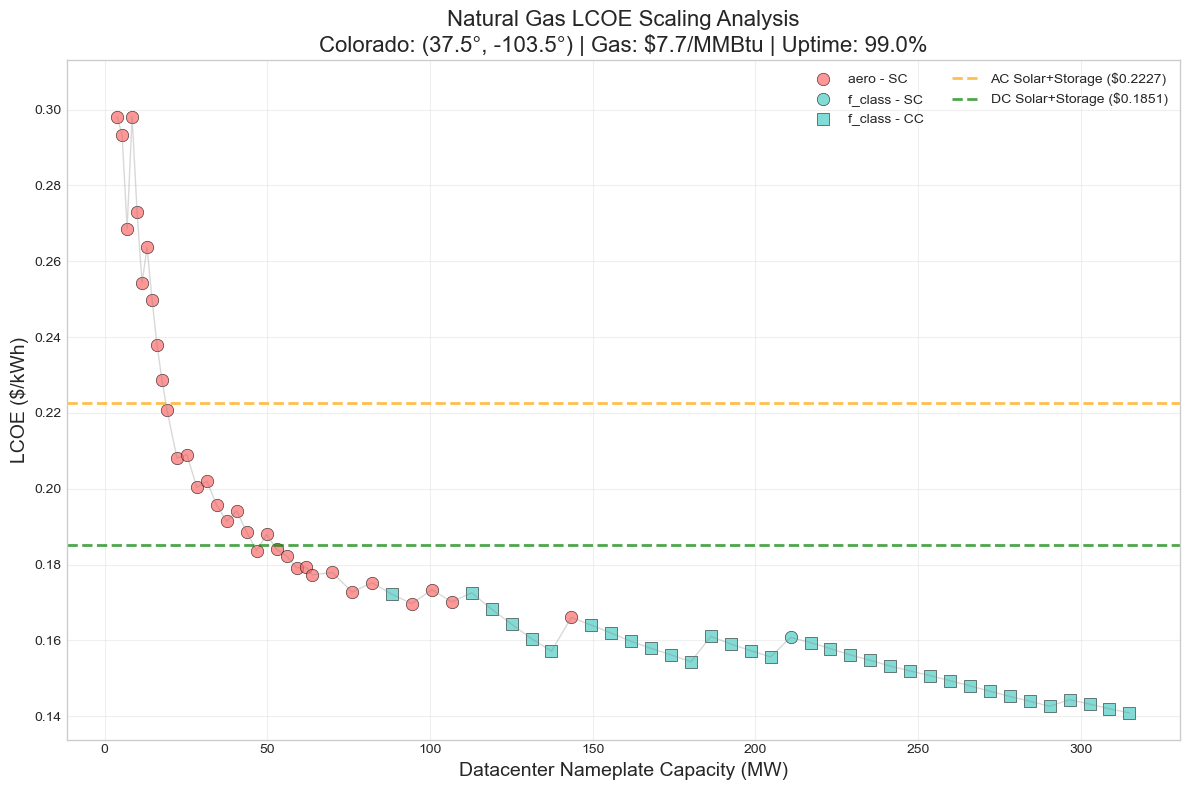

In [3]:

# Create the main plot (single axis only)
fig, ax = plt.subplots(figsize=(12, 8))

# Plot natural gas LCOE with markers for cycle type
cycle_markers = {'SC': 'o', 'CC': 's'}
turbine_colors = {'aero': '#FF6B6B', 'f_class': '#4ECDC4', 'h_class': '#45B7D1'}

for turbine_class in ['aero', 'f_class', 'h_class']:
    for cycle_type in ['SC', 'CC']:
        mask = (results_df['turbine_class'] == turbine_class) & (results_df['cycle_type'] == cycle_type)
        class_data = results_df[mask]

        if not class_data.empty:
            ax.scatter(class_data['facility_mw'], 
                       class_data['ng_lcoe'],
                       color=turbine_colors[turbine_class],
                       marker=cycle_markers[cycle_type],
                       s=80,
                       alpha=0.7,
                       label=f'{turbine_class} - {cycle_type}',
                       edgecolors='black',
                       linewidth=0.5)

# Add connecting line
ax.plot(results_df['facility_mw'],
        results_df['ng_lcoe'],
        color='gray',
        alpha=0.3,
        linewidth=1,
        linestyle='-',
        zorder=1)

# Add solar reference lines
ax.axhline(ac_solar_lcoe, color='orange', linestyle='--', alpha=0.7,
           linewidth=2, label=f'AC Solar+Storage (${ac_solar_lcoe:.4f})')
ax.axhline(dc_solar_lcoe, color='green', linestyle='--', alpha=0.7,
           linewidth=2, label=f'DC Solar+Storage (${dc_solar_lcoe:.4f})')

# Formatting
ax.set_xlabel('Datacenter Nameplate Capacity (MW)', fontsize=14)
ax.set_ylabel('LCOE ($/kWh)', fontsize=14)
ax.set_title(f'Natural Gas LCOE Scaling Analysis\n'
             f'{state if state else "Location"}: ({LOCATION_LAT:.1f}°, {LOCATION_LON:.1f}°) | '
             f'Gas: ${GAS_PRICE}/MMBtu | Uptime: {UPTIME_TARGET}%',
             fontsize=16)
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10, ncol=2)

# Set y-axis limits dynamically
if not results_df.empty:
    y_min = min(results_df['ng_lcoe'].min(), ac_solar_lcoe, dc_solar_lcoe) * 0.95
    y_max = max(results_df['ng_lcoe'].max(), ac_solar_lcoe, dc_solar_lcoe) * 1.05
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
filename = f'natural_gas_lcoe_scaling_{state or "location"}.png'
plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Figure saved as: {filename}")


plt.show()

In [5]:
# Jupyter Notebook Implementation Structure

# Cell 1: Setup and Data Loading
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple
import logging
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

# Import your modules
from config import load_config
from microgrid_optimizer import MicrogridOptimizer, SystemCosts
from lcoe_calc import calculate_solar_storage_lcoe, calculate_grid_baseline_lcoe, calculate_gpu_idling_costs
from natgas_system_tool import NGPowerPlantCalculator
from power_systems_estimator import PowerFlowAnalyzer

# Cell 2: Load and Explore Dataset
def load_and_explore_data():
    data_path = r"C:\Users\btuser\Documents\Work\Data Centers\Half Baked Research\DC DC\AI Microgrids\geographic_analysis\conus_res4_results.pkl"
    
    with open(data_path, 'rb') as f:
        dataset = pickle.load(f)
    
    print(f"Total records: {len(dataset)}")
    
    # Analyze structure
    sample_record = dataset[0]
    print(f"Keys in each record: {list(sample_record.keys())}")
    
    # Check GPU sizes and geographic coverage
    gpu_counts = set(record['gpu_count'] for record in dataset)
    locations = len(set(record['h3_index'] for record in dataset))
    
    print(f"GPU sizes: {sorted(gpu_counts)}")
    print(f"Unique locations: {locations}")
    
    return dataset

dataset = load_and_explore_data()

Total records: 13134
Keys in each record: ['h3_index', 'latitude', 'longitude', 'gpu_count', 'annual_pue', 'design_load_mw', 'annual_energy_gwh', 'facility_load_object']
GPU sizes: [24000, 50000, 750000]
Unique locations: 4378


In [11]:
# ════════════════════════════════════════════════════════════════
#  Natural Gas and Solar LCOE vs Uptime Analysis - Multi-Location CSV Output
# ════════════════════════════════════════════════════════════════

import numpy as np
import pandas as pd
from datacenter_analyzer import DatacenterAnalyzer
from natgas_system_tool import NGPowerPlantCalculator, generate_plant_configurations, TURBINE_LIBRARY
from lcoe_calc import calculate_gas_system_lcoe, compare_datacenter_power_systems, get_state_from_coords, GRID_BASELINE_DATA, calculate_grid_baseline_lcoe
from microgrid_optimizer import MicrogridOptimizer, SystemCosts
from config import load_config
import time

# Load the global configuration object
config = load_config()

# Analysis parameters
FIXED_GPU_COUNT = 50000

# Define locations for analysis
LOCATIONS = {
    'Southern_California': (33.6, -115.135),      # Original location
    'Houston_TX': (29.76, -95.37),               # Houston, Texas
    'Eastern_Washington': (46.70, -117.15),       # Spokane area (Eastern WA)
    'Northern_Virginia': (38.95, -77.45)          # Loudoun County (Data Center Alley)
}

# Uptime range - 5% increments up to 90%, then 1% increments to 99%, plus special points
uptime_values = np.concatenate([
    np.arange(2.5, 80, 2.5),      # 5% increments up to 90%
    np.arange(80, 99, 1),     # 1% increments from 90% to 99%
    np.array([99.5, 99.9])    # Special high-reliability points
])

print(f"Multi-Location Natural Gas and Solar LCOE vs Uptime Analysis")
print(f"Fixed Facility Size: {FIXED_GPU_COUNT:,} GPUs")
print(f"Locations: {list(LOCATIONS.keys())}")
print(f"Uptime Range: {min(uptime_values):.1f}% to {max(uptime_values):.1f}% ({len(uptime_values)} points)")
print("="*80)

# Setup DC solar costs (same for all locations)
dc_costs = SystemCosts(
    solar_cost_per_kw=config.costs.solar_cost_y0,
    battery_cost_per_kw=config.costs.bess_cost_y0,
    solar_bos_cost_per_kw=config.costs.solar_bos_cost_y0_dc,
    battery_bos_cost_per_kw=config.costs.battery_bos_cost_y0_dc
)

# Master results list for all locations
all_results = []

# Analyze each location
for location_name, (lat, lon) in LOCATIONS.items():
    print(f"\n{'='*80}")
    print(f"ANALYZING LOCATION: {location_name}")
    print(f"Coordinates: ({lat:.2f}, {lon:.2f})")
    print(f"{'='*80}")
    
    # Get location-specific information
    state = get_state_from_coords(lat, lon)
    if state and state in GRID_BASELINE_DATA:
        _, _, _, state_gas_price = GRID_BASELINE_DATA[state]
        gas_price = state_gas_price if state_gas_price is not None else config.costs.default_gas_price_mmbtu
    else:
        gas_price = config.costs.default_gas_price_mmbtu
    
    print(f"State: {state if state else 'Unknown'}")
    print(f"Gas Price: ${gas_price:.2f}/MMBtu (location-specific)")
    
    # Calculate grid baseline LCOE for this location
    print(f"Calculating grid baseline LCOE...")
    analyzer_reference = DatacenterAnalyzer(
        latitude=lat,
        longitude=lon,
        total_gpus=FIXED_GPU_COUNT
    )
    facility_load_reference = analyzer_reference.calculate_facility_load(required_uptime_pct=99.0)
    annual_energy_mwh = facility_load_reference.annual_facility_energy_mwh

    grid_baseline_lcoe_result = calculate_grid_baseline_lcoe(
        annual_energy_mwh=annual_energy_mwh,
        required_uptime_pct=99.0,
        config=config,
        location=(lat, lon)
    )
    grid_lcoe = grid_baseline_lcoe_result.lcoe
    print(f"  Grid Baseline LCOE: ${grid_lcoe:.4f}/kWh")
    
    # Analyze uptime scaling for this location
    print(f"Analyzing configurations across uptime requirements...")
    location_start_time = time.time()
    
    for i, uptime in enumerate(uptime_values):
        print(f"  Progress: {i+1}/{len(uptime_values)} (Uptime: {uptime:.1f}%)...")
        
        start_time = time.time()
        
        # Create analyzer for this uptime requirement
        analyzer = DatacenterAnalyzer(
            latitude=lat,
            longitude=lon,
            total_gpus=FIXED_GPU_COUNT
        )
        
        facility_load = analyzer.calculate_facility_load(required_uptime_pct=uptime)
        facility_mw = facility_load.facility_load_design_mw
        
        # ═══════════════════════════════════════════════════════════════
        # DC Solar+Storage Optimization
        # ═══════════════════════════════════════════════════════════════
        try:
            dc_optimizer = MicrogridOptimizer(
                latitude=lat,
                longitude=lon,
                facility_load=facility_load,
                required_uptime_pct=uptime,
                costs=dc_costs,
                architecture="dc_coupled",
                efficiency_params=config,
                verbose=False
            )
            
            dc_config = dc_optimizer.optimize()
            
            # Get proper LCOE calculation
            from lcoe_calc import calculate_solar_storage_lcoe
            dc_lcoe_result = calculate_solar_storage_lcoe(
                system_type="dc_coupled",
                solar_mw=dc_config.solar_mw,
                battery_mw=dc_config.battery_mw,
                battery_mwh=dc_config.battery_mwh,
                land_acres=dc_config.land_area_acres,
                sim_year_0=dc_config.sim_year_0,
                sim_year_13=dc_config.sim_year_13,
                sim_year_14=dc_config.sim_year_14,
                sim_year_25=dc_config.sim_year_25,
                year_0_stats=dc_config.year_0_stats,
                construction_years=config.design.solar_construction_years,
                required_uptime_pct=uptime,
                config=config
            )
            dc_solar_lcoe = dc_lcoe_result.lcoe
            dc_solar_capacity_mw = dc_config.solar_mw
            dc_battery_capacity_mw = dc_config.battery_mw
            dc_battery_capacity_mwh = dc_config.battery_mwh
            dc_land_acres = dc_config.land_area_acres
            dc_success = True
            
        except Exception as e:
            print(f"    DC Solar optimization failed: {e}")
            dc_solar_lcoe = float('inf')
            dc_solar_capacity_mw = 0
            dc_battery_capacity_mw = 0
            dc_battery_capacity_mwh = 0
            dc_land_acres = 0
            dc_success = False
        
        # ═══════════════════════════════════════════════════════════════
        # Natural Gas Optimization
        # ═══════════════════════════════════════════════════════════════
        try:
            ng_calculator = NGPowerPlantCalculator(
                facility_load=facility_load,
                required_uptime_pct=uptime,
                gas_price_mmbtu=gas_price,
                efficiency_params=config
            )
            
            configs = generate_plant_configurations(
                ng_calculator.required_generation_mw,
                TURBINE_LIBRARY,
                facility_load.design_ambient_temp_c,
                require_n_minus_1=False,
                config=config,
                annual_energy_mwh=ng_calculator.annual_energy_mwh
            )
            
            if not configs:
                raise ValueError("No feasible NG configurations found")
            
            best_lcoe = float('inf')
            best_config = None
            
            for plant_config in configs:
                try:
                    lcoe_result = calculate_gas_system_lcoe(
                        plant_config=plant_config,
                        gas_price=gas_price,
                        facility_load=facility_load,
                        config=config
                    )
                    
                    if lcoe_result.lcoe < best_lcoe:
                        best_lcoe = lcoe_result.lcoe
                        best_config = plant_config
                except Exception as e:
                    continue
            
            if best_config:
                ng_lcoe = best_lcoe
                ng_configuration = f"{best_config.n_units}×{best_config.turbine_model} {best_config.cycle_type}"
                ng_capacity_mw = best_config.total_capacity_mw
                ng_n_units = best_config.n_units
                ng_turbine_model = best_config.turbine_model
                ng_cycle_type = best_config.cycle_type
                ng_success = True
            else:
                raise ValueError("No valid NG configuration found")
                
        except Exception as e:
            print(f"    NG optimization failed: {e}")
            ng_lcoe = float('inf')
            ng_configuration = "Failed"
            ng_capacity_mw = 0
            ng_n_units = 0
            ng_turbine_model = "Failed"
            ng_cycle_type = "Failed"
            ng_success = False
        
        # Store results with location information
        all_results.append({
            'location_name': location_name,
            'latitude': lat,
            'longitude': lon,
            'state': state if state else 'Unknown',
            'gas_price_mmbtu': gas_price,
            'uptime_pct': uptime,
            'facility_mw': facility_mw,
            'dc_solar_lcoe': dc_solar_lcoe,
            'dc_solar_capacity_mw': dc_solar_capacity_mw,
            'dc_battery_capacity_mw': dc_battery_capacity_mw,
            'dc_battery_capacity_mwh': dc_battery_capacity_mwh,
            'dc_land_acres': dc_land_acres,
            'dc_success': dc_success,
            'ng_lcoe': ng_lcoe,
            'ng_configuration': ng_configuration,
            'ng_capacity_mw': ng_capacity_mw,
            'ng_n_units': ng_n_units,
            'ng_turbine_model': ng_turbine_model,
            'ng_cycle_type': ng_cycle_type,
            'ng_success': ng_success,
            'grid_lcoe': grid_lcoe,
            'calculation_time': time.time() - start_time
        })
        
        print(f"    DC Solar: ${dc_solar_lcoe:.4f}/kWh, NG: ${ng_lcoe:.4f}/kWh (took {time.time() - start_time:.1f}s)")
    
    location_time = time.time() - location_start_time
    print(f"\nLocation {location_name} completed in {location_time/60:.1f} minutes")

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
print(f"\n{'='*80}")
print(f"ANALYSIS COMPLETED FOR ALL LOCATIONS")
print(f"{'='*80}")
print(f"Total analysis time: {sum(results_df['calculation_time'])/60:.1f} minutes")
print(f"Total data points: {len(results_df)} ({len(uptime_values)} uptime points × {len(LOCATIONS)} locations)")

# ════════════════════════════════════════════════════════════════
#  CSV Output
# ════════════════════════════════════════════════════════════════

print("\n" + "="*60)
print("SAVING RESULTS TO CSV")
print("="*60)

# Create comprehensive output filename
output_filename = f"lcoe_vs_uptime_multi_location_{FIXED_GPU_COUNT}gpus.csv"

# Save to CSV
results_df.to_csv(output_filename, index=False)
print(f"Results saved to: {output_filename}")
print(f"Total data points: {len(results_df)}")
print(f"Columns: {list(results_df.columns)}")

# Show summary by location
print(f"\nResults summary by location:")
print("-" * 80)
for location in LOCATIONS.keys():
    location_data = results_df[results_df['location_name'] == location]
    dc_success_rate = location_data['dc_success'].sum() / len(location_data) * 100
    ng_success_rate = location_data['ng_success'].sum() / len(location_data) * 100
    avg_grid_lcoe = location_data['grid_lcoe'].iloc[0]  # Same for all rows in location
    
    print(f"{location:<20} | DC Success: {dc_success_rate:5.1f}% | NG Success: {ng_success_rate:5.1f}% | Grid LCOE: ${avg_grid_lcoe:.4f}/kWh")

# Show first few rows as verification
print(f"\nFirst 5 rows:")
print(results_df.head()[['location_name', 'uptime_pct', 'dc_solar_lcoe', 'ng_lcoe', 'grid_lcoe']].to_string())



Multi-Location Natural Gas and Solar LCOE vs Uptime Analysis
Fixed Facility Size: 50,000 GPUs
Locations: ['Southern_California', 'Houston_TX', 'Eastern_Washington', 'Northern_Virginia']
Uptime Range: 2.5% to 99.9% (52 points)

ANALYZING LOCATION: Southern_California
Coordinates: (33.60, -115.14)
State: California
Gas Price: $12.75/MMBtu (location-specific)
Calculating grid baseline LCOE...
  Grid Baseline LCOE: $0.1850/kWh
Analyzing configurations across uptime requirements...
  Progress: 1/52 (Uptime: 2.5%)...
    DC Solar: $0.0854/kWh, NG: $3.6382/kWh (took 82.7s)
  Progress: 2/52 (Uptime: 5.0%)...
    DC Solar: $0.0858/kWh, NG: $1.8930/kWh (took 100.8s)
  Progress: 3/52 (Uptime: 7.5%)...
    DC Solar: $0.0827/kWh, NG: $1.3112/kWh (took 71.4s)
  Progress: 4/52 (Uptime: 10.0%)...
    DC Solar: $0.0882/kWh, NG: $1.0204/kWh (took 87.0s)
  Progress: 5/52 (Uptime: 12.5%)...
    DC Solar: $0.0851/kWh, NG: $0.8458/kWh (took 79.6s)
  Progress: 6/52 (Uptime: 15.0%)...
    DC Solar: $0.0853/kW

2025-09-25 10:22:43,587 - No feasible designs – expanding bounds by ×1.5


    DC Solar: $0.3669/kWh, NG: $0.2079/kWh (took 63.4s)
  Progress: 49/52 (Uptime: 97.0%)...


2025-09-25 10:23:46,722 - No feasible designs – expanding bounds by ×1.5


    DC Solar: $0.3957/kWh, NG: $0.2072/kWh (took 51.8s)
  Progress: 50/52 (Uptime: 98.0%)...


2025-09-25 10:24:44,849 - No feasible designs – expanding bounds by ×1.5


    DC Solar: $0.4256/kWh, NG: $0.2065/kWh (took 74.4s)
  Progress: 51/52 (Uptime: 99.5%)...


2025-09-25 10:25:52,686 - No feasible designs – expanding bounds by ×1.5


    DC Solar: $0.5461/kWh, NG: $0.2054/kWh (took 14.4s)
  Progress: 52/52 (Uptime: 99.9%)...


2025-09-25 10:26:06,983 - No feasible designs – expanding bounds by ×1.5
2025-09-25 10:26:07,764 - No feasible designs – expanding bounds by ×1.5


    DC Solar: $0.6329/kWh, NG: $0.2051/kWh (took 40.9s)

Location Eastern_Washington completed in 69.4 minutes

ANALYZING LOCATION: Northern_Virginia
Coordinates: (38.95, -77.45)
State: Virginia
Gas Price: $4.58/MMBtu (location-specific)
Calculating grid baseline LCOE...
  Grid Baseline LCOE: $0.0826/kWh
Analyzing configurations across uptime requirements...
  Progress: 1/52 (Uptime: 2.5%)...
    DC Solar: $0.1231/kWh, NG: $3.2273/kWh (took 64.4s)
  Progress: 2/52 (Uptime: 5.0%)...
    DC Solar: $0.1186/kWh, NG: $1.6444/kWh (took 73.2s)
  Progress: 3/52 (Uptime: 7.5%)...
    DC Solar: $0.1184/kWh, NG: $1.1167/kWh (took 84.1s)
  Progress: 4/52 (Uptime: 10.0%)...
    DC Solar: $0.1154/kWh, NG: $0.8573/kWh (took 77.9s)
  Progress: 5/52 (Uptime: 12.5%)...
    DC Solar: $0.1142/kWh, NG: $0.6996/kWh (took 68.7s)
  Progress: 6/52 (Uptime: 15.0%)...
    DC Solar: $0.1118/kWh, NG: $0.5931/kWh (took 66.1s)
  Progress: 7/52 (Uptime: 17.5%)...
    DC Solar: $0.1130/kWh, NG: $0.5171/kWh (took 61.1s

2025-09-25 11:33:28,700 - No feasible designs – expanding bounds by ×1.5


    DC Solar: $0.4399/kWh, NG: $0.1453/kWh (took 57.0s)

Location Northern_Virginia completed in 67.3 minutes

ANALYSIS COMPLETED FOR ALL LOCATIONS
Total analysis time: 272.1 minutes
Total data points: 208 (52 uptime points × 4 locations)

SAVING RESULTS TO CSV
Results saved to: lcoe_vs_uptime_multi_location_50000gpus.csv
Total data points: 208
Columns: ['location_name', 'latitude', 'longitude', 'state', 'gas_price_mmbtu', 'uptime_pct', 'facility_mw', 'dc_solar_lcoe', 'dc_solar_capacity_mw', 'dc_battery_capacity_mw', 'dc_battery_capacity_mwh', 'dc_land_acres', 'dc_success', 'ng_lcoe', 'ng_configuration', 'ng_capacity_mw', 'ng_n_units', 'ng_turbine_model', 'ng_cycle_type', 'ng_success', 'grid_lcoe', 'calculation_time']

Results summary by location:
--------------------------------------------------------------------------------
Southern_California  | DC Success: 100.0% | NG Success: 100.0% | Grid LCOE: $0.1850/kWh
Houston_TX           | DC Success: 100.0% | NG Success: 100.0% | Grid LCO

In [37]:
merged_df = pd.read_csv('final_lcoe_results_adj.csv')  


Found 0 anomalous locations where AC appears cheaper than DC:

✓ Excluding 0 anomalous results from analysis

=== DC vs AC Analysis (50,000 GPUs) ===
Valid locations: 4,115
Mean DC advantage: $0.0717/kWh (17.2%)
Median DC advantage: $0.0657/kWh (17.1%)
Range: $0.0000 to $0.4308/kWh


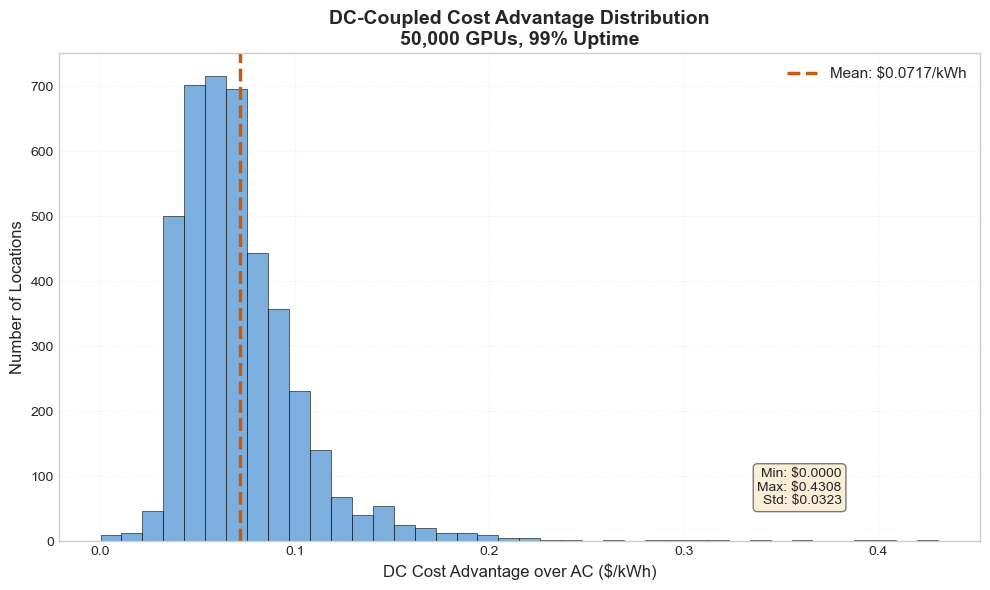

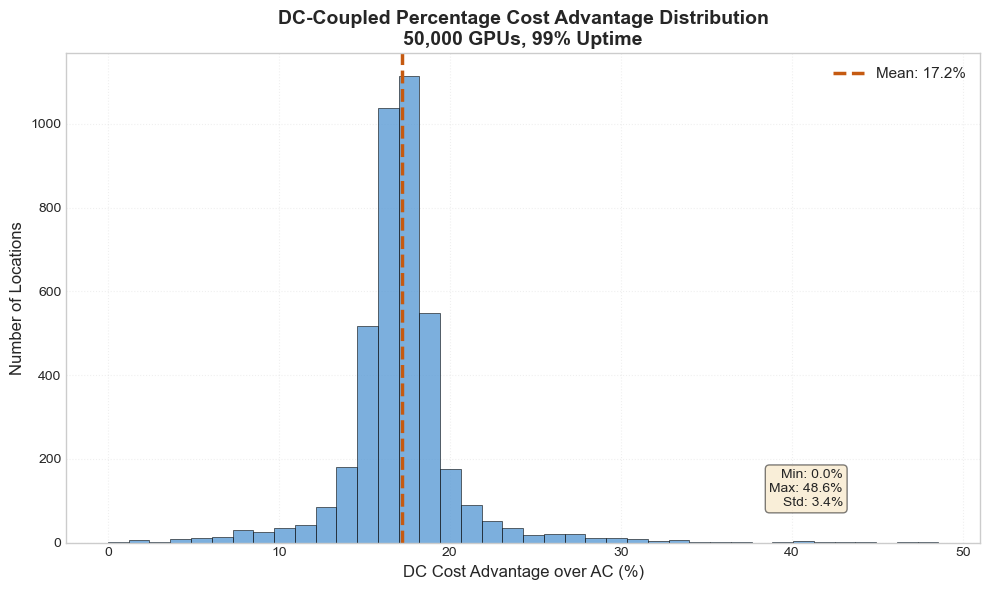


=== Percentile Analysis ===
P10: $0.0411/kWh (14.5%)
P25: $0.0500/kWh (15.9%)
P50: $0.0657/kWh (17.1%)
P75: $0.0852/kWh (18.2%)
P90: $0.1072/kWh (19.7%)
P95: $0.1277/kWh (21.8%)
P99: $0.1856/kWh (30.0%)


In [38]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_dc_advantage(df, gpu_count=50000, exclude_anomalies=True):
    """Analyze DC vs AC advantage with anomaly handling"""
    
    # Filter for GPU count and valid data
    subset = df[(df['gpu_count'] == gpu_count) & 
                (df['ac_coupled_base_lcoe'].notna()) & 
                (df['dc_coupled_base_lcoe'].notna())].copy()
    
    # Calculate advantages
    subset['dc_advantage_absolute'] = subset['ac_coupled_base_lcoe'] - subset['dc_coupled_base_lcoe']
    subset['dc_advantage_percent'] = (subset['dc_advantage_absolute'] / subset['ac_coupled_base_lcoe']) * 100
    
    # Identify anomalies (where AC appears cheaper)
    anomalies = subset[subset['dc_advantage_absolute'] < 0]
    
    print(f"Found {len(anomalies)} anomalous locations where AC appears cheaper than DC:")
    if len(anomalies) > 0:
        print("\nAnomaly details:")
        for _, row in anomalies.iterrows():
            print(f"  H3: {row['h3_index']}, PUE: {row['annual_pue']:.3f}, "
                  f"AC: ${row['ac_coupled_base_lcoe']:.4f}, DC: ${row['dc_coupled_base_lcoe']:.4f}")
    
    if exclude_anomalies:
        print(f"\n✓ Excluding {len(anomalies)} anomalous results from analysis")
        subset = subset[subset['dc_advantage_absolute'] > 0]
    
    print(f"\n=== DC vs AC Analysis ({gpu_count:,} GPUs) ===")
    print(f"Valid locations: {len(subset):,}")
    print(f"Mean DC advantage: ${subset['dc_advantage_absolute'].mean():.4f}/kWh ({subset['dc_advantage_percent'].mean():.1f}%)")
    print(f"Median DC advantage: ${subset['dc_advantage_absolute'].median():.4f}/kWh ({subset['dc_advantage_percent'].median():.1f}%)")
    print(f"Range: ${subset['dc_advantage_absolute'].min():.4f} to ${subset['dc_advantage_absolute'].max():.4f}/kWh")
    
    return subset

def plot_dc_advantage_histograms(subset, gpu_count=50000):
    """Create separate histogram plots for absolute and percentage advantages"""
    
    # Color scheme
    hist_color = "#5B9BD5"  # Professional blue
    mean_color = "#C55A11"  # Contrasting orange for mean line
    
    # Plot 1: Absolute Advantage
    plt.figure(figsize=(10, 6))
    
    counts, bins, patches = plt.hist(subset['dc_advantage_absolute'], 
                                     bins=40, 
                                     alpha=0.8, 
                                     edgecolor='black', 
                                     linewidth=0.5,
                                     color=hist_color)
    
    # Add mean line
    mean_val = subset['dc_advantage_absolute'].mean()
    plt.axvline(mean_val, color=mean_color, linestyle='--', linewidth=2.5,
                label=f'Mean: ${mean_val:.4f}/kWh')
    
    # Formatting
    plt.xlabel('DC Cost Advantage over AC ($/kWh)', fontsize=12)
    plt.ylabel('Number of Locations', fontsize=12)
    plt.title(f'DC-Coupled Cost Advantage Distribution\n{gpu_count:,} GPUs, 99% Uptime', 
              fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3, linestyle=':')
    
    # Add statistics box
    stats_text = f'Min: ${subset["dc_advantage_absolute"].min():.4f}\n' \
                 f'Max: ${subset["dc_advantage_absolute"].max():.4f}\n' \
                 f'Std: ${subset["dc_advantage_absolute"].std():.4f}'
    plt.text(0.85, 0.15, stats_text, transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             verticalalignment='top', horizontalalignment='right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'dc_advantage_absolute_{gpu_count}gpu.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 2: Percentage Advantage
    plt.figure(figsize=(10, 6))
    
    counts, bins, patches = plt.hist(subset['dc_advantage_percent'], 
                                     bins=40, 
                                     alpha=0.8, 
                                     edgecolor='black', 
                                     linewidth=0.5,
                                     color=hist_color)
    
    # Add mean line
    mean_pct = subset['dc_advantage_percent'].mean()
    plt.axvline(mean_pct, color=mean_color, linestyle='--', linewidth=2.5,
                label=f'Mean: {mean_pct:.1f}%')
    
    # Formatting
    plt.xlabel('DC Cost Advantage over AC (%)', fontsize=12)
    plt.ylabel('Number of Locations', fontsize=12)
    plt.title(f'DC-Coupled Percentage Cost Advantage Distribution\n{gpu_count:,} GPUs, 99% Uptime', 
              fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3, linestyle=':')
    
    # Add statistics box
    stats_text = f'Min: {subset["dc_advantage_percent"].min():.1f}%\n' \
                 f'Max: {subset["dc_advantage_percent"].max():.1f}%\n' \
                 f'Std: {subset["dc_advantage_percent"].std():.1f}%'
    plt.text(0.85, 0.15, stats_text, transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             verticalalignment='top', horizontalalignment='right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'dc_advantage_percentage_{gpu_count}gpu.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print percentile breakdown
    print(f"\n=== Percentile Analysis ===")
    for p in [10, 25, 50, 75, 90, 95, 99]:
        abs_val = subset['dc_advantage_absolute'].quantile(p/100)
        pct_val = subset['dc_advantage_percent'].quantile(p/100)
        print(f"P{p:2d}: ${abs_val:.4f}/kWh ({pct_val:.1f}%)")

# Run the analysis - CHANGE 'df' TO YOUR ACTUAL DATAFRAME NAME
subset_clean = analyze_dc_advantage(merged_df, gpu_count=50000, exclude_anomalies=True)  # Changed df to merged_df
plot_dc_advantage_histograms(subset_clean, gpu_count=50000)

DC Solar LCOE Statistics:
Mean: $0.3426/kWh
Median: $0.3323/kWh
Std Dev: $0.1054/kWh
Min: $0.1539/kWh
Max: $0.9663/kWh


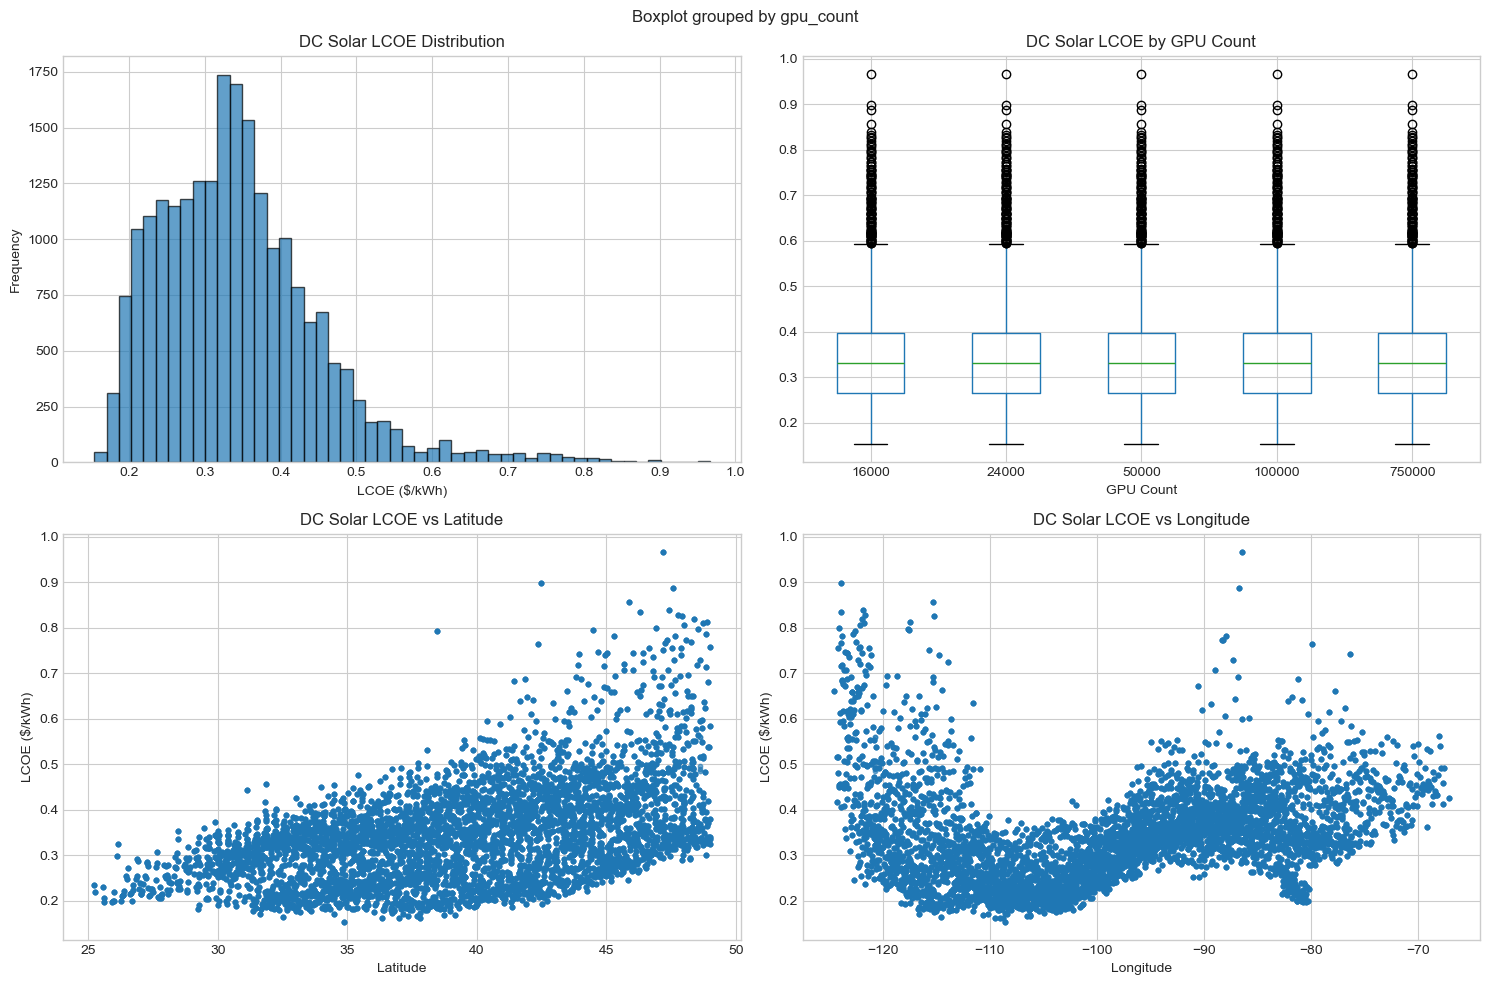

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistics
dc_solar_data = merged_df['dc_coupled_base_lcoe'].dropna()
print(f"DC Solar LCOE Statistics:")
print(f"Mean: ${dc_solar_data.mean():.4f}/kWh")
print(f"Median: ${dc_solar_data.median():.4f}/kWh") 
print(f"Std Dev: ${dc_solar_data.std():.4f}/kWh")
print(f"Min: ${dc_solar_data.min():.4f}/kWh")
print(f"Max: ${dc_solar_data.max():.4f}/kWh")

# Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0,0].hist(dc_solar_data, bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('DC Solar LCOE Distribution')
axes[0,0].set_xlabel('LCOE ($/kWh)')
axes[0,0].set_ylabel('Frequency')

# Box plot by GPU count
merged_df.boxplot(column='dc_coupled_base_lcoe', by='gpu_count', ax=axes[0,1])
axes[0,1].set_title('DC Solar LCOE by GPU Count')
axes[0,1].set_xlabel('GPU Count')

# Scatter: lat vs LCOE
axes[1,0].scatter(merged_df['latitude'], merged_df['dc_coupled_base_lcoe'], 
                  alpha=0.6, s=10)
axes[1,0].set_title('DC Solar LCOE vs Latitude')
axes[1,0].set_xlabel('Latitude')
axes[1,0].set_ylabel('LCOE ($/kWh)')

# Scatter: lon vs LCOE  
axes[1,1].scatter(merged_df['longitude'], merged_df['dc_coupled_base_lcoe'], 
                  alpha=0.6, s=10)
axes[1,1].set_title('DC Solar LCOE vs Longitude')
axes[1,1].set_xlabel('Longitude')
axes[1,1].set_ylabel('LCOE ($/kWh)')

plt.tight_layout()
plt.show()

In [10]:
# Clean calculation: Cost per kWh of downtime
import numpy as np
from config import load_config

def calculate_downtime_cost_per_kwh(
    total_gpus: int,
    annual_outage_pct: float,
    config=None
):
    """
    Calculate the cost per kWh of energy NOT delivered due to downtime.
    
    Args:
        total_gpus: Number of GPUs
        annual_outage_pct: Outage percentage (1.0 = 1% = 99% uptime)
        
    Returns:
        Dict with downtime costs expressed as $/kWh
    """
    cfg = config or load_config()
    
    HOURS_PER_YEAR = 8760
    discount_rate = cfg.financial.discount_rate
    evaluation_years = cfg.financial.evaluation_years
    
    # Downtime hours per year
    downtime_hours_per_year = HOURS_PER_YEAR * (annual_outage_pct / 100)
    
    # Energy that WOULD have been consumed (but wasn't)
    total_nodes = total_gpus // cfg.it_load.gpus_per_node
    it_load_avg_mw = (total_nodes * cfg.it_load.node_power_avg_kw) / 1000
    facility_load_avg_mw = it_load_avg_mw * cfg.it_load.default_pue
    undelivered_energy_mwh_per_year = facility_load_avg_mw * downtime_hours_per_year
    
    # Lost compute value per year
    lost_compute_value_per_year = total_gpus * cfg.costs.gpu_hour_spot_price * downtime_hours_per_year
    
    # NPV calculations
    npv_lost_compute_value = sum(
        lost_compute_value_per_year / ((1 + discount_rate) ** (year + 0.5))
        for year in range(evaluation_years)
    )
    
    npv_undelivered_energy_mwh = sum(
        undelivered_energy_mwh_per_year / ((1 + discount_rate) ** (year + 0.5))
        for year in range(evaluation_years)
    )
    
    # Cost per kWh of downtime
    cost_per_kwh_downtime = npv_lost_compute_value / (npv_undelivered_energy_mwh * 1000)
    
    return {
        'annual_outage_pct': annual_outage_pct,
        'uptime_pct': 100 - annual_outage_pct,
        'downtime_hours_per_year': downtime_hours_per_year,
        'undelivered_energy_mwh_per_year': undelivered_energy_mwh_per_year,
        'lost_compute_value_per_year': lost_compute_value_per_year,
        'npv_lost_compute_value': npv_lost_compute_value,
        'npv_undelivered_energy_mwh': npv_undelivered_energy_mwh,
        'cost_per_kwh_downtime': cost_per_kwh_downtime
    }

# Run the analysis
cfg = load_config()
total_gpus = 50_000

print("="*80)
print("DOWNTIME COST ANALYSIS")
print("="*80)
print(f"Datacenter: {total_gpus:,} GPUs")
print(f"GPU opportunity cost: ${cfg.costs.gpu_hour_spot_price:.2f}/GPU-hour")
print(f"Discount rate: {cfg.financial.discount_rate*100:.1f}%")
print(f"Evaluation period: {cfg.financial.evaluation_years} years")
print()

outage_scenarios = [
    (1.0, "99% uptime"),
    (0.1, "99.9% uptime"),
    (0.01, "99.99% uptime"),
]

print("What does downtime cost per kWh of undelivered energy?")
print("-"*80)
print(f"{'Scenario':<20} {'Outage %':<12} {'Hours/Yr':<12} {'Lost Value':<15} {'Cost/kWh':<15}")
print(f"{'':20} {'':12} {'':12} {'($M NPV)':<15} {'Downtime':<15}")
print("-"*80)

results = []
for outage_pct, description in outage_scenarios:
    result = calculate_downtime_cost_per_kwh(total_gpus, outage_pct, cfg)
    results.append((description, result))
    
    print(f"{description:<20} "
          f"{result['annual_outage_pct']:<12.2f} "
          f"{result['downtime_hours_per_year']:<12.1f} "
          f"${result['npv_lost_compute_value']/1e6:<14.1f} "
          f"${result['cost_per_kwh_downtime']:<14.4f}")

print("-"*80)
print()

# Now calculate marginal comparisons
print("="*80)
print("MARGINAL RELIABILITY ECONOMICS")
print("="*80)
print()
print("How much MORE can you pay per kWh for better reliability?")
print("-"*80)

comparisons = [
   
    (10, 1.0, "90% -> 99%"),
    (1.0, 0.1, "99% → 99.9%"),
    (.1, 0.01, "99% → 99.99%"),
   
]

for baseline_outage, target_outage, description in comparisons:
    baseline_result = calculate_downtime_cost_per_kwh(total_gpus, baseline_outage, cfg)
    target_result = calculate_downtime_cost_per_kwh(total_gpus, target_outage, cfg)
    
    # Energy delivered at baseline vs target
    baseline_uptime_hrs = 8760 * (100 - baseline_outage) / 100
    target_uptime_hrs = 8760 * (100 - target_outage) / 100
    
    total_nodes = total_gpus // cfg.it_load.gpus_per_node
    it_load_avg_mw = (total_nodes * cfg.it_load.node_power_avg_kw) / 1000
    facility_load_avg_mw = it_load_avg_mw * cfg.it_load.default_pue
    
    baseline_energy_per_year = facility_load_avg_mw * baseline_uptime_hrs
    target_energy_per_year = facility_load_avg_mw * target_uptime_hrs
    
    # NPV of energy delivered
    npv_baseline_energy = sum(
        baseline_energy_per_year / ((1 + cfg.financial.discount_rate) ** (year + 0.5))
        for year in range(cfg.financial.evaluation_years)
    )
    
    npv_target_energy = sum(
        target_energy_per_year / ((1 + cfg.financial.discount_rate) ** (year + 0.5))
        for year in range(cfg.financial.evaluation_years)
    )
    
    # Avoided downtime cost
    avoided_downtime_cost = baseline_result['npv_lost_compute_value'] - target_result['npv_lost_compute_value']
    
    # Marginal WTP = avoided cost / target energy delivered
    marginal_wtp_per_kwh = avoided_downtime_cost / (npv_target_energy * 1000)
    
    print(f"\n{description}:")
    print(f"  Avoided downtime cost (NPV): ${avoided_downtime_cost/1e6:.1f}M")
    print(f"  Energy delivered over lifetime (NPV): {npv_target_energy:,.0f} MWh")
    print(f"  → Maximum additional cost: ${marginal_wtp_per_kwh:.4f}/kWh")
    print(f"  ")
    print(f"  Decision rule: If LCOE difference < ${marginal_wtp_per_kwh:.4f}/kWh, ")
    print(f"                 pay for the higher reliability system")

print()
print("-"*80)

DOWNTIME COST ANALYSIS
Datacenter: 50,000 GPUs
GPU opportunity cost: $2.40/GPU-hour
Discount rate: 7.0%
Evaluation period: 27 years

What does downtime cost per kWh of undelivered energy?
--------------------------------------------------------------------------------
Scenario             Outage %     Hours/Yr     Lost Value      Cost/kWh       
                                               ($M NPV)        Downtime       
--------------------------------------------------------------------------------
99% uptime           1.00         87.6         $130.3          $2.1918        
99.9% uptime         0.10         8.8          $13.0           $2.1918        
99.99% uptime        0.01         0.9          $1.3            $2.1918        
--------------------------------------------------------------------------------

MARGINAL RELIABILITY ECONOMICS

How much MORE can you pay per kWh for better reliability?
--------------------------------------------------------------------------------

9

In [8]:
import numpy as np
import math
from config import load_config
from it_facil import calculate_facility_load
from power_systems_estimator import PowerFlowAnalyzer

# Configuration
cfg = load_config()
total_gpus = 100_000
location = (33.8361, -100.1637)  # South Carolina
annual_outage_hours = 25.0  # Actual outage runtime (not including testing)
fuel_storage_days = 2.0

# Step 1: Calculate facility load
facility = calculate_facility_load(
    total_gpus=total_gpus,
    config=cfg,
    required_uptime_pct=99.0
)

print(f"Facility Requirements (at datacenter):")
print(f"  IT Load Design: {facility.it_load_design_mw:.1f} MW")
print(f"  Cooling Load Design: {facility.cooling_load_design_mw:.1f} MW")
print(f"  Total Facility Load Design: {facility.facility_load_design_mw:.1f} MW")
print(f"  Annual Energy: {facility.annual_facility_energy_mwh:,.0f} MWh")

# Step 2: Apply power systems effects (matching natgas_system_tool.py)
power_analyzer = PowerFlowAnalyzer(cfg)
mult = power_analyzer.get_bus_architecture_multipliers("natural_gas")

# Calculate power demanded at bus
total_bus_demand_mw = (facility.it_load_design_mw * mult['bus_to_it'] + 
                       facility.cooling_load_design_mw * mult['bus_to_cooling'])

# Gross up to find required generation at diesel output
required_generation_mw = total_bus_demand_mw * mult['grid_to_bus']

print(f"\nPower System Effects:")
print(f"  Bus to IT multiplier: {mult['bus_to_it']:.4f}")
print(f"  Bus to Cooling multiplier: {mult['bus_to_cooling']:.4f}")
print(f"  Grid to Bus multiplier: {mult['grid_to_bus']:.4f}")
print(f"  Required Generation (at diesel output): {required_generation_mw:.1f} MW")
print(f"  Power system overhead: {((required_generation_mw/facility.facility_load_design_mw - 1)*100):.2f}%")

# Similarly for annual energy
annual_bus_demand_mwh = (facility.annual_it_energy_mwh * mult['bus_to_it'] +
                         facility.annual_cooling_energy_mwh * mult['bus_to_cooling'])
annual_generation_required_mwh = annual_bus_demand_mwh * mult['grid_to_bus']

print(f"  Annual Generation Required: {annual_generation_required_mwh:,.0f} MWh")

# Step 3: Size diesel system based on REQUIRED GENERATION
target_mw = required_generation_mw  # This is the key fix
genset_capacity_mw = 2.0
n_gensets_required = math.ceil(target_mw / genset_capacity_mw)
n_gensets_total = n_gensets_required + 1  # N+1 redundancy
total_diesel_capacity_mw = n_gensets_total * genset_capacity_mw

print(f"\nDiesel System Sizing:")
print(f"  Required: {n_gensets_required} x {genset_capacity_mw} MW gensets")
print(f"  Installed (N+1): {n_gensets_total} gensets")
print(f"  Total Capacity: {total_diesel_capacity_mw:.1f} MW")

# Step 4: Size fuel storage for specified days at full load
fuel_storage_hours = fuel_storage_days * 24
fuel_storage_gallons = int(target_mw * 1000 * fuel_storage_hours * 
                            (cfg.costs.diesel_eff / 1000))

print(f"  Fuel Storage: {fuel_storage_gallons:,} gallons ({fuel_storage_days} days @ full load)")
print(f"  Runtime Capability: {fuel_storage_hours:.0f} hours at {target_mw:.1f} MW")

# Step 5: Calculate capital costs
genset_capex = total_diesel_capacity_mw * 1000 * cfg.costs.diesel_genset_cost_per_kw
fuel_tank_capex = fuel_storage_gallons * cfg.costs.diesel_tank_cost_per_gallon
total_capex = genset_capex + fuel_tank_capex

print(f"\nCapital Costs:")
print(f"  Gensets: ${genset_capex/1e6:.2f}M")
print(f"  Fuel Tanks: ${fuel_tank_capex/1e6:.2f}M")
print(f"  Total CapEx: ${total_capex/1e6:.2f}M")

# Step 6: Calculate annual operating costs (at generator output)
testing_hours = cfg.costs.diesel_test_hours_per_year
total_runtime_hours = annual_outage_hours + testing_hours

annual_generation_mwh = target_mw * total_runtime_hours
annual_fuel_cost = annual_generation_mwh * (cfg.costs.diesel_eff / 1000) * cfg.costs.diesel_cost
annual_var_om = annual_generation_mwh * cfg.costs.diesel_var_om_per_mwh
annual_fixed_om = total_capex * 0.06  # 6% of capex annually

annual_opex = annual_fuel_cost + annual_var_om + annual_fixed_om

print(f"\nAnnual Operating Costs:")
print(f"  Runtime Hours: {total_runtime_hours:.0f} ({annual_outage_hours:.0f} outage + {testing_hours:.0f} testing)")
print(f"  Generation (at diesel output): {annual_generation_mwh:,.0f} MWh")
print(f"  Fuel Cost: ${annual_fuel_cost/1e6:.2f}M")
print(f"  Variable O&M: ${annual_var_om/1e3:.1f}k")
print(f"  Fixed O&M: ${annual_fixed_om/1e6:.2f}M")
print(f"  Total Annual OpEx: ${annual_opex/1e6:.2f}M")

# Step 7: Calculate NPV
discount_rate = cfg.financial.discount_rate
evaluation_years = cfg.financial.evaluation_years

def calculate_npv(cash_flows, discount_rate, start_year=0):
    """Mid-year discounting matching lcoe_calc.py"""
    npv = 0
    for i, cf in enumerate(cash_flows):
        year = start_year + i
        npv += cf / ((1 + discount_rate) ** (year + 0.5))
    return npv

capex_npv = total_capex
opex_flows = [annual_opex] * evaluation_years
opex_npv = calculate_npv(opex_flows, discount_rate)

# Energy denominator: use DELIVERED energy at datacenter for marginal LCOE
energy_flows = [facility.annual_facility_energy_mwh] * evaluation_years
energy_npv = calculate_npv(energy_flows, discount_rate)

# Step 8: Calculate marginal LCOE
total_cost_npv = capex_npv + opex_npv
marginal_lcoe_per_kwh = (total_cost_npv / energy_npv) / 1000

print(f"\n{'='*70}")
print(f"MARGINAL DIESEL LCOE CALCULATION")
print(f"{'='*70}")
print(f"NPV Analysis ({evaluation_years} years @ {discount_rate*100:.1f}% discount rate):")
print(f"  CapEx NPV: ${capex_npv/1e6:.2f}M")
print(f"  OpEx NPV: ${opex_npv/1e6:.2f}M")
print(f"  Total Cost NPV: ${total_cost_npv/1e6:.2f}M")
print(f"  Energy NPV (delivered): {energy_npv/1e6:.1f}M MWh")
print(f"\n  MARGINAL LCOE: ${marginal_lcoe_per_kwh:.5f}/kWh")
print(f"  MARGINAL LCOE: ${marginal_lcoe_per_kwh*1000:.3f}/MWh")

# Step 9: Compare to grid baseline
from lcoe_calc import GRID_BASELINE_DATA
state = 'South Carolina'
if state in GRID_BASELINE_DATA:
    _, _, grid_price_cents, _ = GRID_BASELINE_DATA[state]
    grid_lcoe = grid_price_cents / 100.0
    combined_lcoe = grid_lcoe + marginal_lcoe_per_kwh
    
    print(f"\n{'='*70}")
    print(f"COMPARISON TO GRID BASELINE (South Carolina)")
    print(f"{'='*70}")
    print(f"  Grid Only: ${grid_lcoe:.5f}/kWh")
    print(f"  Diesel Marginal: ${marginal_lcoe_per_kwh:.5f}/kWh")
    print(f"  Grid + Diesel: ${combined_lcoe:.5f}/kWh")
    print(f"  Percentage Increase: {(marginal_lcoe_per_kwh/grid_lcoe)*100:.2f}%")

Facility Requirements (at datacenter):
  IT Load Design: 111.6 MW
  Cooling Load Design: 22.3 MW
  Total Facility Load Design: 133.9 MW
  Annual Energy: 949,628 MWh

Power System Effects:
  Bus to IT multiplier: 1.0746
  Bus to Cooling multiplier: 1.0309
  Grid to Bus multiplier: 1.1076
  Required Generation (at diesel output): 158.3 MW
  Power system overhead: 18.21%
  Annual Generation Required: 1,122,577 MWh

Diesel System Sizing:
  Required: 80 x 2.0 MW gensets
  Installed (N+1): 81 gensets
  Total Capacity: 162.0 MW
  Fuel Storage: 1,899,080 gallons (2.0 days @ full load)
  Runtime Capability: 48 hours at 158.3 MW

Capital Costs:
  Gensets: $129.60M
  Fuel Tanks: $5.70M
  Total CapEx: $135.30M

Annual Operating Costs:
  Runtime Hours: 49 (25 outage + 24 testing)
  Generation (at diesel output): 7,755 MWh
  Fuel Cost: $0.01M
  Variable O&M: $93.1k
  Fixed O&M: $8.12M
  Total Annual OpEx: $8.22M

MARGINAL DIESEL LCOE CALCULATION
NPV Analysis (27 years @ 7.0% discount rate):
  CapEx 